In [1]:
%load_ext autoreload
%autoreload 2
import modus.dna as md
from modus.dna.constants import DO_NOT_LOG_COLUMNS

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import seaborn as sns
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Activation, Dense, LSTM, Dropout, GlobalMaxPooling1D, Bidirectional, GRU, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 
from keras.layers.core import Dense
from keras.initializers import glorot_uniform
from keras.optimizers import adam_v2 # not sure if this is the same
from keras.metrics import categorical_crossentropy, BinaryAccuracy, PrecisionAtRecall, CategoricalAccuracy, Precision, Recall
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tensorflow.keras.callbacks import Callback
import keras_tuner as kt
import numpy as np
import os

from scipy.stats import spearmanr

def find_parent_dirs(filename, directory = None, max_depth = 10, verbose = 0):
    if max_depth <= 0:
        return None
    print(f"Searching {directory}") if verbose else None
    print(os.listdir(directory)) if verbose else None
    if filename in os.listdir(directory):
        print(f"Found - {directory+filename} !")
        return directory + filename
    return find_parent_dirs(filename, '../' + (directory if directory else ''), max_depth = max_depth - 1, verbose = verbose)

nearest_excel_file = find_parent_dirs('TEST_DATA.csv')

d1 = md.read_bloomberg_csv(nearest_excel_file)

Loaded Modus library development build. Latest git commit:

	commit 4333b3b218e30e0aa8b967eefee693e890be1cea
	Author: henry.tang <henry.tang@modusasset.com.hk>
	Date:   Wed May 25 13:23:00 2022 +0800
	
	    Add iterassetname
	
Found - ../../../TEST_DATA.csv !


In [2]:
d1.to_csv('DATA.csv')

# CCMP INDEX

### Delete Duplicate Data

In [2]:
d1 = d1.loc[:,~d1.columns.duplicated()] 

In [3]:
#MSFT debuted on the 14th March 1986
d1 = d1[d1.index >= '1986-06-30']
# d1 = d1[d1.index < '2020-12-31']

### Add RSI as features

In [4]:
df = d1.loc[:, (slice(None), 'PX_LAST')]

class RSI():
    def __init__(self,v,days=14):
        self.px_last = v
        self.days = days
        self.diff = self.px_last.diff(periods=1)
        self.up = self.diff.clip(lower=0)
        self.down = -1*self.diff.clip(upper=0)
        self.ema_up = self.up.ewm(com=self.days-1, adjust=False).mean()
        self.ema_down = self.down.ewm(com=self.days-1, adjust=False).mean()
        self.rs = self.ema_up/self.ema_down
        self.RSI = 100 - (100/(1+self.rs))
        
RSI_df = pd.DataFrame()
for i in range(len(df.columns)):
    X = pd.DataFrame(df.iloc[:,i])
    Asset14 = RSI(X,14)
    Asset30 = RSI(X,30)
    Asset14 = Asset14.RSI.rename(columns={'PX_LAST':'RSI_14D'})
    Asset30 = Asset30.RSI.rename(columns={'PX_LAST':'RSI_30D'})
    d1 = pd.concat([d1, Asset14], axis = 1)
    d1 = pd.concat([d1, Asset30], axis = 1)

### Add Bollinger Band as features

In [5]:
#---------------------------------------------------------------#
TA = 'CCMP Index' # <-- remember to change the target asset name
#---------------------------------------------------------------#

Target_Last, Target_High, Target_Low = d1.loc[:, ([TA], ['PX_LAST'])], d1.loc[:, ([TA], ['PX_HIGH'])], d1.loc[:, ([TA], ['PX_LOW'])]
Data_target = pd.concat([Target_Last, Target_High, Target_Low], axis = 1)

class BOLL():
    def __init__(self,v,days=20  ):
        self.d_target = v
        self.days = days        
        self.avg = self.d_target.mean(axis=1)
        self.stdev = self.avg.rolling(self.days).std(ddof=0)
        self.middle = self.avg.rolling(self.days).mean()
        self.high = self.middle + 2*self.stdev
        self.low = self.middle - 2*self.stdev
BOLL_df = pd.DataFrame()
target = BOLL(Data_target,20)
d_B = pd.DataFrame()
d_B[(TA,'BB_H_DEV')] = d1[TA, 'PX_LAST']/target.high - 1
d_B[(TA,'BB_M_DEV')] = d1[TA, 'PX_LAST']/target.middle - 1
d_B[(TA,'BB_L_DEV')] = d1[TA, 'PX_LAST']/target.low - 1

d1 = pd.concat([d1, d_B], axis = 1)

### Add VIX TECHNICAL

In [6]:
#---------------------------------------------------------------#
TA = 'VIX Index' # <-- remember to change the target asset name
#---------------------------------------------------------------#
import talib 

Target_Open, Target_Last, Target_High, Target_Low = d1.loc[:, ([TA], ['PX_OPEN'])], d1.loc[:, ([TA], ['PX_LAST'])], d1.loc[:, ([TA], ['PX_HIGH'])], d1.loc[:, ([TA], ['PX_LOW'])]
Data_target = pd.concat([Target_Open, Target_Last, Target_High, Target_Low], axis = 1)

SMA20 = talib.SMA(Data_target[TA,'PX_LAST'], timeperiod=20)
SMA10 = talib.SMA(Data_target[TA,'PX_LAST'], timeperiod=10)
SMA5 = talib.SMA(Data_target[TA,'PX_LAST'], timeperiod=5)

d_TA = pd.DataFrame()
d_TA[(TA,'SMA5')] = SMA5
d_TA[(TA,'SMA10')] = SMA10
d_TA[(TA,'SMA20')] = SMA20

d1 = pd.concat([d1, d_TA], axis = 1)

### Add TA-LIB III

In [7]:
#---------------------------------------------------------------#
TA = 'CCMP Index' # <-- remember to change the target asset name
#---------------------------------------------------------------#
import talib

Target_Open, Target_Last, Target_High, Target_Low = d1.loc[:, ([TA], ['PX_OPEN'])], d1.loc[:, ([TA], ['PX_LAST'])], d1.loc[:, ([TA], ['PX_HIGH'])], d1.loc[:, ([TA], ['PX_LOW'])]
Data_target = pd.concat([Target_Open, Target_Last, Target_High, Target_Low], axis = 1)


SHOOT_STAR = talib.CDLSHOOTINGSTAR(Data_target[TA,'PX_OPEN'], 
                                     Data_target[TA,'PX_HIGH'], 
                                     Data_target[TA,'PX_LOW'], 
                                     Data_target[TA,'PX_LAST'])

DOJI_STAR = talib.CDLDOJISTAR(Data_target[TA,'PX_OPEN'], 
                             Data_target[TA,'PX_HIGH'], 
                             Data_target[TA,'PX_LOW'], 
                             Data_target[TA,'PX_LAST'])

INV_HAM = talib.CDLINVERTEDHAMMER(Data_target[TA,'PX_OPEN'], 
                                 Data_target[TA,'PX_HIGH'], 
                                 Data_target[TA,'PX_LOW'], 
                                 Data_target[TA,'PX_LAST'])

EV_STAR = talib.CDLEVENINGSTAR(Data_target[TA,'PX_OPEN'], 
                                 Data_target[TA,'PX_HIGH'], 
                                 Data_target[TA,'PX_LOW'], 
                                 Data_target[TA,'PX_LAST'], penetration = 0)

AB_BABY = talib.CDLABANDONEDBABY(Data_target[TA,'PX_OPEN'], 
                                 Data_target[TA,'PX_HIGH'], 
                                 Data_target[TA,'PX_LOW'], 
                                 Data_target[TA,'PX_LAST'], penetration = 0)

LINE_STRIKE = talib.CDL3LINESTRIKE(Data_target[TA,'PX_OPEN'], 
                                 Data_target[TA,'PX_HIGH'], 
                                 Data_target[TA,'PX_LOW'], 
                                 Data_target[TA,'PX_LAST'])

BLK_CROWS = talib.CDL3BLACKCROWS(Data_target[TA,'PX_OPEN'], 
                                 Data_target[TA,'PX_HIGH'], 
                                 Data_target[TA,'PX_LOW'], 
                                 Data_target[TA,'PX_LAST'])

GAP_CROWS = talib.CDLUPSIDEGAP2CROWS(Data_target[TA,'PX_OPEN'], 
                                 Data_target[TA,'PX_HIGH'], 
                                 Data_target[TA,'PX_LOW'], 
                                 Data_target[TA,'PX_LAST'])

# ADX - Average Directional Movement Index
ADX = talib.ADX(Data_target[TA,'PX_HIGH'],
                Data_target[TA,'PX_LOW'],
                Data_target[TA,'PX_LAST'],
                timeperiod = 14)

# HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
HT_TRENDMODE = talib.HT_TRENDMODE(Data_target[TA,'PX_LAST'])

# Simple Moving Average
SMA10 = talib.SMA(Data_target[TA,'PX_LAST'], timeperiod=10)
SMA20 = talib.SMA(Data_target[TA,'PX_LAST'], timeperiod=20)

d_TA = pd.DataFrame()
d_TA[(TA,'SMA10')] = SMA10
d_TA[(TA,'SMA20')] = SMA20
d_TA[(TA,'SHOOT_STAR')] = SHOOT_STAR
d_TA[(TA,'DOJI_STAR')] = DOJI_STAR
d_TA[(TA,'INV_HAM')] = INV_HAM
d_TA[(TA,'EV_STAR')] = EV_STAR
d_TA[(TA,'AB_BABY')] = AB_BABY
d_TA[(TA,'LINE_STRIKE')] = LINE_STRIKE
d_TA[(TA,'BLK_CROWS')] = BLK_CROWS
d_TA[(TA,'GAP_CROWS')] = GAP_CROWS
d_TA[(TA,'ADX')] = ADX
d_TA[(TA,'HT_TRENDMODE')] = HT_TRENDMODE

d1 = pd.concat([d1, d_TA], axis = 1)

In [8]:
# drop all columns that has no data
for col_name in d1.columns[(d1.isna()).all()]:
    print(f"{col_name} is dropped as all entries are nan.")
d1.drop(d1.columns[(d1.isna()).all()], axis=1, inplace=True)

# drop all columns that has "NA" more than the designated % 
drop_pct = 0.050
for col_name, nan_pct in (d1.isna().sum() / len(d1)).iteritems():
    if nan_pct > drop_pct:
        print(f"{col_name} is dropped as there are {nan_pct*100:.1f}% nan's")
d1.drop(d1.columns[
    d1.isna().sum() / len(d1) > drop_pct
], axis=1, inplace=True)

for col_name, zero_pct in ((d1.fillna(0) == 0).sum() / len(d1)).iteritems():
    if zero_pct > drop_pct:
        print(f"{col_name} is dropped as there are {zero_pct*100:.1f}% 0's")
d1.drop(d1.columns[
    (d1.fillna(0) == 0).sum() / len(d1) == 1
], axis=1, inplace=True)

('VIX Index', 'BEST_PX_BPS_RATIO') is dropped as all entries are nan.
('VIX Index', 'PX_VOLUME') is dropped as all entries are nan.
('VIX Index', 'BEST_ESTIMATE_FCF') is dropped as all entries are nan.
('VIX Index', 'BEST_PE_NXT_YR') is dropped as all entries are nan.
('VIX Index', 'BEST_ANALYST_RATING') is dropped as all entries are nan.
('AUDJPY Curncy', 'BEST_PX_BPS_RATIO') is dropped as all entries are nan.
('AUDJPY Curncy', 'PX_VOLUME') is dropped as all entries are nan.
('AUDJPY Curncy', 'BEST_ESTIMATE_FCF') is dropped as all entries are nan.
('AUDJPY Curncy', 'BEST_PE_NXT_YR') is dropped as all entries are nan.
('AUDJPY Curncy', 'BEST_ANALYST_RATING') is dropped as all entries are nan.
('CCMP Index', 'BEST_ESTIMATE_FCF') is dropped as all entries are nan.
('CCMP Index', 'BEST_PE_NXT_YR') is dropped as all entries are nan.
('CCMP Index', 'BEST_ANALYST_RATING') is dropped as all entries are nan.
('DXY Curncy', 'BEST_PX_BPS_RATIO') is dropped as all entries are nan.
('DXY Curncy', 

In [9]:
for col_name, nan_pct in (d1.isna().sum() / len(d1)).iteritems():
    if nan_pct > 0.05:
        print(f"{str(col_name):30}  {nan_pct*100:.1f}% nan's")

<AxesSubplot:xlabel='None-None'>

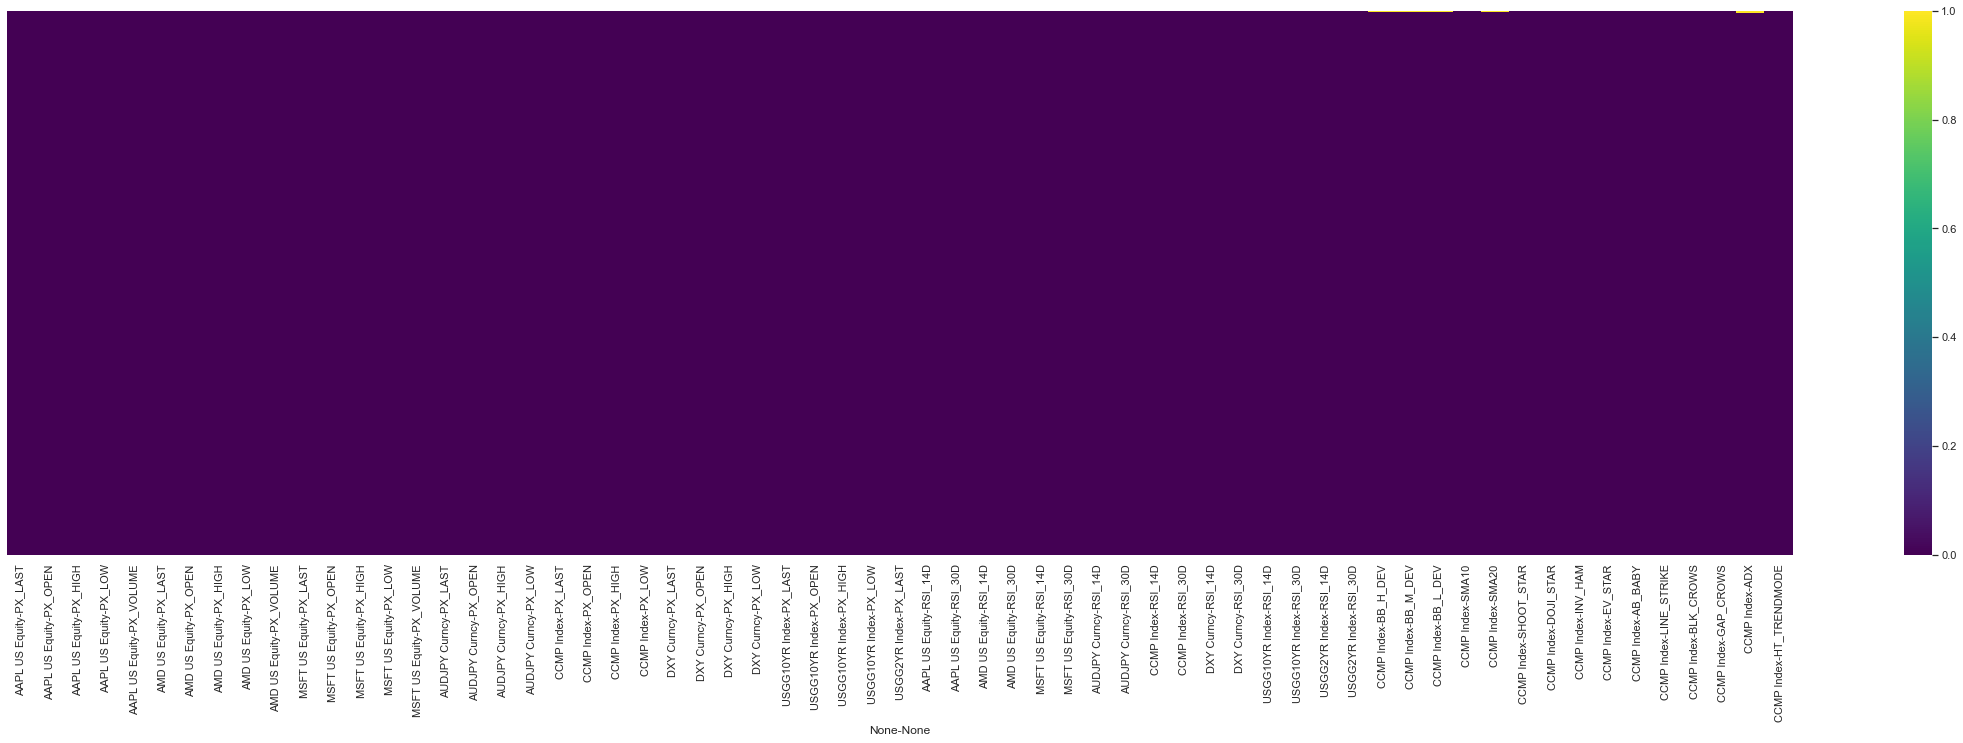

In [10]:
sns.set(rc = {'figure.figsize':(40,10)})
sns.heatmap(d1.isnull(),yticklabels=False, cmap = 'viridis')

In [11]:
print(list(d1.columns))

[('AAPL US Equity', 'PX_LAST'), ('AAPL US Equity', 'PX_OPEN'), ('AAPL US Equity', 'PX_HIGH'), ('AAPL US Equity', 'PX_LOW'), ('AAPL US Equity', 'PX_VOLUME'), ('AMD US Equity', 'PX_LAST'), ('AMD US Equity', 'PX_OPEN'), ('AMD US Equity', 'PX_HIGH'), ('AMD US Equity', 'PX_LOW'), ('AMD US Equity', 'PX_VOLUME'), ('MSFT US Equity', 'PX_LAST'), ('MSFT US Equity', 'PX_OPEN'), ('MSFT US Equity', 'PX_HIGH'), ('MSFT US Equity', 'PX_LOW'), ('MSFT US Equity', 'PX_VOLUME'), ('AUDJPY Curncy', 'PX_LAST'), ('AUDJPY Curncy', 'PX_OPEN'), ('AUDJPY Curncy', 'PX_HIGH'), ('AUDJPY Curncy', 'PX_LOW'), ('CCMP Index', 'PX_LAST'), ('CCMP Index', 'PX_OPEN'), ('CCMP Index', 'PX_HIGH'), ('CCMP Index', 'PX_LOW'), ('DXY Curncy', 'PX_LAST'), ('DXY Curncy', 'PX_OPEN'), ('DXY Curncy', 'PX_HIGH'), ('DXY Curncy', 'PX_LOW'), ('USGG10YR Index', 'PX_LAST'), ('USGG10YR Index', 'PX_OPEN'), ('USGG10YR Index', 'PX_HIGH'), ('USGG10YR Index', 'PX_LOW'), ('USGG2YR Index', 'PX_LAST'), ('AAPL US Equity', 'RSI_14D'), ('AAPL US Equity', 

### Create the column with the return of CCMP

In [12]:
# This is the PX_LAST(Last Price) of CCMP Index
d1[('CCMP Index','PX_LAST')]

1986-06-30      405.51
1986-07-01      407.61
1986-07-02      409.48
1986-07-03      411.16
1986-07-04      411.16
                ...   
2022-03-18    13893.84
2022-03-21    13838.46
2022-03-22    14108.82
2022-03-23    13922.60
2022-03-24    13922.60
Name: (CCMP Index, PX_LAST), Length: 9324, dtype: float64

In [13]:
# This shifts the price from time "t+1" to time "t"
d1[('CCMP Index','PX_LAST')].shift(-1)

1986-06-30      407.61
1986-07-01      409.48
1986-07-02      411.16
1986-07-03      411.16
1986-07-04      400.96
                ...   
2022-03-18    13838.46
2022-03-21    14108.82
2022-03-22    13922.60
2022-03-23    13922.60
2022-03-24         NaN
Name: (CCMP Index, PX_LAST), Length: 9324, dtype: float64

In [14]:
# This shifts the price from time "t" to time "t+1"
d1[('CCMP Index','PX_LAST')].shift(1)

1986-06-30         NaN
1986-07-01      405.51
1986-07-02      407.61
1986-07-03      409.48
1986-07-04      411.16
                ...   
2022-03-18    13614.78
2022-03-21    13893.84
2022-03-22    13838.46
2022-03-23    14108.82
2022-03-24    13922.60
Name: (CCMP Index, PX_LAST), Length: 9324, dtype: float64

In [15]:
# This 'CCMP_Daily return' records the  return of the stock  = price @ t / price @ t-1 
d1['CCMP_Daily return'] = d1[('CCMP Index','PX_LAST')]/d1[('CCMP Index','PX_LAST')].shift()

In [16]:
# This calculates the log return of the data.
np.log(d1['CCMP_Daily return'] )

1986-06-30         NaN
1986-07-01    0.005165
1986-07-02    0.004577
1986-07-03    0.004094
1986-07-04    0.000000
                ...   
2022-03-18    0.020290
2022-03-21   -0.003994
2022-03-22    0.019348
2022-03-23   -0.013287
2022-03-24    0.000000
Name: CCMP_Daily return, Length: 9324, dtype: float64

In [17]:
# This also calculates the log return of the data.
np.log(d1['CCMP Index','PX_LAST'])-np.log(d1[('CCMP Index','PX_LAST')].shift(1))

1986-06-30         NaN
1986-07-01    0.005165
1986-07-02    0.004577
1986-07-03    0.004094
1986-07-04    0.000000
                ...   
2022-03-18    0.020290
2022-03-21   -0.003994
2022-03-22    0.019348
2022-03-23   -0.013287
2022-03-24    0.000000
Name: (CCMP Index, PX_LAST), Length: 9324, dtype: float64

In [18]:
#The mean daily return of CCMP
print(np.mean(d1['CCMP_Daily return'])*100,'%')

100.04764934088446 %


We attempt to enforce the $\mu_1$ to hover around the following value (only on the training set to make sure no information outside of the training set is given to the training parameters).

In [19]:
est_mu1 = np.mean(np.log(d1['CCMP_Daily return'] ))
est_mu1

0.0003792902674989007

Take a log of the PX_LAST of the target asset as well as the features.

In [20]:
d1['AMD_log_PX_LAST'] = np.log(d1['AMD US Equity','PX_LAST'])
d1['AUDJPY_log_PX_LAST'] = np.log(d1['AUDJPY Curncy','PX_LAST'])
d1['MSFT_log_PX_LAST'] = np.log(d1['MSFT US Equity','PX_LAST'])
d1['AAPL_log_PX_LAST'] = np.log(d1['AAPL US Equity','PX_LAST'])
d1['USGG10YR_log_PX_LAST'] = np.log(d1['USGG10YR Index','PX_LAST'])
d1['USGG2YR_log_PX_LAST'] = np.log(d1['USGG2YR Index','PX_LAST'])

d1['CCMP_log_PX_LAST'] = np.log(d1['CCMP Index','PX_LAST'])

Target would be the log return of CCMP sharep price:

In [21]:
d1['AMD_log_diff'] = d1['AMD_log_PX_LAST'].diff()
d1['AUDJPY_log_diff'] = d1['AUDJPY_log_PX_LAST'].diff()
d1['MSFT_log_diff'] = d1['MSFT_log_PX_LAST'].diff()
d1['AAPL_log_diff'] = d1['AAPL_log_PX_LAST'].diff()
d1['USGG10YR_log_diff'] = d1['USGG10YR_log_PX_LAST'].diff()
d1['USGG2YR_log_diff'] = d1['USGG2YR_log_PX_LAST'].diff()

In [22]:
for i in range(1,11):
    d1[f'CCMP_log_diff_{i}d'] = d1['CCMP_log_PX_LAST'].diff(i)
    d1[f'CCMP_log_diff_{i}d'].head()

In [23]:
print(list(d1.columns))

[('AAPL US Equity', 'PX_LAST'), ('AAPL US Equity', 'PX_OPEN'), ('AAPL US Equity', 'PX_HIGH'), ('AAPL US Equity', 'PX_LOW'), ('AAPL US Equity', 'PX_VOLUME'), ('AMD US Equity', 'PX_LAST'), ('AMD US Equity', 'PX_OPEN'), ('AMD US Equity', 'PX_HIGH'), ('AMD US Equity', 'PX_LOW'), ('AMD US Equity', 'PX_VOLUME'), ('MSFT US Equity', 'PX_LAST'), ('MSFT US Equity', 'PX_OPEN'), ('MSFT US Equity', 'PX_HIGH'), ('MSFT US Equity', 'PX_LOW'), ('MSFT US Equity', 'PX_VOLUME'), ('AUDJPY Curncy', 'PX_LAST'), ('AUDJPY Curncy', 'PX_OPEN'), ('AUDJPY Curncy', 'PX_HIGH'), ('AUDJPY Curncy', 'PX_LOW'), ('CCMP Index', 'PX_LAST'), ('CCMP Index', 'PX_OPEN'), ('CCMP Index', 'PX_HIGH'), ('CCMP Index', 'PX_LOW'), ('DXY Curncy', 'PX_LAST'), ('DXY Curncy', 'PX_OPEN'), ('DXY Curncy', 'PX_HIGH'), ('DXY Curncy', 'PX_LOW'), ('USGG10YR Index', 'PX_LAST'), ('USGG10YR Index', 'PX_OPEN'), ('USGG10YR Index', 'PX_HIGH'), ('USGG10YR Index', 'PX_LOW'), ('USGG2YR Index', 'PX_LAST'), ('AAPL US Equity', 'RSI_14D'), ('AAPL US Equity', 

In [24]:
 d1[f'CCMP_log_diff_10d'].head(15)

1986-06-30         NaN
1986-07-01         NaN
1986-07-02         NaN
1986-07-03         NaN
1986-07-04         NaN
1986-07-07         NaN
1986-07-08         NaN
1986-07-09         NaN
1986-07-10         NaN
1986-07-11         NaN
1986-07-14   -0.052422
1986-07-15   -0.073566
1986-07-16   -0.075428
1986-07-17   -0.074636
1986-07-18   -0.075999
Name: CCMP_log_diff_10d, dtype: float64

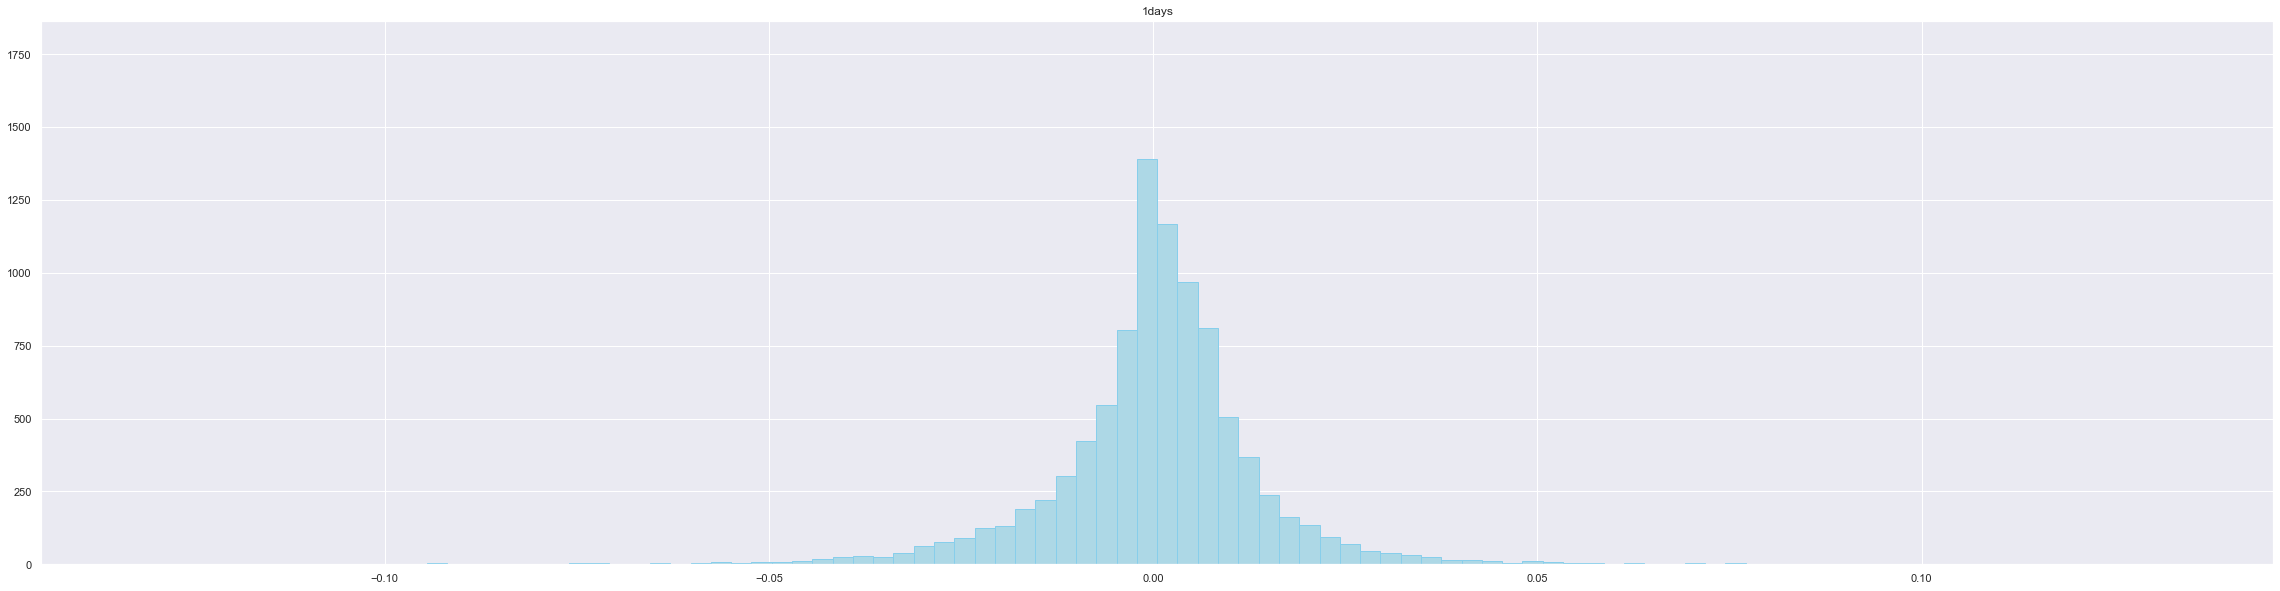

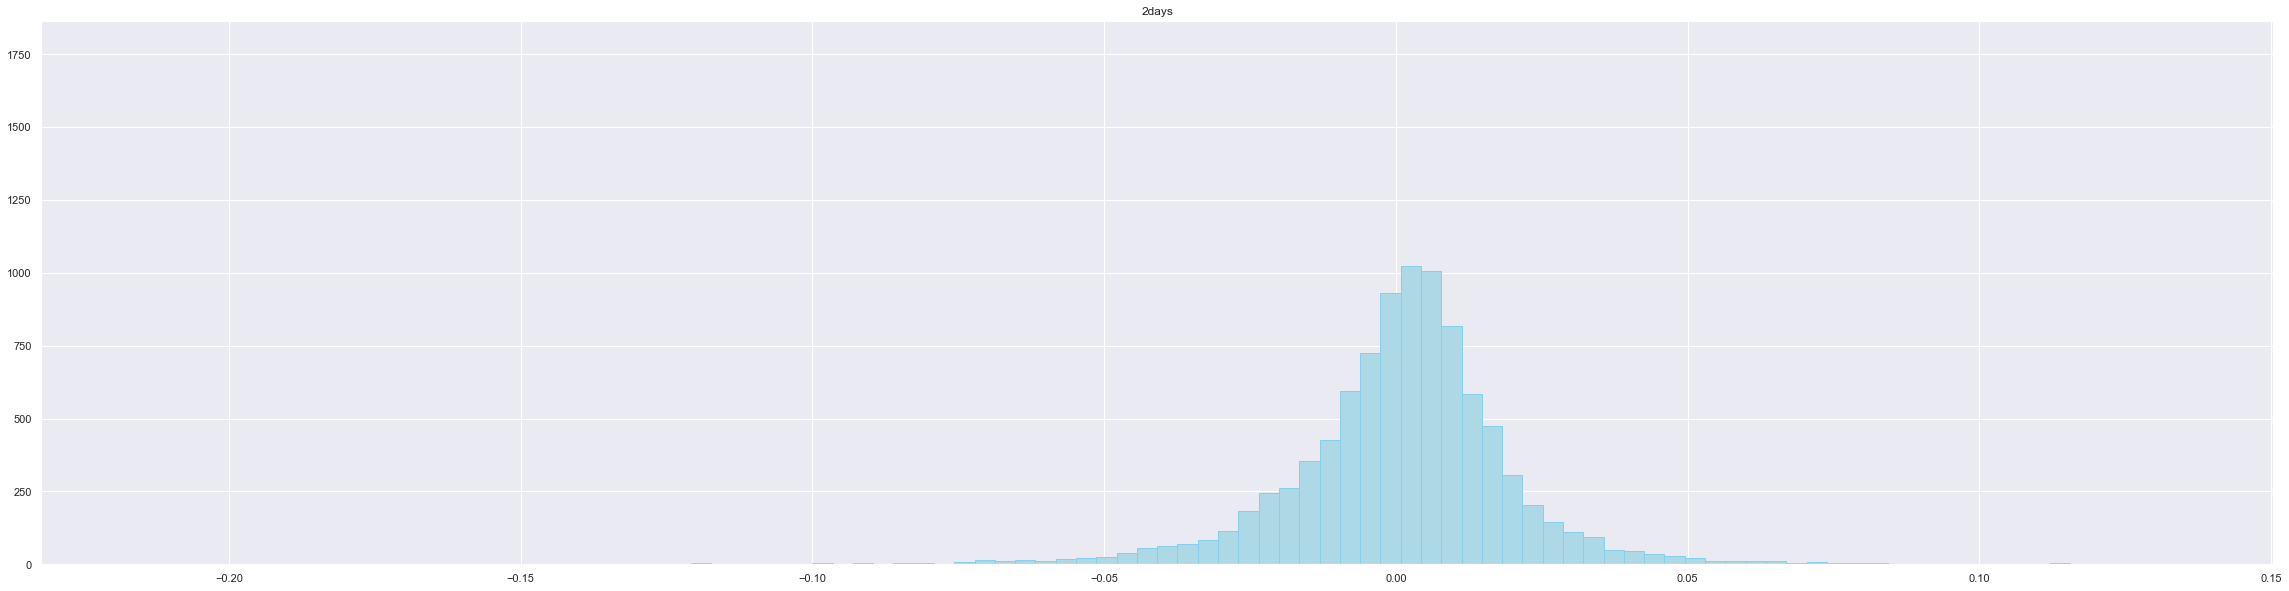

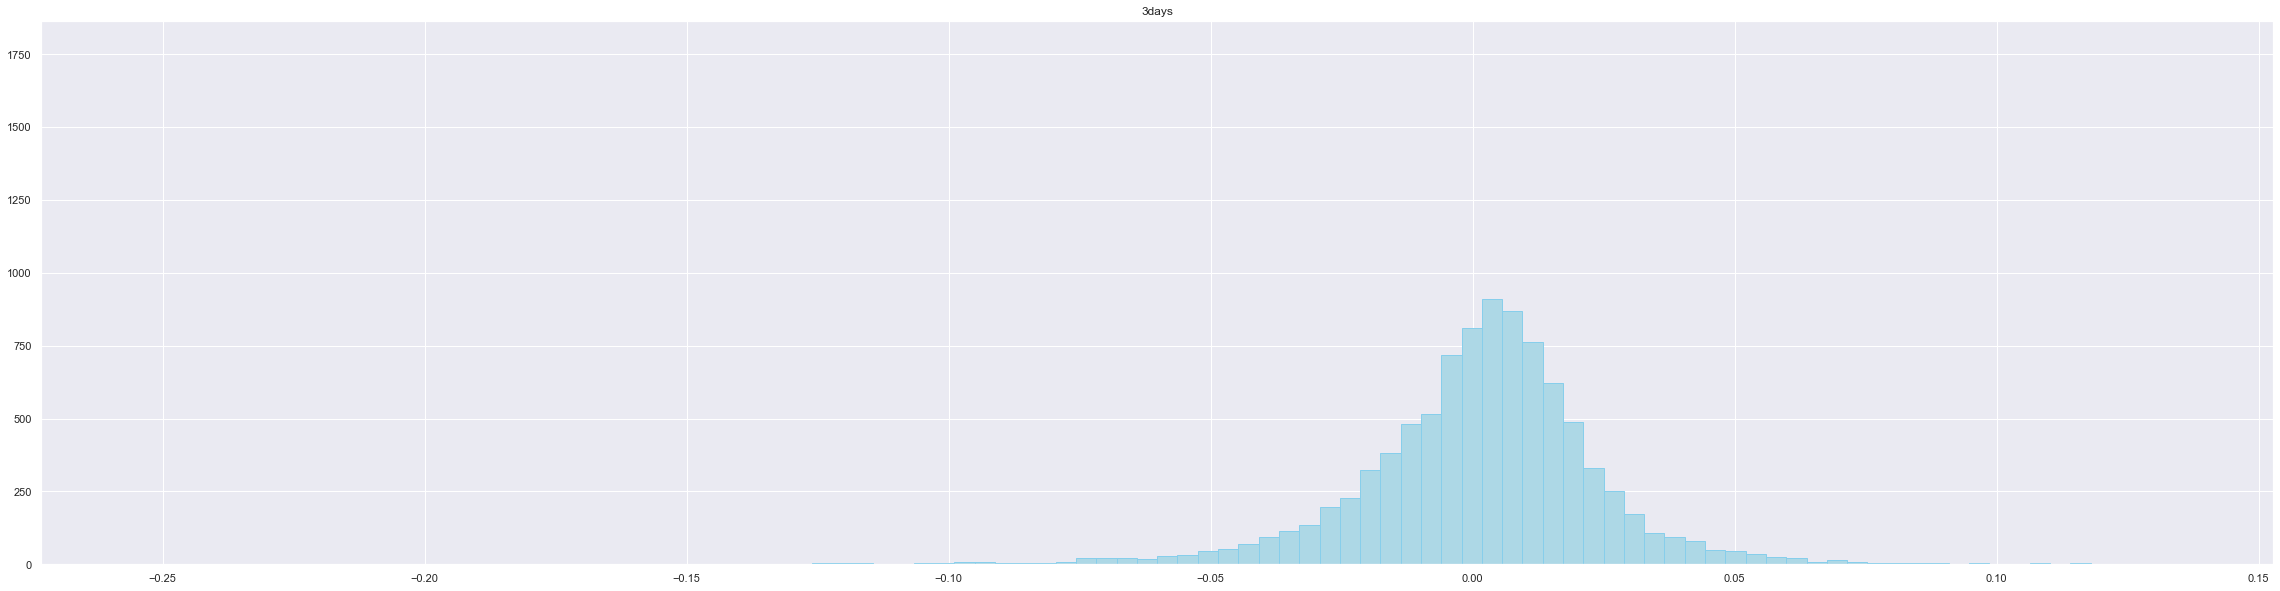

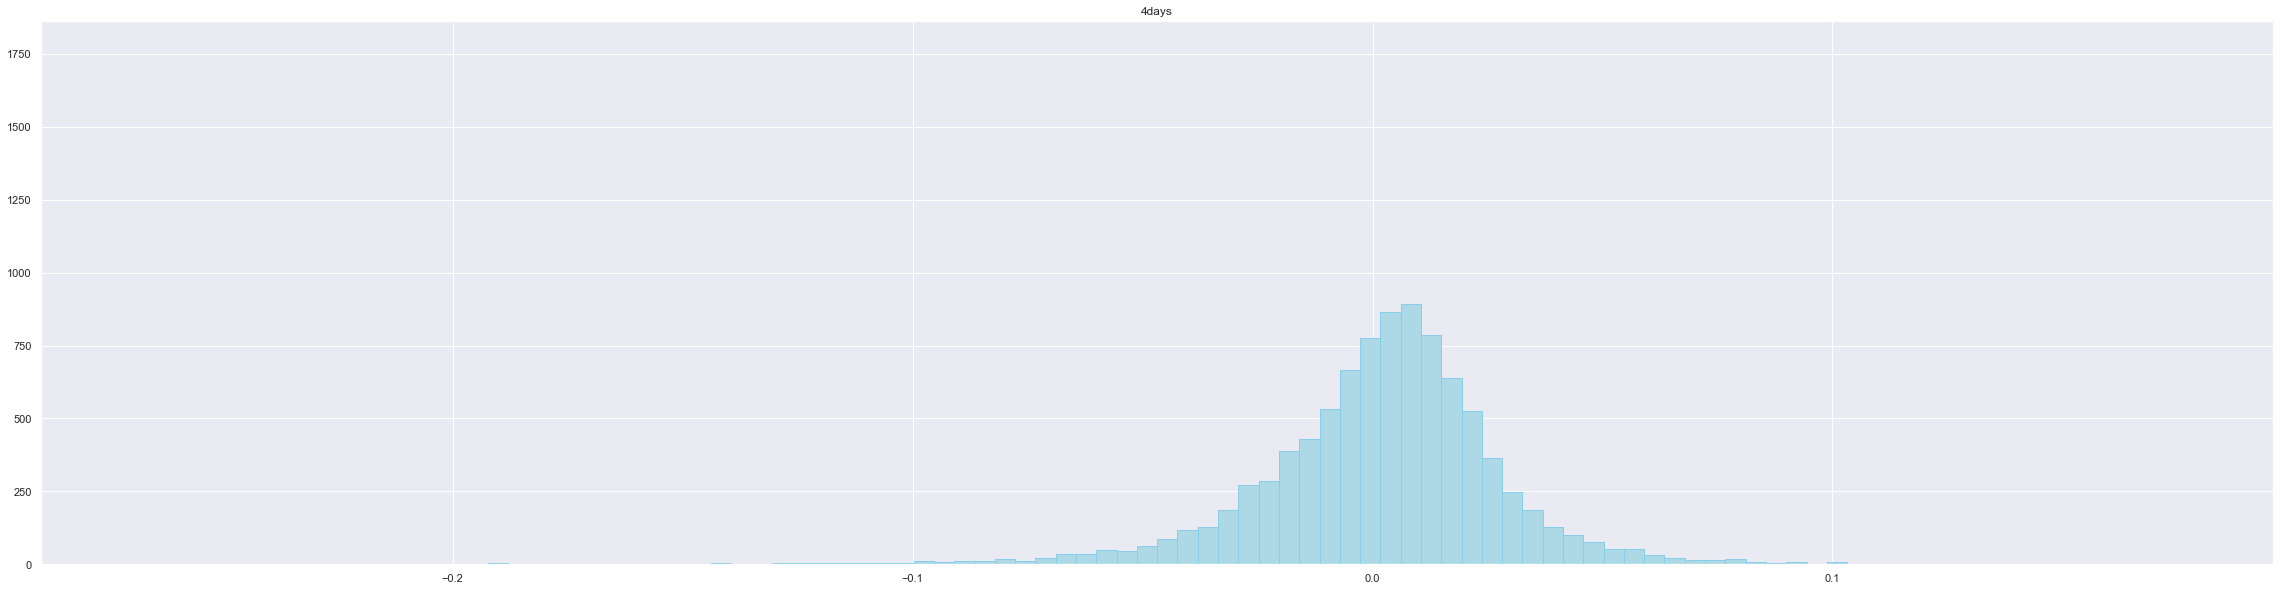

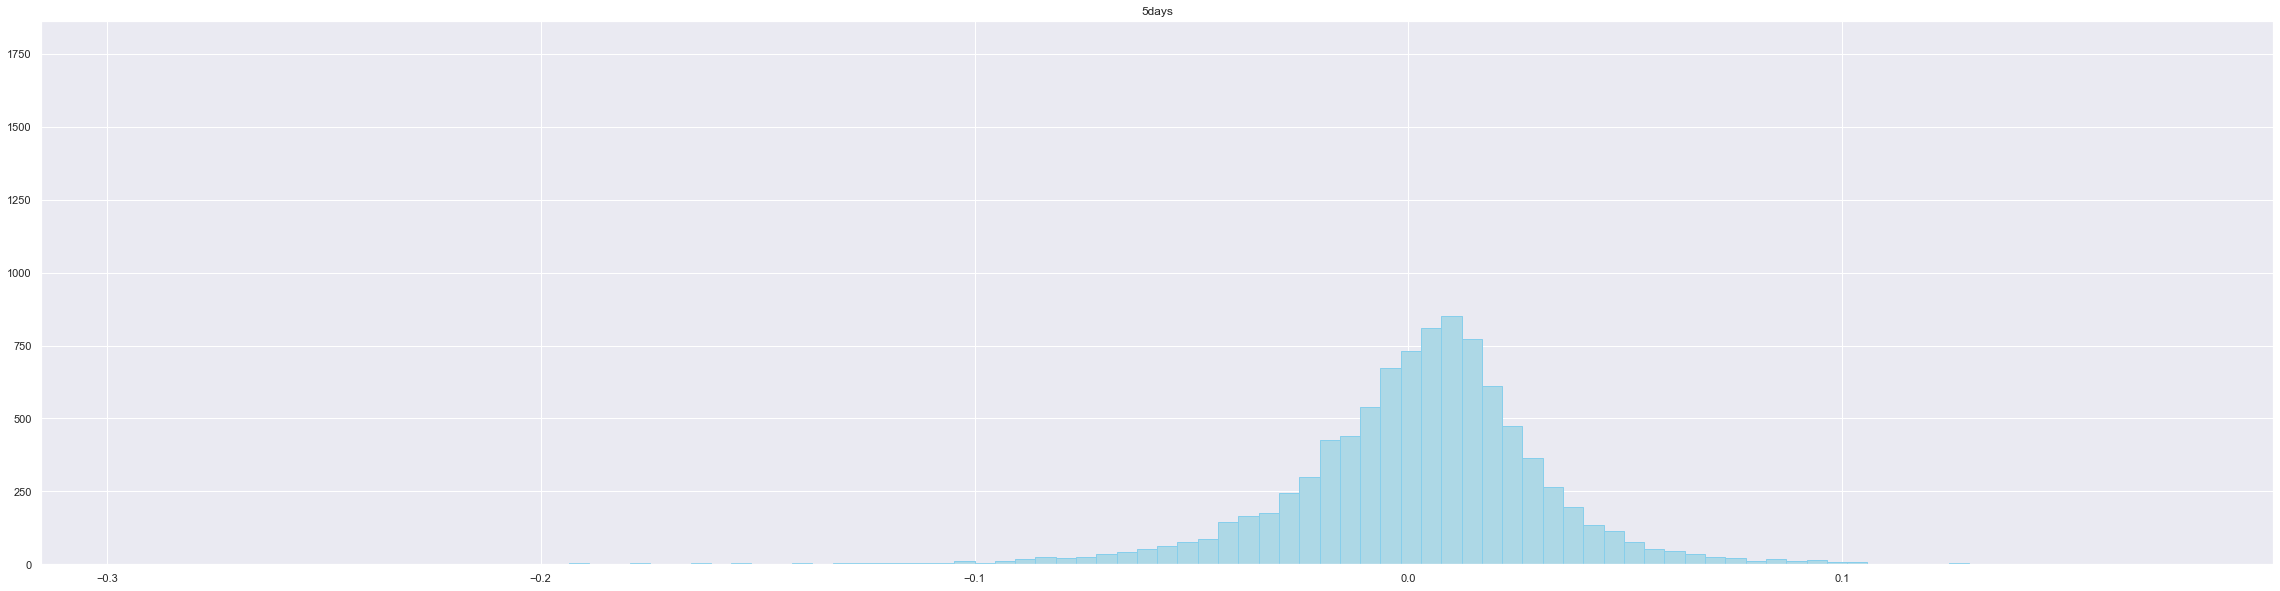

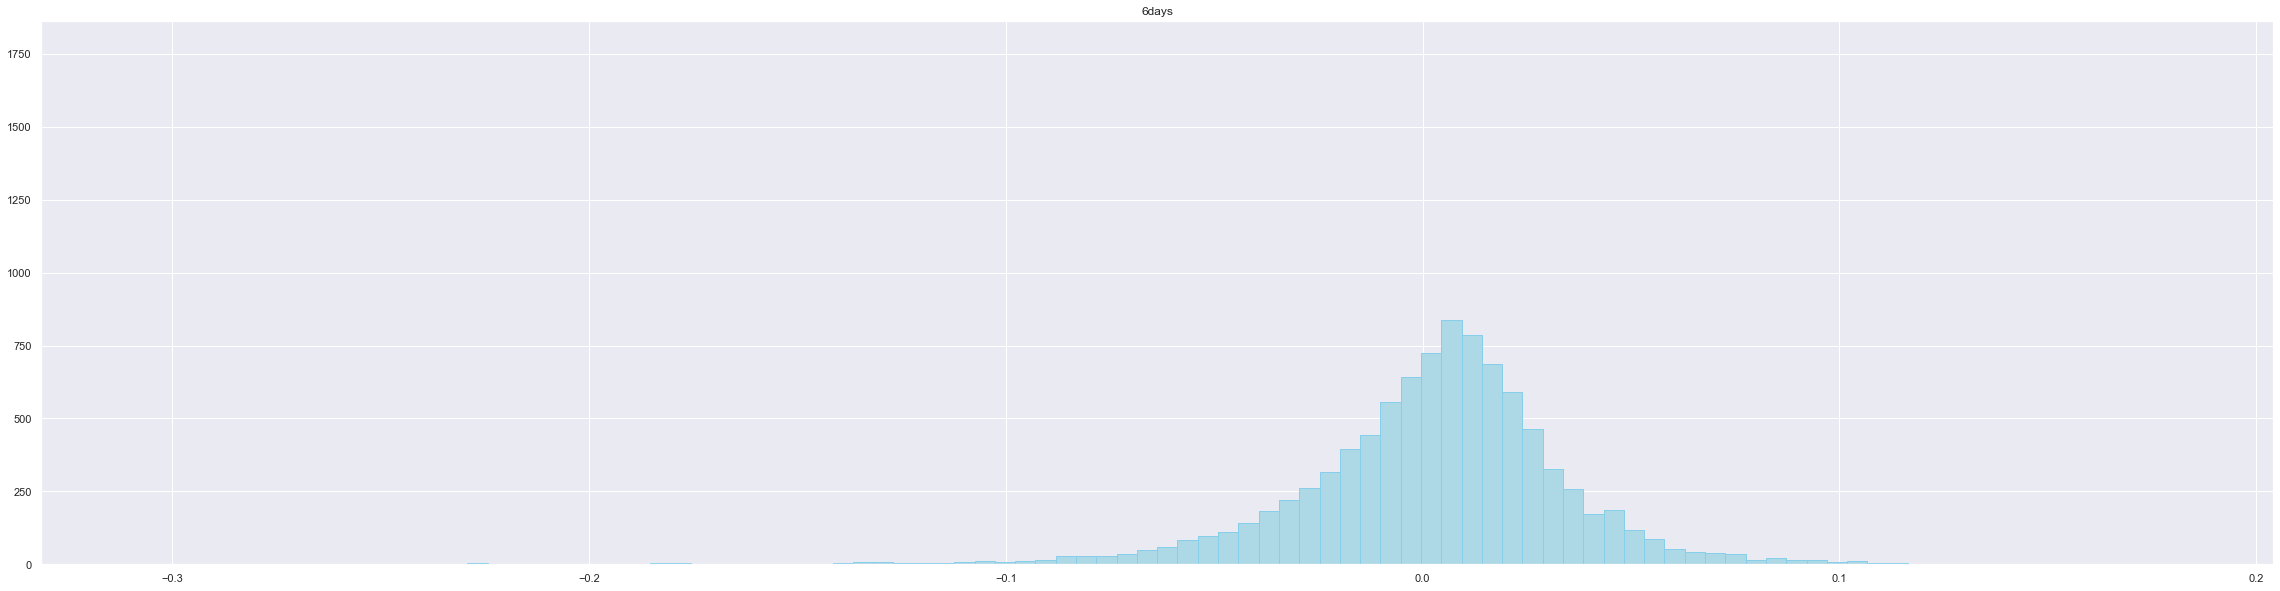

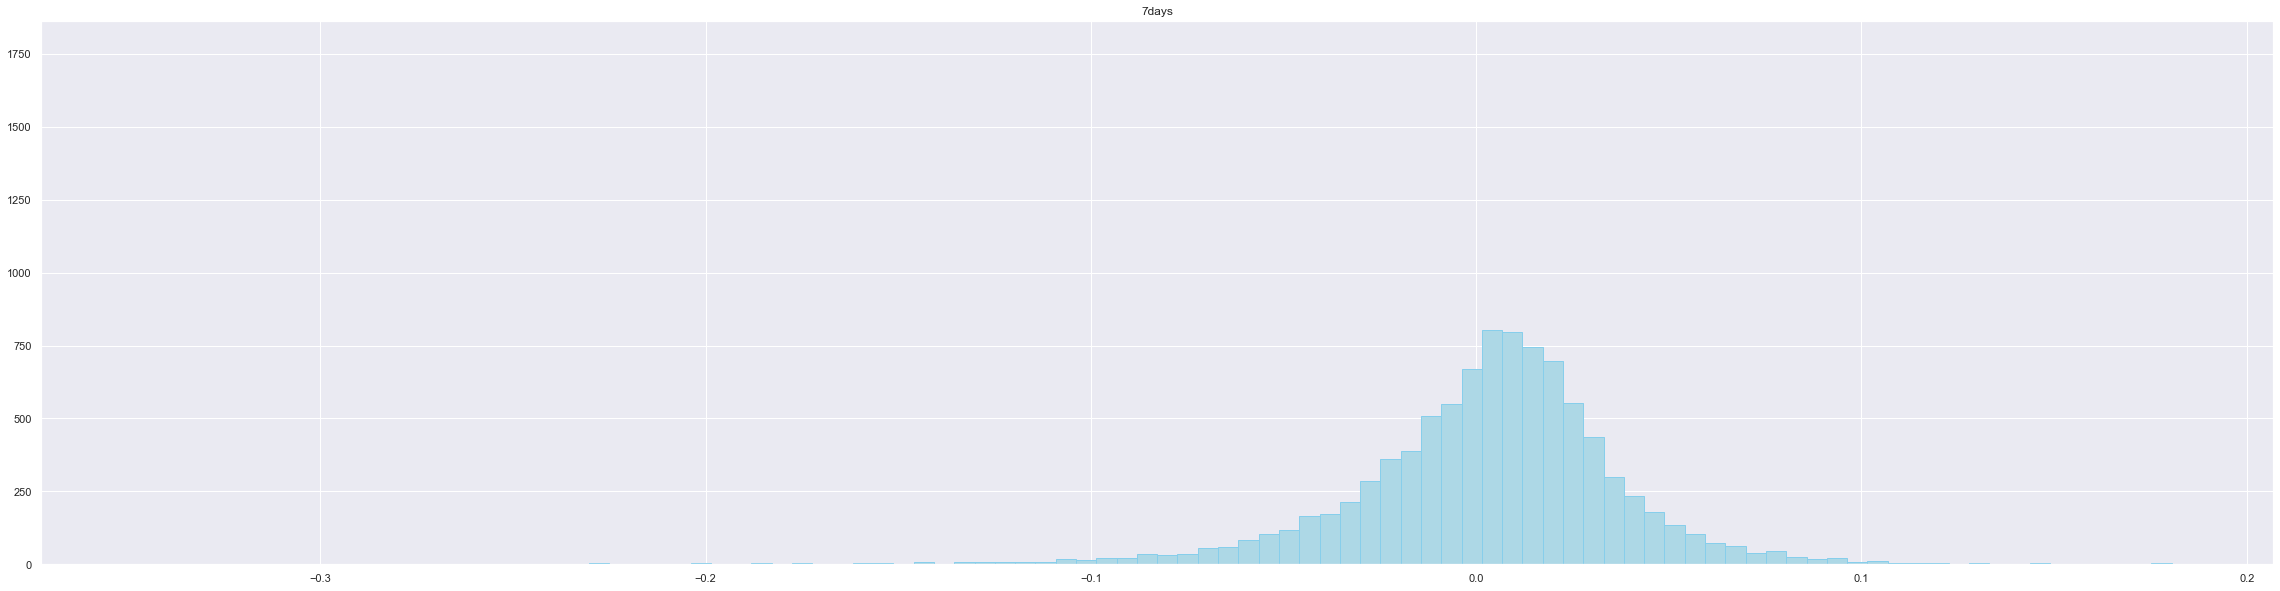

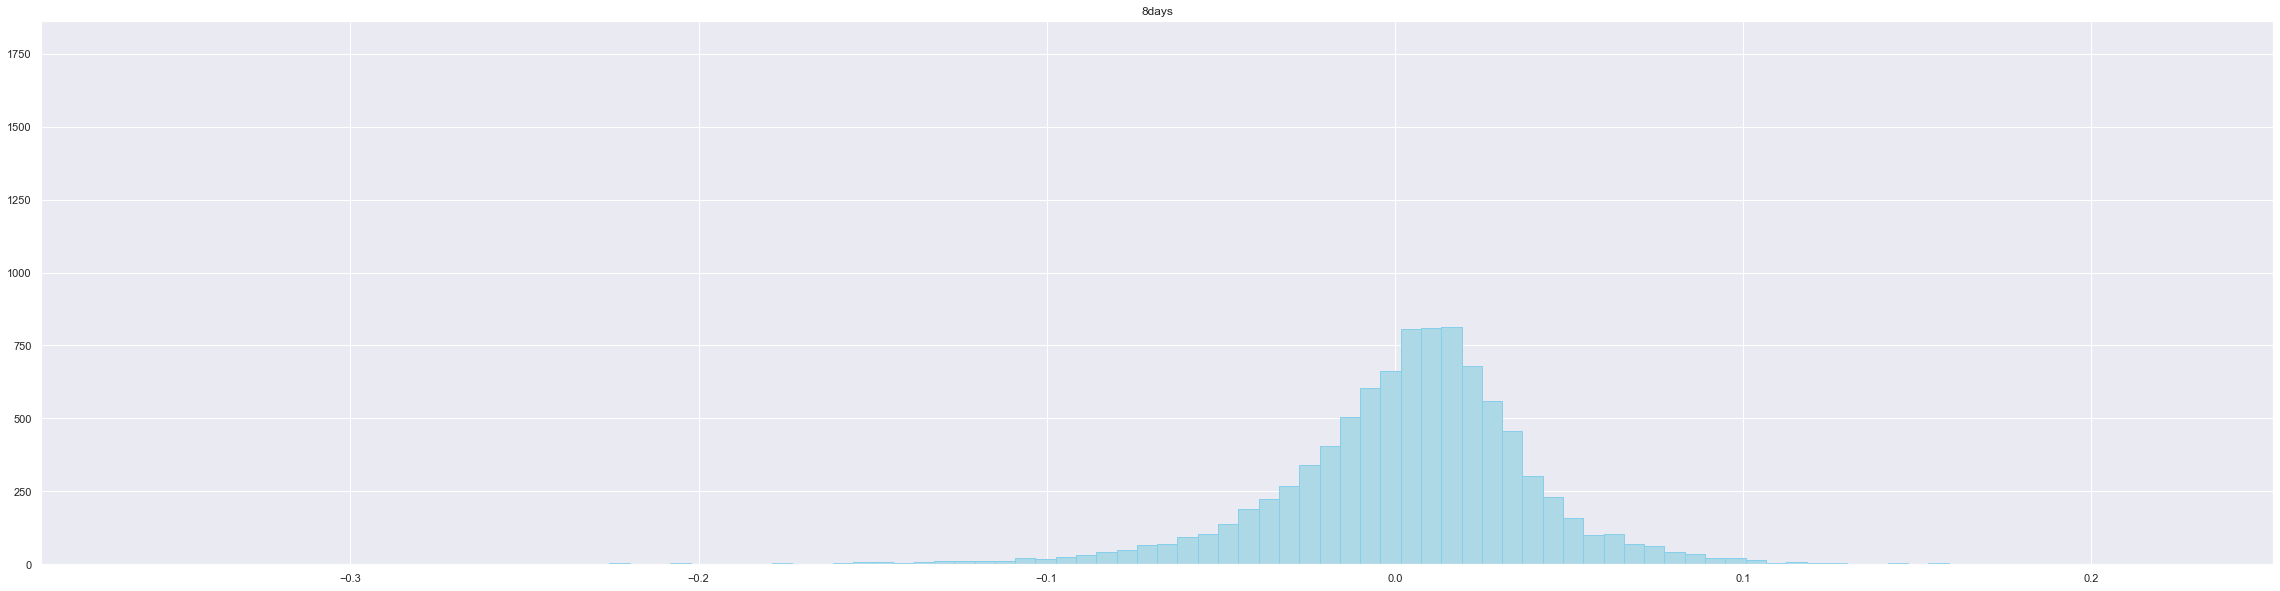

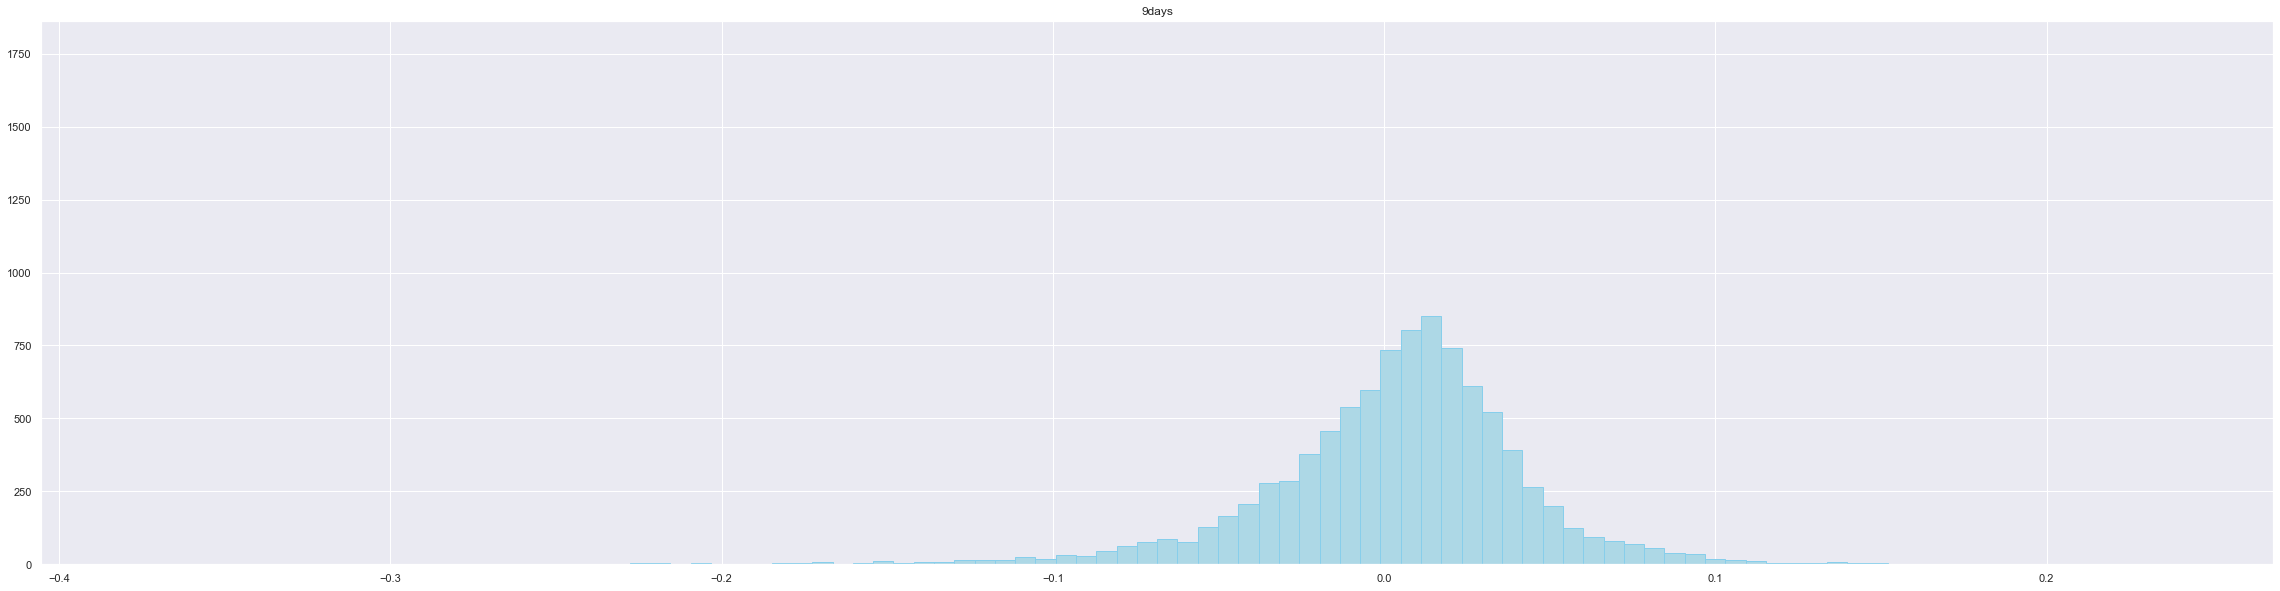

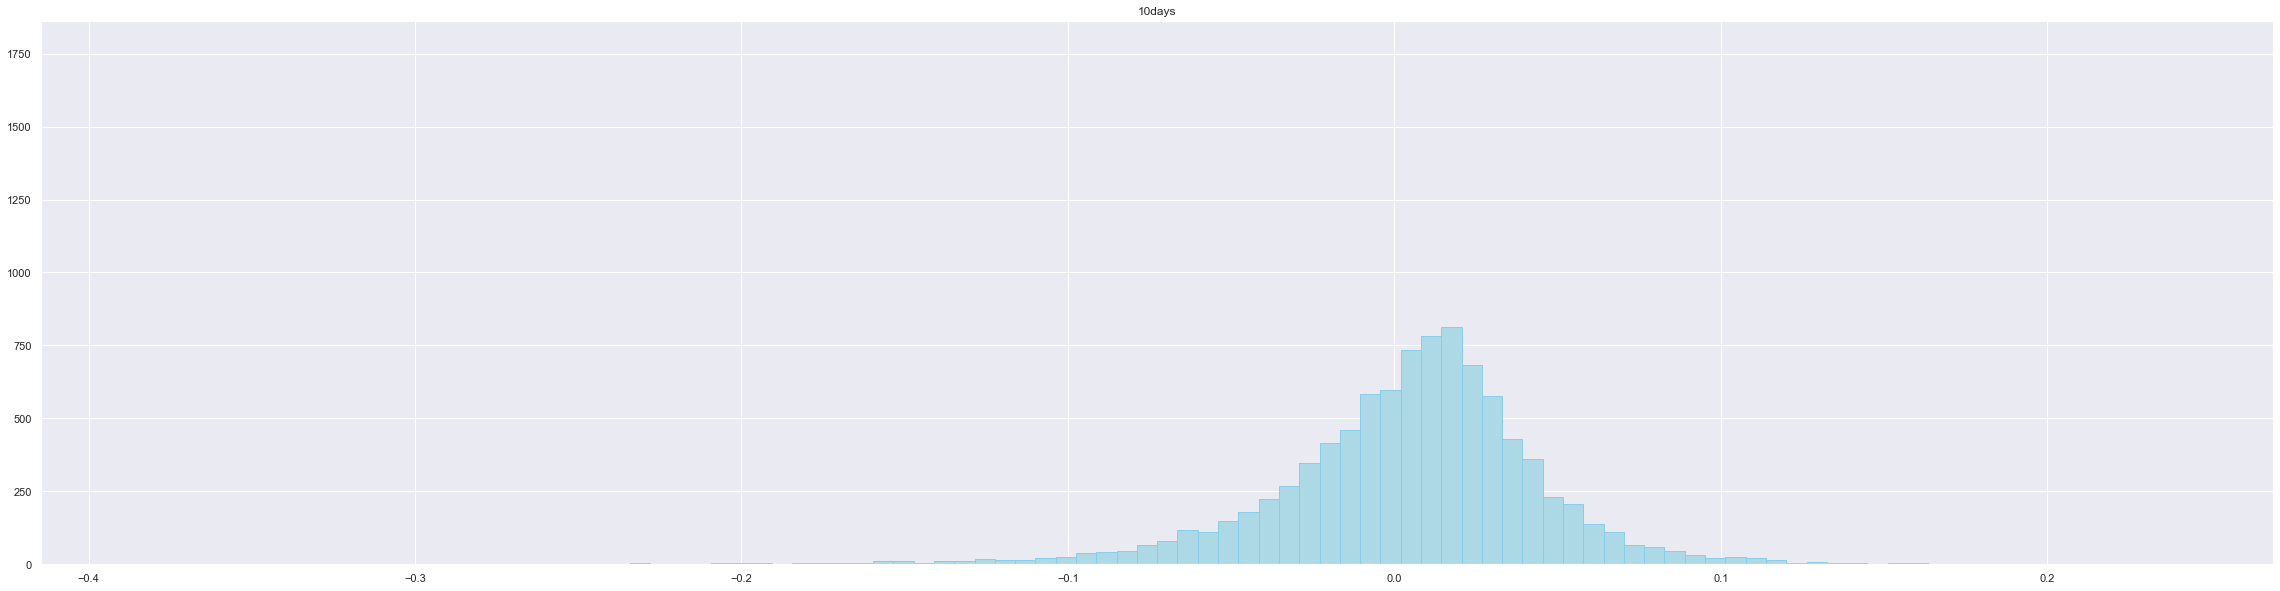

In [25]:
for i in range(1,11): 
    plt.hist(d1[f'CCMP_log_diff_{i}d'], bins=100, color = 'lightblue', ec = 'skyblue')
    plt.ylim((0, d1[f'CCMP_log_diff_{i}d'].count()/5))
    plt.title(f'{i}days')
    plt.show()

In [26]:
# We would need to shift one time step backward 
d1['target'] = d1['CCMP_log_diff_1d'].shift(-1)
d1['target10'] = d1['CCMP_log_diff_10d'].shift(-10)

The first roll of "MSFT_log_diff" would be NA as there would be no value to subtract from, yet we will fill it with zero for simplicity.

In [27]:
d1['CCMP_log_diff_1d'] = d1['CCMP_log_diff_1d'].fillna(0)

In [28]:
d1['CCMP_log_diff_1d'].tail(), d1['target'].tail(), d1['target10'].tail(12)

(2022-03-18    0.020290
 2022-03-21   -0.003994
 2022-03-22    0.019348
 2022-03-23   -0.013287
 2022-03-24    0.000000
 Name: CCMP_log_diff_1d, dtype: float64,
 2022-03-18   -0.003994
 2022-03-21    0.019348
 2022-03-22   -0.013287
 2022-03-23    0.000000
 2022-03-24         NaN
 Name: target, dtype: float64,
 2022-03-09    0.049097
 2022-03-10    0.058617
 2022-03-11         NaN
 2022-03-14         NaN
 2022-03-15         NaN
 2022-03-16         NaN
 2022-03-17         NaN
 2022-03-18         NaN
 2022-03-21         NaN
 2022-03-22         NaN
 2022-03-23         NaN
 2022-03-24         NaN
 Name: target10, dtype: float64)

In [29]:
# Have to drop the last 10 rows as d1['target10'] has no value for the last 10 row.
d1.drop(d1.tail(10).index, inplace = True)

# Have to drop the first row as d1['NVDA_log_diff_1d'] has no value on the first row. 
# If we are to deal with the k-days as d1['NVDA_log_diff_{k}d'] has no value on the first {k} rows. 
# We would have to drop more rows.
# But for NN of 1 day, we should have taken away the first roll.
# We might have to drop all the 10 rows in the front if appropriate.

d1.drop(d1.head(1).index, inplace = True)

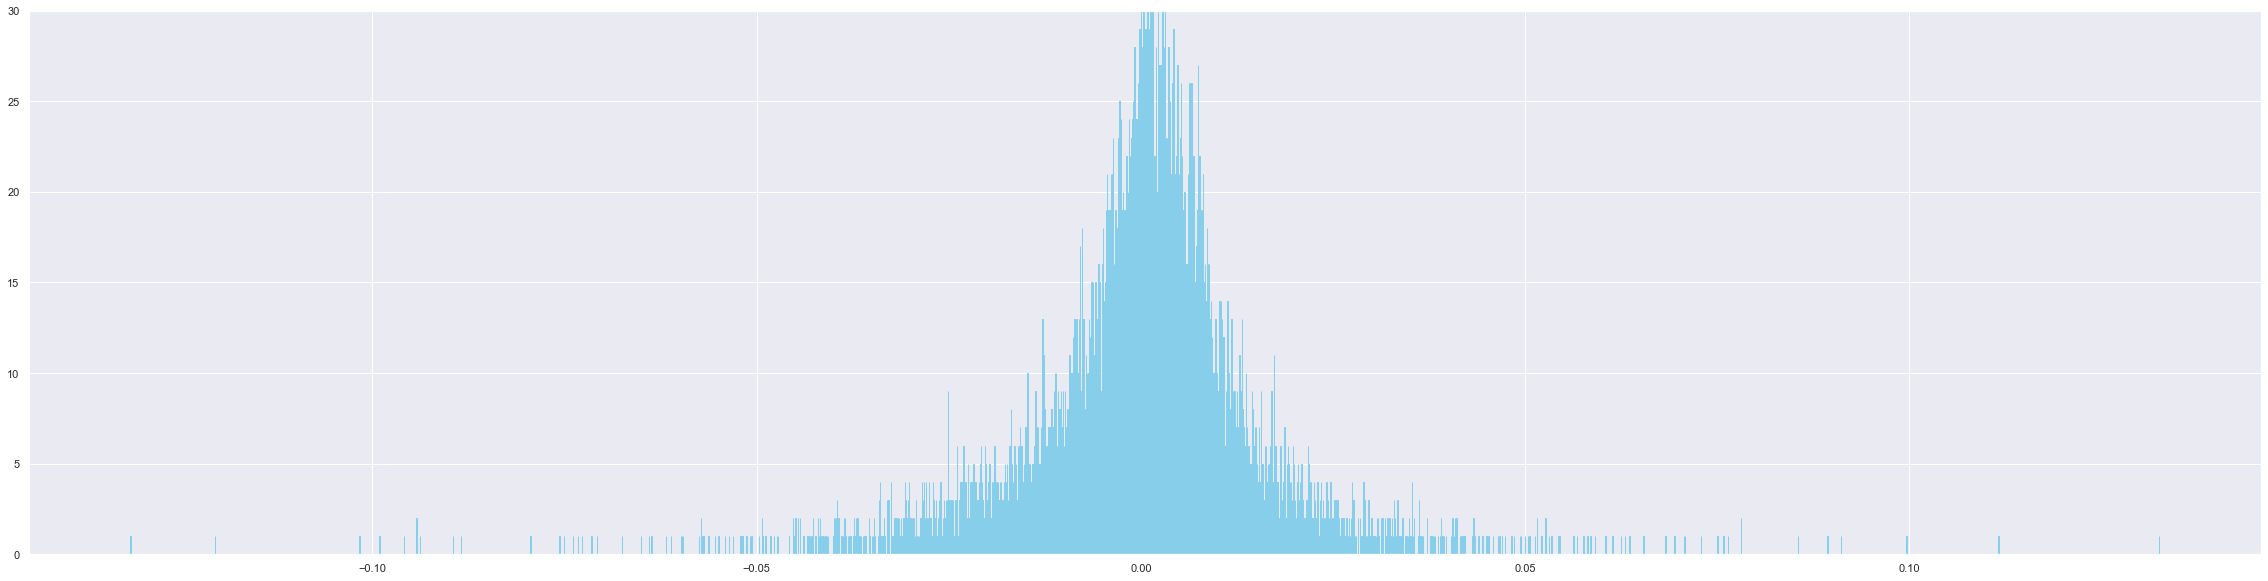

In [30]:
plt.hist(d1['CCMP_log_diff_1d'], bins=5000, color = 'lightblue', ec = 'skyblue')
plt.ylim((0, 30))
plt.show()

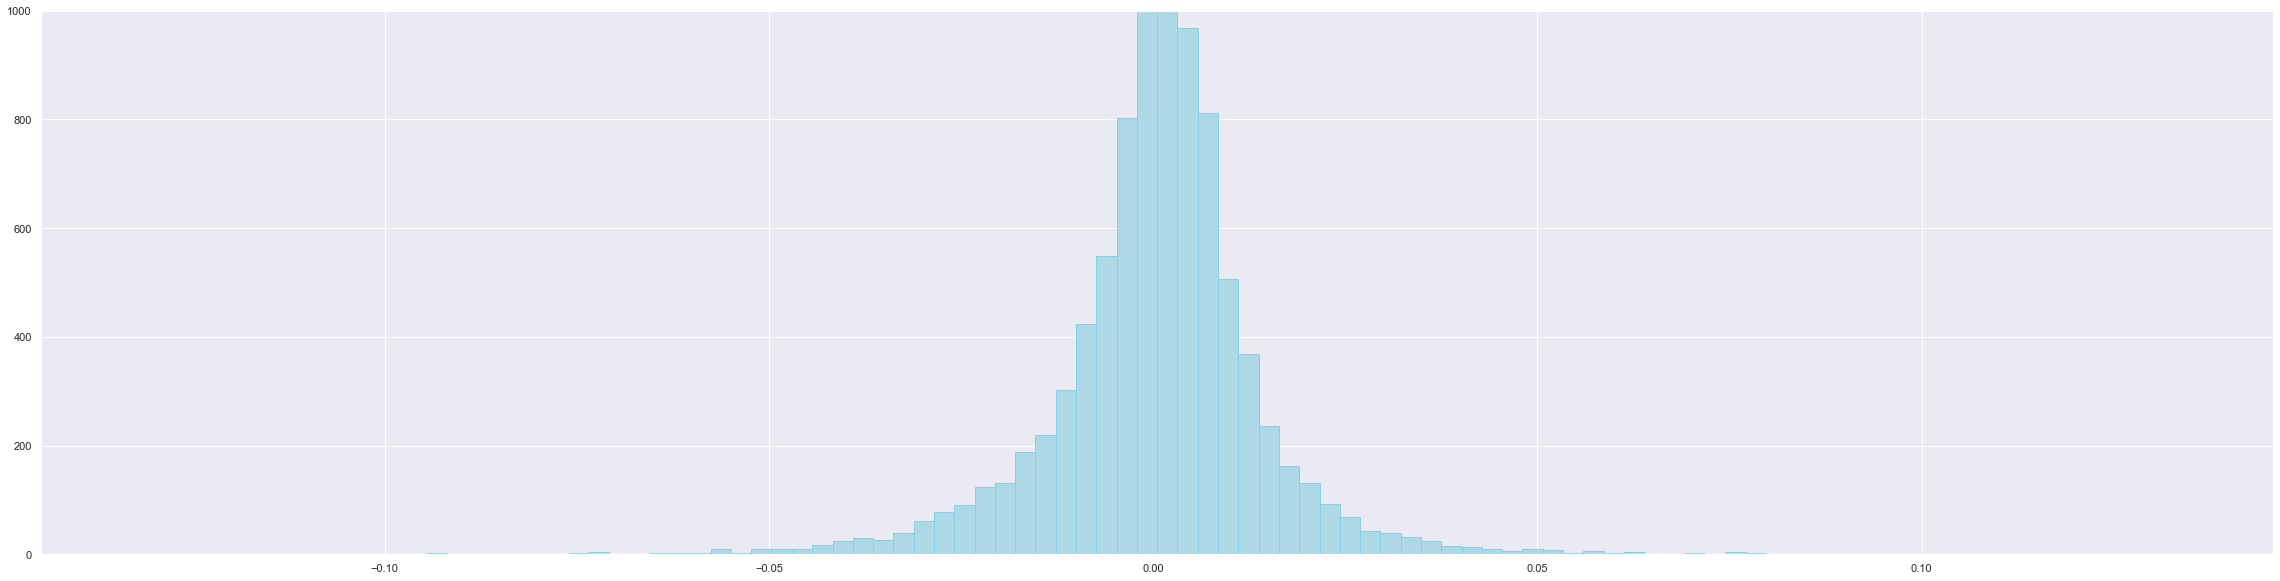

In [31]:
plt.hist(d1['target'], bins=100, color = 'lightblue', ec = 'skyblue')
plt.ylim((0, 1000))
plt.show()

In [32]:
print(list(d1.columns))

[('AAPL US Equity', 'PX_LAST'), ('AAPL US Equity', 'PX_OPEN'), ('AAPL US Equity', 'PX_HIGH'), ('AAPL US Equity', 'PX_LOW'), ('AAPL US Equity', 'PX_VOLUME'), ('AMD US Equity', 'PX_LAST'), ('AMD US Equity', 'PX_OPEN'), ('AMD US Equity', 'PX_HIGH'), ('AMD US Equity', 'PX_LOW'), ('AMD US Equity', 'PX_VOLUME'), ('MSFT US Equity', 'PX_LAST'), ('MSFT US Equity', 'PX_OPEN'), ('MSFT US Equity', 'PX_HIGH'), ('MSFT US Equity', 'PX_LOW'), ('MSFT US Equity', 'PX_VOLUME'), ('AUDJPY Curncy', 'PX_LAST'), ('AUDJPY Curncy', 'PX_OPEN'), ('AUDJPY Curncy', 'PX_HIGH'), ('AUDJPY Curncy', 'PX_LOW'), ('CCMP Index', 'PX_LAST'), ('CCMP Index', 'PX_OPEN'), ('CCMP Index', 'PX_HIGH'), ('CCMP Index', 'PX_LOW'), ('DXY Curncy', 'PX_LAST'), ('DXY Curncy', 'PX_OPEN'), ('DXY Curncy', 'PX_HIGH'), ('DXY Curncy', 'PX_LOW'), ('USGG10YR Index', 'PX_LAST'), ('USGG10YR Index', 'PX_OPEN'), ('USGG10YR Index', 'PX_HIGH'), ('USGG10YR Index', 'PX_LOW'), ('USGG2YR Index', 'PX_LAST'), ('AAPL US Equity', 'RSI_14D'), ('AAPL US Equity', 

In [33]:
# Check the shape of the target10.
d1.target10.shape

(9313,)

In [34]:
#Scale the data by applying standard scaler
SC1 = StandardScaler()
SC2 = StandardScaler()
SC3 = StandardScaler()

d2 = pd.DataFrame()
d2['CCMP_log_PX_LAST'] = d1['CCMP_log_PX_LAST']
d2['AMD_log_PX_LAST'] = d1['AMD_log_PX_LAST']
d2['AUDJPY_log_PX_LAST'] = d1['AUDJPY_log_PX_LAST']
d2['AAPL_log_PX_LAST'] = d1['AAPL_log_PX_LAST']
d2['MSFT_log_PX_LAST'] = d1['MSFT_log_PX_LAST']
d2['USGG10YR_log_PX_LAST'] = d1['USGG10YR_log_PX_LAST']
d2['USGG2YR_log_PX_LAST'] = d1['USGG2YR_log_PX_LAST']
d2['CCMP_log_diff'] = d1['CCMP_log_diff_1d']
d2['AMD_log_diff'] = d1['AMD_log_diff']
d2['MSFT_log_diff'] = d1['MSFT_log_diff']
d2['AAPL_log_diff'] = d1['AAPL_log_diff']
d2['USGG10YR_log_diff'] = d1['USGG10YR_log_diff']
d2['USGG2YR_log_diff'] = d1['USGG2YR_log_diff']
d2['AUDJPY_log_diff'] = d1['AUDJPY_log_diff']

new_d1 = d2
# new_d1 = np.array(d2).reshape(-1,1)
# target = np.array(d1['NVDA_log_diff']).reshape(-1,1)

# Have to convert the dataframe that we are dealing with to numpy array.
new_d1 = np.array(new_d1)

train_days = int(new_d1.shape[0]/10)

# Validation set and Test set are set to be the 10% of the total dataset
new_d1[:-train_days] = SC1.fit_transform(new_d1[:-train_days])
new_d1[-train_days:] = SC1.transform(new_d1[-train_days:])

target = np.array(d1[('target')])
target = target.reshape(-1,1)
target[:-train_days] = SC2.fit_transform(target[:-train_days])
target[-train_days:] = SC2.transform(target[-train_days:])

target10 = np.array(d1[('target10')])
target10 = target10.reshape(-1,1)
target10[:-train_days] = SC3.fit_transform(target10[:-train_days])
target10[-train_days:] = SC3.transform(target10[-train_days:])

### Check the scaled value of est_mu1

In [35]:
# This is the mean of the scaled "target" of the training set.
# So we would likely have $\mu_1$ constrained to hover around this value... 
SC2.transform(np.array(np.mean(target[:-train_days])).reshape(-1,1))

array([[-0.02565305]])

In [36]:
# Check if the shape of target complies the shape of the feature in terms of number of time steps.
new_d1.shape, target.shape

((9313, 14), (9313, 1))

In [37]:
# Store the values into d_r

d2['CCMP_log_diff'] = d1['CCMP_log_diff_1d']
d2['AMD_log_diff'] = d1['AMD_log_diff']
d2['MSFT_log_diff'] = d1['MSFT_log_diff']
d2['AAPL_log_diff'] = d1['AAPL_log_diff']
d2['USGG10YR_log_diff'] = d1['USGG10YR_log_diff']
d2['USGG2YR_log_diff'] = d1['USGG2YR_log_diff']
d2['AUDJPY_log_diff'] = d1['AUDJPY_log_diff']
d_r = d2
d_r['target'] = d1['target']
d_r['target10'] = d1['target10']

In [38]:
d_r.shape

(9313, 16)

In [39]:
new_d1

array([[-1.63136156e+00,  2.58017663e-01,  1.54602135e+00, ...,
         2.37855284e-01, -1.07578964e-03, -2.62095367e+00],
       [-1.62594138e+00,  2.58017663e-01,  1.53122995e+00, ...,
         8.37802629e-02,  3.61332611e-03, -2.37915381e-01],
       [-1.62109299e+00,  2.20951048e-01,  1.20406908e+00, ...,
        -6.09660228e-01, -4.78351747e-01, -5.34642496e+00],
       ...,
       [ 2.44989746e+00,  3.70875674e+00, -3.46858220e-02, ...,
         2.50929727e+00,  9.79610577e-01, -3.35460431e-01],
       [ 2.49172069e+00,  3.78341096e+00,  1.92268720e-02, ...,
         3.55693825e+00,  1.57461253e+00,  8.85675604e-01],
       [ 2.48044784e+00,  3.72160398e+00,  6.61347309e-02, ...,
         1.06711294e+00,  3.13936202e-01,  7.71118099e-01]])

In [40]:
d_r.shape, new_d1.shape

((9313, 16), (9313, 14))

The first 14 columns of the features would be the features for us to predict the target. All data are stored in the DataFrame d_r nice and neatly.

In [41]:
print(list(d_r.columns))

['CCMP_log_PX_LAST', 'AMD_log_PX_LAST', 'AUDJPY_log_PX_LAST', 'AAPL_log_PX_LAST', 'MSFT_log_PX_LAST', 'USGG10YR_log_PX_LAST', 'USGG2YR_log_PX_LAST', 'CCMP_log_diff', 'AMD_log_diff', 'MSFT_log_diff', 'AAPL_log_diff', 'USGG10YR_log_diff', 'USGG2YR_log_diff', 'AUDJPY_log_diff', 'target', 'target10']


In [42]:
trainX = []
trainY = []
var_trainY = []

n_future = 1
n_past = 45

for i in range(n_past,d_r.shape[0]-n_future+1):
    trainX.append(new_d1[i-n_past:i,0:new_d1.shape[1]])
    trainY.append(target[i-1,0])
    var_trainY.append(target10[i-n_past:i-1].var()) # This calculate the past 44 days variance.

In [43]:
trainX,trainY, var_trainY = np.array(trainX),np.array(trainY), np.array(var_trainY)

In [44]:
trainX.shape, trainY.shape, var_trainY.shape

((9268, 45, 14), (9268,), (9268,))

In [45]:
import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential 
from keras.layers import Activation, Dense, LSTM, Dropout, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.optimizers import adam_v2 # not sure if this is the same
from keras.metrics import categorical_crossentropy, BinaryAccuracy, CategoricalAccuracy, Precision, Recall
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy, MeanSquaredError

In [46]:
!python --version
import keras; 
print("")
print('Keras version',keras.__version__)

Python 3.9.12

Keras version 2.9.0


In [47]:
n_val = int(trainY.shape[0] - trainY[:-train_days].shape[0])
n_rtest = int(n_val/2)
print('Training_Set =', trainX.shape[0]-n_val)
print('Validation_Set =',n_val - n_rtest)
print("Test_Set = ", n_rtest)
X_train, Y_train, varY_train = trainX[:-n_val], trainY[:-n_val], var_trainY[:-n_val]
Y_train = Y_train.reshape(-1,1)
varY_train = varY_train.reshape(-1,1)
X_val, Y_val, varY_val = trainX[-n_val:-n_rtest], trainY[-n_val:-n_rtest], var_trainY[-n_val:-n_rtest]
Y_val = Y_val.reshape(-1,1)
varY_val = varY_val.reshape(-1,1)
X_rtest, Y_rtest, varY_rtest = trainX[-n_rtest:], trainY[-n_rtest:], var_trainY[-n_rtest:]
Y_rtest = Y_rtest.reshape(-1,1)
varY_rtest = varY_rtest.reshape(-1,1)
print('X_val shape:',X_val.shape)
print('X_rtest shape:',X_rtest.shape)
print('Y_val shape:',Y_val.reshape(-1,1).shape)
print('varY_val shape:',varY_val.reshape(-1,1).shape)
print('Y_rtest shape:',Y_rtest.reshape(-1,1).shape)
print('varY_rtest shape:',varY_rtest.reshape(-1,1).shape)


Training_Set = 8337
Validation_Set = 466
Test_Set =  465
X_val shape: (466, 45, 14)
X_rtest shape: (465, 45, 14)
Y_val shape: (466, 1)
varY_val shape: (466, 1)
Y_rtest shape: (465, 1)
varY_rtest shape: (465, 1)


# MODEL 4 - TWO GAUSSIAN MIXTURE MODEL for CCMP

In [48]:
class layer(tf.keras.layers.Layer):
    def __init__(self):
        super(layer, self).__init__()
        
        
    def Normal_Dist_Layer_2(x):
        """
        Lambda function for generating Normal Distribution parameters
        mu and sigma2 from a Dense(2) output.
        Assumes tensorflow 2 backend.

        Usage
        -----
        outputs = Dense(4)(final_layer)
        distribution_outputs = Lambda(Normal_Dist_Layer_2)(outputs)

        Parameters
        ----------
        x : tf.Tensor
            output tensor of Dense layer

        Returns
        -------
        out_tensor : tf.Tensor

        """

        # Get the number of dimensions of the input
        num_dims = len(x.get_shape())

        # Separate the parameters
        mu1,sigma2_1,mu2,sigma2_2, w1 = tf.unstack(x, num=5, axis=-1)

        # Add one dimension to make the right shape
        mu1 = tf.expand_dims(mu1, -1)
        sigma2_1 = tf.expand_dims(sigma2_1, -1)
        mu2 = tf.expand_dims(mu2, -1)
        sigma2_2 = tf.expand_dims(sigma2_2, -1)    
        w1 = tf.expand_dims(w1, -1)

        # Apply a softplus to make variance 1 and variance 2 both positive
        # But other than that, there are no other restrictions
        sigma2_1 = tf.keras.activations.softplus(sigma2_1)
        sigma2_2 = tf.keras.activations.softplus(sigma2_2)

        # We restrict mu1 to be very close to the simple mean return of the whole training period. 
        # We aim to find the 2nd component, which could explain the abnormal log return.
        # Would it make more sense to convert this to a more dynamic process?
        # May be exponentially weighted? Consider the mean return of the window that we are observing?

        mu1 = -0.02565305+0.002565305*tf.keras.activations.sigmoid(mu1)*1.2
        w1 = 0.8+0.2*tf.keras.activations.sigmoid(w1)

        # Join back together again
        out_tensor = tf.stack((mu1,sigma2_1,mu2,sigma2_2, w1), axis=num_dims-1)

        return out_tensor
    
    def negative_log_likelihood_loss_2(y_true,y_pred):
        """
        Negative log-likelihood loss function.
        Assumes tensorflow backend.

        Parameters
        ----------
        y_true : tf.Tensor
            Ground truth values of predicted variable.
        y_pred : tf.Tensor
            mu and sigma2 values of predicted distribution.

        Returns
        -------
        nll : tf.Tensor
            Negative log likelihood.
        """

        # Separate the parameters
        mu1, sigma2_1, mu2, sigma2_2, w1 = tf.unstack(y_pred, num=5, axis=-1)

        # Add one dimension to make the right shape
        mu1 = tf.expand_dims(mu1, -1)
        sigma2_1 = tf.expand_dims(sigma2_1, -1)
        mu2 = tf.expand_dims(mu2, -1)
        sigma2_2 = tf.expand_dims(sigma2_2, -1)
        w1 = tf.expand_dims(w1, -1)

        # Calculate the negative log likelihood
        nll = (-tf.math.log(w1)
               +0.5*(tf.math.log(sigma2_1)
                     +tf.math.square(y_true-mu1)/sigma2_1)
               -tf.math.log(1-w1)
               +0.5*(tf.math.log(sigma2_2)
                     +tf.math.square(y_true-mu2)/sigma2_2)
              )-tf.math.log(sigma2_2/sigma2_1)+k*sigma2_2

        return tf.reduce_mean(nll)

In [49]:
import tensorflow as tf
import tensorflow_probability as tfp

In [54]:
# Best val_loss So Far: 3.230719486872355
# Total elapsed time: 06h 40m 27s

# Search: Running Trial #23

# Value             |Best Value So Far |Hyperparameter
# 8                 |24                |Input_Layer_LSTM_unit
# 0                 |0.4               |Dropout_1
# 3                 |1                 |n_layers
# 8                 |24                |LSTM_0_units
# 0.2               |0.4               |Dropout_0
# 24                |32                |Final_Lstm_layer
# 40                |40                |Final_Dense
# 16                |16                |LSTM_1_units
# 8                 |32                |LSTM_2_units
# 0.2               |0                 |Dropout_2


# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(hp.Int('Input_Layer_LSTM_unit',min_value=8,max_value=32,step=8),
#                    return_sequences=True, 
#                    input_shape=(X_train.shape[1],X_train.shape[2]),
#                   ))
#     model.add(Dropout(hp.Float('Dropout_1',min_value=0,max_value=0.5,step=0.1)))
#     for i in range(hp.Int('n_layers', 1, 3)):
#         model.add(LSTM(hp.Int(f'LSTM_{i}_units',min_value=8,max_value=32,step=8),kernel_initializer=glorot_uniform(),
#                        return_sequences=True))
#         model.add(Dropout(hp.Float(f'Dropout_{i}',min_value=0,max_value=0.5,step=0.1)))
    
#     model.add(LSTM(hp.Int('Final_Lstm_layer',min_value=8,max_value=32,step=8)))
#     model.add(Dense(hp.Int('Final_Dense',min_value=16,max_value=64,step=8), activation='relu'))
#     model.add(Dense(5))
#     model.add(Lambda(Normal_Dist_Layer_2))

#     model.compile(loss = negative_log_likelihood_loss_2, 
#                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
#                    )
#     return model

# TRAINING OF MODEL

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 45, 24)       3744        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 45, 24)       0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 45, 16)       2624        ['dropout[0][0]']                
                                                                                              

Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3459
Epoch 31: val_loss did not improve from 1.54528

Epoch 31: ReduceLROnPlateau reducing learning rate to 8.097277706838213e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.3443 - val_loss: 1.9220 - lr: 8.1791e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3498
Epoch 32: val_loss did not improve from 1.54528

Epoch 32: ReduceLROnPlateau reducing learning rate to 8.01630511705298e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.3488 - val_loss: 1.8346 - lr: 8.0973e-05
Epoch 33/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3384
Epoch 33: val_loss did not improve from 1.54528

Epoch 33: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.3385 - val_loss: 1.8760 - lr: 8.0163e-05
Epoch 34/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3

66/66 [==============================] - 2s 38ms/step - loss: 0.2859 - val_loss: 1.6507 - lr: 6.2982e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2860
Epoch 58: val_loss did not improve from 1.54528

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.17289941146737e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.2860 - val_loss: 1.8782 - lr: 6.2353e-05
Epoch 59/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2922
Epoch 59: val_loss did not improve from 1.54528

Epoch 59: ReduceLROnPlateau reducing learning rate to 6.111170165240765e-05.
66/66 [==============================] - 2s 38ms/step - loss: 0.2946 - val_loss: 1.7506 - lr: 6.1729e-05
Epoch 60/1000
66/66 [==============================] - ETA: 0s - loss: 0.2916
Epoch 60: val_loss did not improve from 1.54528

Epoch 60: ReduceLROnPlateau reducing learning rate to 6.0500582330860196e-05.
66/66 [==============================] - 2s 38ms/step - loss: 0.2916 - va

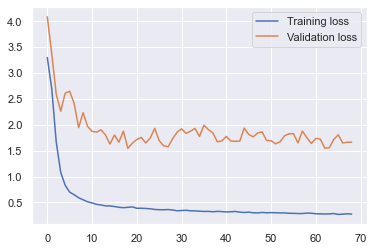

<Figure size 432x288 with 0 Axes>





Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 45, 24)       3744        ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 45, 24)       0           ['lstm_3[0][0]']                 
                                                                                                  
 lstm_4 (LSTM)                  (None, 45, 16)       2624        ['dropout_2[0][0]']              
                                                                                        

66/66 [==============================] - 2s 38ms/step - loss: 1.2076 - val_loss: 2.5869 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9939
Epoch 5: val_loss improved from 2.58688 to 2.57049, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.06.hdf5
66/66 [==============================] - 2s 38ms/step - loss: 0.9934 - val_loss: 2.5705 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8188
Epoch 6: val_loss improved from 2.57049 to 2.46208, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.06.hdf5
66/66 [==============================] - 2s 37ms/step - loss: 0.8214 - val_loss: 2.4621 - lr: 1.0000e-04
Epoch 7/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7461
Epoch 7: val_loss improved from 2.46208 to 2.40096, saving model to C:\Users\Alex Lam\OneDrive\Documents\Dem

Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4533
Epoch 30: val_loss did not improve from 1.99702

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.429430854448584e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.4511 - val_loss: 2.1555 - lr: 8.5146e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4399
Epoch 31: val_loss improved from 1.99702 to 1.96547, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.06.hdf5
66/66 [==============================] - 2s 38ms/step - loss: 0.4408 - val_loss: 1.9655 - lr: 8.4294e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4651
Epoch 32: val_loss did not improve from 1.96547

Epoch 32: ReduceLROnPlateau reducing learning rate to 8.345136870048008e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.4630 - val_loss: 2.0282 - lr: 8.4294e-05
Epoch 33/1000
65/66 [====

Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3984
Epoch 56: val_loss did not improve from 1.81166

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.75728838541545e-05.
66/66 [==============================] - 3s 50ms/step - loss: 0.3971 - val_loss: 1.8992 - lr: 6.8255e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4007
Epoch 57: val_loss did not improve from 1.81166

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.689715184620581e-05.
66/66 [==============================] - 4s 60ms/step - loss: 0.4013 - val_loss: 1.9700 - lr: 6.7573e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3999
Epoch 58: val_loss did not improve from 1.81166

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.622818364121486e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.3974 - val_loss: 1.8818 - lr: 6.6897e-05
Epoch 59/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4

66/66 [==============================] - 2s 37ms/step - loss: 0.3628 - val_loss: 2.1040 - lr: 5.2560e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3760
Epoch 83: val_loss did not improve from 1.81166

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.1513692378648555e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.3742 - val_loss: 1.9660 - lr: 5.2034e-05
Epoch 84/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3689
Epoch 84: val_loss did not improve from 1.81166

Epoch 84: ReduceLROnPlateau reducing learning rate to 5.099855567095801e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.3676 - val_loss: 1.9216 - lr: 5.1514e-05
Epoch 85/1000
66/66 [==============================] - ETA: 0s - loss: 0.3675
Epoch 85: val_loss did not improve from 1.81166

Epoch 85: ReduceLROnPlateau reducing learning rate to 5.048856924986467e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.3675 - v

Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3570
Epoch 109: val_loss did not improve from 1.74882

Epoch 109: ReduceLROnPlateau reducing learning rate to 4.0068451780825854e-05.
66/66 [==============================] - 2s 38ms/step - loss: 0.3576 - val_loss: 1.9329 - lr: 4.0473e-05
Epoch 110/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3450
Epoch 110: val_loss did not improve from 1.74882

Epoch 110: ReduceLROnPlateau reducing learning rate to 3.966776668676175e-05.
66/66 [==============================] - 3s 44ms/step - loss: 0.3469 - val_loss: 1.8845 - lr: 4.0068e-05
Epoch 111/1000
66/66 [==============================] - ETA: 0s - loss: 0.3368
Epoch 111: val_loss did not improve from 1.74882

Epoch 111: ReduceLROnPlateau reducing learning rate to 3.927109017240582e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.3368 - val_loss: 1.8986 - lr: 3.9668e-05
Epoch 112/1000
66/66 [==============================] - ETA: 0s

65/66 [============================>.] - ETA: 0s - loss: 0.3363
Epoch 161: val_loss did not improve from 1.73360

Epoch 161: ReduceLROnPlateau reducing learning rate to 2.424165348202223e-05.
66/66 [==============================] - 2s 34ms/step - loss: 0.3399 - val_loss: 1.7987 - lr: 2.4487e-05
Epoch 162/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3311
Epoch 162: val_loss did not improve from 1.73360

Epoch 162: ReduceLROnPlateau reducing learning rate to 2.3999237055249977e-05.
66/66 [==============================] - 2s 35ms/step - loss: 0.3303 - val_loss: 1.7564 - lr: 2.4242e-05
Epoch 163/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3303
Epoch 163: val_loss did not improve from 1.73360

Epoch 163: ReduceLROnPlateau reducing learning rate to 2.375924450461753e-05.
66/66 [==============================] - 2s 35ms/step - loss: 0.3282 - val_loss: 1.7619 - lr: 2.3999e-05
Epoch 164/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3326

66/66 [==============================] - 2s 36ms/step - loss: 0.3103 - val_loss: 1.7800 - lr: 1.5578e-05
Epoch 213/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3327
Epoch 213: val_loss did not improve from 1.71086

Epoch 213: ReduceLROnPlateau reducing learning rate to 1.5267966991814318e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.3345 - val_loss: 1.7421 - lr: 1.5422e-05
Epoch 214/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3204
Epoch 214: val_loss did not improve from 1.71086

Epoch 214: ReduceLROnPlateau reducing learning rate to 1.511528800619999e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.3209 - val_loss: 1.7512 - lr: 1.5268e-05
Epoch 215/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3153
Epoch 215: val_loss did not improve from 1.71086

Epoch 215: ReduceLROnPlateau reducing learning rate to 1.496413519816997e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0

Epoch 239/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3161
Epoch 239: val_loss did not improve from 1.71086

Epoch 239: ReduceLROnPlateau reducing learning rate to 1.1756995909308897e-05.
66/66 [==============================] - 2s 35ms/step - loss: 0.3147 - val_loss: 1.7710 - lr: 1.1876e-05
Epoch 240/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3151
Epoch 240: val_loss did not improve from 1.71086

Epoch 240: ReduceLROnPlateau reducing learning rate to 1.1639426211331737e-05.
66/66 [==============================] - 2s 35ms/step - loss: 0.3158 - val_loss: 1.7793 - lr: 1.1757e-05
Epoch 241/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3156
Epoch 241: val_loss did not improve from 1.71086

Epoch 241: ReduceLROnPlateau reducing learning rate to 1.1523031535034534e-05.
66/66 [==============================] - 2s 35ms/step - loss: 0.3156 - val_loss: 1.7517 - lr: 1.1639e-05
Epoch 242/1000
65/66 [============================>.] - ETA: 

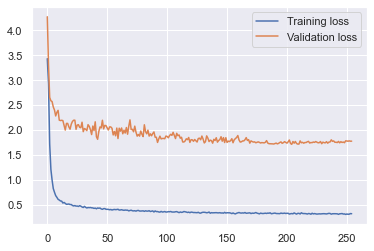

<Figure size 432x288 with 0 Axes>





Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_6 (LSTM)                  (None, 45, 24)       3744        ['input_3[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 45, 24)       0           ['lstm_6[0][0]']                 
                                                                                                  
 lstm_7 (LSTM)                  (None, 45, 16)       2624        ['dropout_4[0][0]']              
                                                                                        

66/66 [==============================] - 3s 38ms/step - loss: 1.2385 - val_loss: 2.7349 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0106
Epoch 5: val_loss did not improve from 2.73489

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 2s 37ms/step - loss: 1.0078 - val_loss: 2.8754 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8855
Epoch 6: val_loss did not improve from 2.73489

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.8871 - val_loss: 2.9368 - lr: 9.9000e-05
Epoch 7/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7943
Epoch 7: val_loss did not improve from 2.73489

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.702989402285311e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.7938 - val_loss: 3

65/66 [============================>.] - ETA: 0s - loss: 0.4629
Epoch 56: val_loss did not improve from 2.15468

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.491024330898654e-05.
66/66 [==============================] - 2s 35ms/step - loss: 0.4627 - val_loss: 2.1735 - lr: 6.5566e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4647
Epoch 57: val_loss improved from 2.15468 to 2.12437, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.07.hdf5
66/66 [==============================] - 2s 36ms/step - loss: 0.4652 - val_loss: 2.1244 - lr: 6.4910e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4566
Epoch 58: val_loss did not improve from 2.12437

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.426114152418449e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.4555 - val_loss: 2.1556 - lr: 6.4910e-05
Epoch 59/1000
65/66 [==================

66/66 [==============================] - 2s 37ms/step - loss: 0.4414 - val_loss: 1.6194 - lr: 5.5268e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4403
Epoch 82: val_loss did not improve from 1.61936

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.471563996252371e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.4393 - val_loss: 1.6498 - lr: 5.5268e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4462
Epoch 83: val_loss did not improve from 1.61936

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.416848503955407e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.4468 - val_loss: 1.6747 - lr: 5.4716e-05
Epoch 84/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4212
Epoch 84: val_loss did not improve from 1.61936

Epoch 84: ReduceLROnPlateau reducing learning rate to 5.362680094549433e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.4204 - va

66/66 [==============================] - 3s 44ms/step - loss: 0.4114 - val_loss: 1.5583 - lr: 4.4752e-05
Epoch 108/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4106
Epoch 108: val_loss did not improve from 1.55602

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.386173510283697e-05.
66/66 [==============================] - 3s 45ms/step - loss: 0.4110 - val_loss: 1.6072 - lr: 4.4305e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4094
Epoch 109: val_loss did not improve from 1.55602

Epoch 109: ReduceLROnPlateau reducing learning rate to 4.342311796790454e-05.
66/66 [==============================] - 3s 48ms/step - loss: 0.4095 - val_loss: 1.5988 - lr: 4.3862e-05
Epoch 110/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4159
Epoch 110: val_loss did not improve from 1.55602

Epoch 110: ReduceLROnPlateau reducing learning rate to 4.298888758057728e-05.
66/66 [==============================] - 3s 43ms/step - loss: 0.

66/66 [==============================] - 2s 36ms/step - loss: 0.4059 - val_loss: 1.5716 - lr: 3.5161e-05
Epoch 134/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4015
Epoch 134: val_loss did not improve from 1.49129

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.446120870648883e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.4010 - val_loss: 1.5901 - lr: 3.4809e-05
Epoch 135/1000
66/66 [==============================] - ETA: 0s - loss: 0.4011
Epoch 135: val_loss did not improve from 1.49129

Epoch 135: ReduceLROnPlateau reducing learning rate to 3.4116596907551866e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.4011 - val_loss: 1.5689 - lr: 3.4461e-05
Epoch 136/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4024
Epoch 136: val_loss did not improve from 1.49129

Epoch 136: ReduceLROnPlateau reducing learning rate to 3.37754318388761e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.

Epoch 160/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3973
Epoch 160: val_loss did not improve from 1.45840

Epoch 160: ReduceLROnPlateau reducing learning rate to 2.6804661192727508e-05.
66/66 [==============================] - 3s 39ms/step - loss: 0.3956 - val_loss: 1.5018 - lr: 2.7075e-05
Epoch 161/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3948
Epoch 161: val_loss did not improve from 1.45840

Epoch 161: ReduceLROnPlateau reducing learning rate to 2.6536613986536395e-05.
66/66 [==============================] - 3s 40ms/step - loss: 0.3955 - val_loss: 1.4987 - lr: 2.6805e-05
Epoch 162/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3839
Epoch 162: val_loss did not improve from 1.45840

Epoch 162: ReduceLROnPlateau reducing learning rate to 2.6271248170814942e-05.
66/66 [==============================] - 3s 40ms/step - loss: 0.3856 - val_loss: 1.5151 - lr: 2.6537e-05
Epoch 163/1000
65/66 [============================>.] - ETA: 

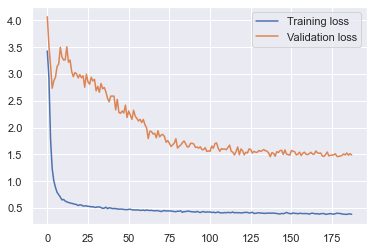

<Figure size 432x288 with 0 Axes>





Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_9 (LSTM)                  (None, 45, 24)       3744        ['input_4[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 45, 24)       0           ['lstm_9[0][0]']                 
                                                                                                  
 lstm_10 (LSTM)                 (None, 45, 16)       2624        ['dropout_6[0][0]']              
                                                                                        

66/66 [==============================] - 2s 37ms/step - loss: 1.3316 - val_loss: 2.2467 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0892
Epoch 5: val_loss improved from 2.24666 to 1.88371, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.08.hdf5
66/66 [==============================] - 2s 37ms/step - loss: 1.0870 - val_loss: 1.8837 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9657
Epoch 6: val_loss improved from 1.88371 to 1.75450, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.08.hdf5
66/66 [==============================] - 2s 37ms/step - loss: 0.9645 - val_loss: 1.7545 - lr: 1.0000e-04
Epoch 7/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8739
Epoch 7: val_loss did not improve from 1.75450

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.89999

Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5939
Epoch 31: val_loss did not improve from 1.75450

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.778212770062965e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.5939 - val_loss: 3.0487 - lr: 7.8568e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5941
Epoch 32: val_loss did not improve from 1.75450

Epoch 32: ReduceLROnPlateau reducing learning rate to 7.70043047668878e-05.
66/66 [==============================] - 2s 37ms/step - loss: 0.5942 - val_loss: 2.7745 - lr: 7.7782e-05
Epoch 33/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5974
Epoch 33: val_loss did not improve from 1.75450

Epoch 33: ReduceLROnPlateau reducing learning rate to 7.623426128702704e-05.
66/66 [==============================] - 2s 36ms/step - loss: 0.5965 - val_loss: 2.8621 - lr: 7.7004e-05
Epoch 34/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5

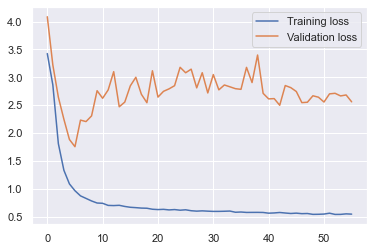

<Figure size 432x288 with 0 Axes>





Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_12 (LSTM)                 (None, 45, 24)       3744        ['input_5[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 45, 24)       0           ['lstm_12[0][0]']                
                                                                                                  
 lstm_13 (LSTM)                 (None, 45, 16)       2624        ['dropout_8[0][0]']              
                                                                                        

66/66 [==============================] - 2s 38ms/step - loss: 1.2845 - val_loss: 2.1767 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.1268
Epoch 5: val_loss improved from 2.17672 to 1.95885, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.09.hdf5
66/66 [==============================] - 2s 37ms/step - loss: 1.1267 - val_loss: 1.9588 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0199
Epoch 6: val_loss improved from 1.95885 to 1.85305, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.09.hdf5
66/66 [==============================] - 3s 38ms/step - loss: 1.0211 - val_loss: 1.8530 - lr: 1.0000e-04
Epoch 7/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9460
Epoch 7: val_loss improved from 1.85305 to 1.69187, saving model to C:\Users\Alex Lam\OneDrive\Documents\Dem

66/66 [==============================] - 3s 40ms/step - loss: 0.6576 - val_loss: 1.4352 - lr: 8.7752e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6350
Epoch 30: val_loss improved from 1.39512 to 1.38919, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.09.hdf5
66/66 [==============================] - 3s 40ms/step - loss: 0.6390 - val_loss: 1.3892 - lr: 8.6875e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6615
Epoch 31: val_loss improved from 1.38919 to 1.35720, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.09.hdf5
66/66 [==============================] - 3s 40ms/step - loss: 0.6594 - val_loss: 1.3572 - lr: 8.6875e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6511
Epoch 32: val_loss improved from 1.35720 to 1.33539, saving model to C:\Users\Alex Lam\OneDrive\Documen

Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6033
Epoch 56: val_loss did not improve from 1.33539

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.82554372906452e-05.
66/66 [==============================] - 3s 40ms/step - loss: 0.6052 - val_loss: 1.5732 - lr: 6.8945e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5996
Epoch 57: val_loss did not improve from 1.33539

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.75728838541545e-05.
66/66 [==============================] - 3s 40ms/step - loss: 0.5988 - val_loss: 1.6203 - lr: 6.8255e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5912
Epoch 58: val_loss did not improve from 1.33539

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.689715184620581e-05.
66/66 [==============================] - 3s 40ms/step - loss: 0.5918 - val_loss: 1.6541 - lr: 6.7573e-05
Epoch 59/1000
66/66 [==============================] - ETA: 0s - loss: 0.59

66/66 [==============================] - 3s 46ms/step - loss: 0.5716 - val_loss: 1.6361 - lr: 5.3091e-05


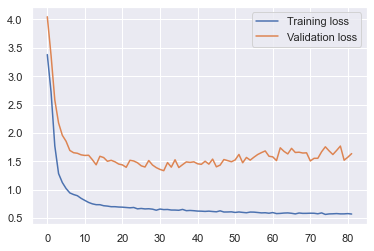

<Figure size 432x288 with 0 Axes>





Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_15 (LSTM)                 (None, 45, 24)       3744        ['input_6[0][0]']                
                                                                                                  
 dropout_10 (Dropout)           (None, 45, 24)       0           ['lstm_15[0][0]']                
                                                                                                  
 lstm_16 (LSTM)                 (None, 45, 16)       2624        ['dropout_10[0][0]']             
                                                                                        

65/66 [============================>.] - ETA: 0s - loss: 1.4570
Epoch 4: val_loss improved from 2.87941 to 2.74685, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 3s 41ms/step - loss: 1.4545 - val_loss: 2.7468 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.1810
Epoch 5: val_loss improved from 2.74685 to 2.73838, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 3s 42ms/step - loss: 1.1814 - val_loss: 2.7384 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0552
Epoch 6: val_loss did not improve from 2.73838

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 3s 41ms/step - loss: 1.0582 - val_loss: 2.8714 - lr: 1.0000e-04

66/66 [==============================] - 3s 43ms/step - loss: 0.6688 - val_loss: 2.0085 - lr: 6.6228e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.6830
Epoch 56: val_loss did not improve from 1.74525

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.491024330898654e-05.
66/66 [==============================] - 3s 43ms/step - loss: 0.6830 - val_loss: 1.8416 - lr: 6.5566e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6566
Epoch 57: val_loss did not improve from 1.74525

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.426114152418449e-05.
66/66 [==============================] - 3s 43ms/step - loss: 0.6596 - val_loss: 1.8898 - lr: 6.4910e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6751
Epoch 58: val_loss did not improve from 1.74525

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.361852982081473e-05.
66/66 [==============================] - 3s 43ms/step - loss: 0.6738 - va

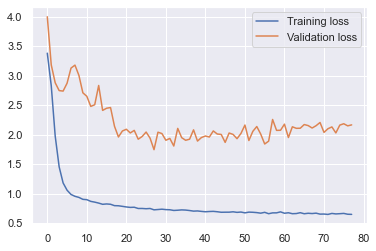

<Figure size 432x288 with 0 Axes>





Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 45, 24)       3744        ['input_7[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 45, 24)       0           ['lstm_18[0][0]']                
                                                                                                  
 lstm_19 (LSTM)                 (None, 45, 16)       2624        ['dropout_12[0][0]']             
                                                                                        

65/66 [============================>.] - ETA: 0s - loss: 1.3428
Epoch 4: val_loss improved from 2.62642 to 2.31316, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.11.hdf5
66/66 [==============================] - 4s 61ms/step - loss: 1.3453 - val_loss: 2.3132 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.1675
Epoch 5: val_loss did not improve from 2.31316

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 4s 53ms/step - loss: 1.1657 - val_loss: 2.5569 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0900
Epoch 6: val_loss did not improve from 2.31316

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==============================] - 3s 52ms/step - loss: 1.0888 - val_loss: 2.7137 - lr: 9.9000e-05
Epoch 7/1000
65/66 [==========================

66/66 [==============================] - 3s 46ms/step - loss: 0.7838 - val_loss: 2.8600 - lr: 7.7782e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 0.7782
Epoch 31: val_loss did not improve from 2.31316

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.623426128702704e-05.
66/66 [==============================] - 3s 46ms/step - loss: 0.7782 - val_loss: 3.0233 - lr: 7.7004e-05
Epoch 32/1000
66/66 [==============================] - ETA: 0s - loss: 0.7639
Epoch 32: val_loss did not improve from 2.31316

Epoch 32: ReduceLROnPlateau reducing learning rate to 7.547191802586894e-05.
66/66 [==============================] - 3s 45ms/step - loss: 0.7639 - val_loss: 2.6573 - lr: 7.6234e-05
Epoch 33/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7763
Epoch 33: val_loss did not improve from 2.31316

Epoch 33: ReduceLROnPlateau reducing learning rate to 7.47171957482351e-05.
66/66 [==============================] - 3s 45ms/step - loss: 0.7737 - val

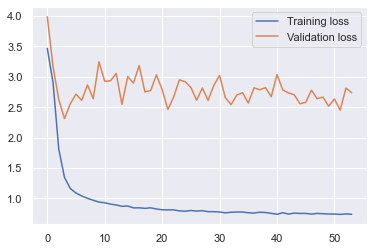

<Figure size 432x288 with 0 Axes>





Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_21 (LSTM)                 (None, 45, 24)       3744        ['input_8[0][0]']                
                                                                                                  
 dropout_14 (Dropout)           (None, 45, 24)       0           ['lstm_21[0][0]']                
                                                                                                  
 lstm_22 (LSTM)                 (None, 45, 16)       2624        ['dropout_14[0][0]']             
                                                                                        

66/66 [==============================] - ETA: 0s - loss: 1.4193
Epoch 4: val_loss improved from 3.14874 to 2.99376, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.12.hdf5
66/66 [==============================] - 4s 57ms/step - loss: 1.4193 - val_loss: 2.9938 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.2480
Epoch 5: val_loss did not improve from 2.99376

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 4s 53ms/step - loss: 1.2473 - val_loss: 3.2835 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.1494
Epoch 6: val_loss did not improve from 2.99376

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==============================] - 4s 55ms/step - loss: 1.1485 - val_loss: 3.3242 - lr: 9.9000e-05
Epoch 7/1000
65/66 [==========================

66/66 [==============================] - 3s 44ms/step - loss: 0.8144 - val_loss: 2.4862 - lr: 8.3451e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8072
Epoch 30: val_loss improved from 2.46967 to 2.46247, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.12.hdf5
66/66 [==============================] - 3s 44ms/step - loss: 0.8083 - val_loss: 2.4625 - lr: 8.2617e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8069
Epoch 31: val_loss did not improve from 2.46247

Epoch 31: ReduceLROnPlateau reducing learning rate to 8.179068579920567e-05.
66/66 [==============================] - 3s 43ms/step - loss: 0.8075 - val_loss: 2.5812 - lr: 8.2617e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7991
Epoch 32: val_loss did not improve from 2.46247

Epoch 32: ReduceLROnPlateau reducing learning rate to 8.097277706838213e-05.
66/66 [==================

Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7696
Epoch 56: val_loss did not improve from 2.31241

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.491024330898654e-05.
66/66 [==============================] - 3s 44ms/step - loss: 0.7683 - val_loss: 2.4385 - lr: 6.5566e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7613
Epoch 57: val_loss did not improve from 2.31241

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.426114152418449e-05.
66/66 [==============================] - 3s 45ms/step - loss: 0.7652 - val_loss: 2.5385 - lr: 6.4910e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7596
Epoch 58: val_loss did not improve from 2.31241

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.361852982081473e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.7601 - val_loss: 2.5371 - lr: 6.4261e-05
Epoch 59/1000
66/66 [==============================] - ETA: 0s - loss: 0.


Epoch 82: ReduceLROnPlateau reducing learning rate to 5.048856924986467e-05.
66/66 [==============================] - 3s 46ms/step - loss: 0.7394 - val_loss: 2.6647 - lr: 5.0999e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7395
Epoch 83: val_loss did not improve from 2.29587

Epoch 83: ReduceLROnPlateau reducing learning rate to 4.998368269298226e-05.
66/66 [==============================] - 3s 44ms/step - loss: 0.7382 - val_loss: 2.5708 - lr: 5.0489e-05
Epoch 84/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7365
Epoch 84: val_loss did not improve from 2.29587

Epoch 84: ReduceLROnPlateau reducing learning rate to 4.9483845577924514e-05.
66/66 [==============================] - 3s 44ms/step - loss: 0.7351 - val_loss: 2.5790 - lr: 4.9984e-05
Epoch 85/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7310
Epoch 85: val_loss did not improve from 2.29587

Epoch 85: ReduceLROnPlateau reducing learning rate to 4.898900748230517

66/66 [==============================] - 3s 48ms/step - loss: 0.7297 - val_loss: 2.4205 - lr: 4.0068e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7192
Epoch 109: val_loss did not improve from 2.26121

Epoch 109: ReduceLROnPlateau reducing learning rate to 3.927109017240582e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.7182 - val_loss: 2.2861 - lr: 3.9668e-05
Epoch 110/1000
66/66 [==============================] - ETA: 0s - loss: 0.7257
Epoch 110: val_loss did not improve from 2.26121

Epoch 110: ReduceLROnPlateau reducing learning rate to 3.887837901856983e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.7257 - val_loss: 2.4720 - lr: 3.9271e-05
Epoch 111/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7242
Epoch 111: val_loss did not improve from 2.26121

Epoch 111: ReduceLROnPlateau reducing learning rate to 3.848959360766457e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.

Epoch 135/1000
66/66 [==============================] - ETA: 0s - loss: 0.7113
Epoch 135: val_loss did not improve from 2.26121

Epoch 135: ReduceLROnPlateau reducing learning rate to 3.024043358891504e-05.
66/66 [==============================] - 3s 51ms/step - loss: 0.7113 - val_loss: 2.3637 - lr: 3.0546e-05
Epoch 136/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7079
Epoch 136: val_loss did not improve from 2.26121

Epoch 136: ReduceLROnPlateau reducing learning rate to 2.9938028928881975e-05.
66/66 [==============================] - 3s 41ms/step - loss: 0.7061 - val_loss: 2.3971 - lr: 3.0240e-05
Epoch 137/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7064
Epoch 137: val_loss did not improve from 2.26121

Epoch 137: ReduceLROnPlateau reducing learning rate to 2.963864781122538e-05.
66/66 [==============================] - 3s 42ms/step - loss: 0.7048 - val_loss: 2.3403 - lr: 2.9938e-05
Epoch 138/1000
65/66 [============================>.] - ETA: 0s

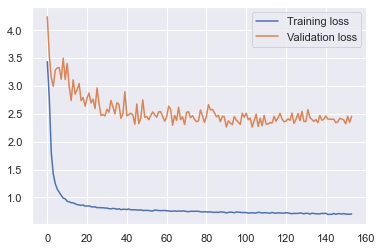

<Figure size 432x288 with 0 Axes>





Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_24 (LSTM)                 (None, 45, 24)       3744        ['input_9[0][0]']                
                                                                                                  
 dropout_16 (Dropout)           (None, 45, 24)       0           ['lstm_24[0][0]']                
                                                                                                  
 lstm_25 (LSTM)                 (None, 45, 16)       2624        ['dropout_16[0][0]']             
                                                                                        

65/66 [============================>.] - ETA: 0s - loss: 1.4706
Epoch 4: val_loss did not improve from 3.05554

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 3s 44ms/step - loss: 1.4709 - val_loss: 3.3773 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.3044
Epoch 5: val_loss did not improve from 3.05554

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==============================] - 3s 45ms/step - loss: 1.3041 - val_loss: 3.8896 - lr: 9.9000e-05
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.2198
Epoch 6: val_loss did not improve from 3.05554

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.702989402285311e-05.
66/66 [==============================] - 3s 44ms/step - loss: 1.2181 - val_loss: 4.2123 - lr: 9.8010e-05
Epoch 7/1000
65/66 [============================>.] - ETA: 0s - loss: 1.1777
Epoch 7: val_loss 

66/66 [==============================] - 4s 63ms/step - loss: 0.9249 - val_loss: 2.5884 - lr: 8.2617e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9277
Epoch 30: val_loss improved from 2.58844 to 2.55428, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.13.hdf5
66/66 [==============================] - 4s 58ms/step - loss: 0.9264 - val_loss: 2.5543 - lr: 8.2617e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9118
Epoch 31: val_loss did not improve from 2.55428

Epoch 31: ReduceLROnPlateau reducing learning rate to 8.179068579920567e-05.
66/66 [==============================] - 4s 54ms/step - loss: 0.9182 - val_loss: 2.6255 - lr: 8.2617e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9145
Epoch 32: val_loss did not improve from 2.55428

Epoch 32: ReduceLROnPlateau reducing learning rate to 8.097277706838213e-05.
66/66 [==================

66/66 [==============================] - 4s 58ms/step - loss: 0.8381 - val_loss: 2.2049 - lr: 7.2498e-05
Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8458
Epoch 55: val_loss did not improve from 2.20488

Epoch 55: ReduceLROnPlateau reducing learning rate to 7.177303261414636e-05.
66/66 [==============================] - 3s 41ms/step - loss: 0.8450 - val_loss: 2.2787 - lr: 7.2498e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.8471
Epoch 56: val_loss did not improve from 2.20488

Epoch 56: ReduceLROnPlateau reducing learning rate to 7.105529875843786e-05.
66/66 [==============================] - 3s 42ms/step - loss: 0.8471 - val_loss: 2.3435 - lr: 7.1773e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8430
Epoch 57: val_loss improved from 2.20488 to 2.18555, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.13.hdf5
66/66 [==================

65/66 [============================>.] - ETA: 0s - loss: 0.7961
Epoch 106: val_loss did not improve from 1.85312

Epoch 106: ReduceLROnPlateau reducing learning rate to 4.705864765128354e-05.
66/66 [==============================] - 3s 52ms/step - loss: 0.7946 - val_loss: 1.8540 - lr: 4.7534e-05
Epoch 107/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7969
Epoch 107: val_loss did not improve from 1.85312

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.658806272345828e-05.
66/66 [==============================] - 3s 51ms/step - loss: 0.7967 - val_loss: 1.8799 - lr: 4.7059e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.7920
Epoch 108: val_loss did not improve from 1.85312

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.612218148395186e-05.
66/66 [==============================] - 3s 50ms/step - loss: 0.7920 - val_loss: 1.9493 - lr: 4.6588e-05
Epoch 109/1000
66/66 [==============================] - ETA: 0s - loss: 0.7809



Epoch 158: ReduceLROnPlateau reducing learning rate to 2.8186058098071954e-05.
66/66 [==============================] - 3s 45ms/step - loss: 0.7652 - val_loss: 1.8742 - lr: 2.8471e-05
Epoch 159/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7688
Epoch 159: val_loss did not improve from 1.81354

Epoch 159: ReduceLROnPlateau reducing learning rate to 2.7904196958843385e-05.
66/66 [==============================] - 3s 45ms/step - loss: 0.7683 - val_loss: 1.8996 - lr: 2.8186e-05


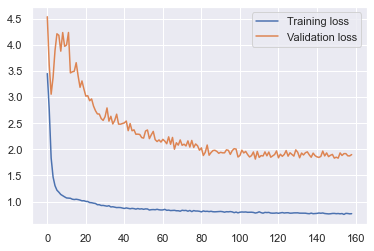

<Figure size 432x288 with 0 Axes>





Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_27 (LSTM)                 (None, 45, 24)       3744        ['input_10[0][0]']               
                                                                                                  
 dropout_18 (Dropout)           (None, 45, 24)       0           ['lstm_27[0][0]']                
                                                                                                  
 lstm_28 (LSTM)                 (None, 45, 16)       2624        ['dropout_18[0][0]']             
                                                                                        

66/66 [==============================] - ETA: 0s - loss: 1.6227
Epoch 4: val_loss improved from 3.25935 to 2.94380, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 3s 44ms/step - loss: 1.6227 - val_loss: 2.9438 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.4038
Epoch 5: val_loss improved from 2.94380 to 2.87041, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 3s 46ms/step - loss: 1.4038 - val_loss: 2.8704 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.2940
Epoch 6: val_loss improved from 2.87041 to 2.75125, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 3s 45ms/step

66/66 [==============================] - 4s 58ms/step - loss: 0.9475 - val_loss: 1.9093 - lr: 8.9534e-05
Epoch 29/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9447
Epoch 29: val_loss improved from 1.89374 to 1.88895, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 4s 58ms/step - loss: 0.9454 - val_loss: 1.8890 - lr: 8.8638e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9481
Epoch 30: val_loss improved from 1.88895 to 1.83260, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 4s 56ms/step - loss: 0.9488 - val_loss: 1.8326 - lr: 8.8638e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 0.9317
Epoch 31: val_loss did not improve from 1.83260

Epoch 31: ReduceLROnPlateau reducing learning rate to 

66/66 [==============================] - 3s 50ms/step - loss: 0.8737 - val_loss: 1.5694 - lr: 7.7782e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 0.8704
Epoch 54: val_loss did not improve from 1.56186

Epoch 54: ReduceLROnPlateau reducing learning rate to 7.623426128702704e-05.
66/66 [==============================] - 3s 48ms/step - loss: 0.8704 - val_loss: 1.5662 - lr: 7.7004e-05
Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8656
Epoch 55: val_loss did not improve from 1.56186

Epoch 55: ReduceLROnPlateau reducing learning rate to 7.547191802586894e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.8720 - val_loss: 1.5869 - lr: 7.6234e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8777
Epoch 56: val_loss improved from 1.56186 to 1.55340, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.14.hdf5
66/66 [==================

66/66 [==============================] - 3s 50ms/step - loss: 0.8573 - val_loss: 1.5025 - lr: 6.2982e-05
Epoch 80/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8521
Epoch 80: val_loss did not improve from 1.50248

Epoch 80: ReduceLROnPlateau reducing learning rate to 6.235251734324266e-05.
66/66 [==============================] - 4s 62ms/step - loss: 0.8514 - val_loss: 1.5128 - lr: 6.2982e-05
Epoch 81/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8478
Epoch 81: val_loss did not improve from 1.50248

Epoch 81: ReduceLROnPlateau reducing learning rate to 6.17289941146737e-05.
66/66 [==============================] - 3s 51ms/step - loss: 0.8497 - val_loss: 1.5081 - lr: 6.2353e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.8457
Epoch 82: val_loss did not improve from 1.50248

Epoch 82: ReduceLROnPlateau reducing learning rate to 6.111170165240765e-05.
66/66 [==============================] - 3s 51ms/step - loss: 0.8457 - val

Epoch 106/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8219
Epoch 106: val_loss did not improve from 1.49971

Epoch 106: ReduceLROnPlateau reducing learning rate to 4.898900748230517e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.8235 - val_loss: 1.5158 - lr: 4.9484e-05
Epoch 107/1000
66/66 [==============================] - ETA: 0s - loss: 0.8216
Epoch 107: val_loss did not improve from 1.49971

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.849911798373796e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.8216 - val_loss: 1.5274 - lr: 4.8989e-05
Epoch 108/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8290
Epoch 108: val_loss did not improve from 1.49971

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.801412665983662e-05.
66/66 [==============================] - 3s 50ms/step - loss: 0.8296 - val_loss: 1.5175 - lr: 4.8499e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s 


Epoch 132: ReduceLROnPlateau reducing learning rate to 3.772365234908648e-05.
66/66 [==============================] - 3s 44ms/step - loss: 0.8127 - val_loss: 1.5229 - lr: 3.8105e-05
Epoch 133/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8106
Epoch 133: val_loss did not improve from 1.49971

Epoch 133: ReduceLROnPlateau reducing learning rate to 3.734641726623522e-05.
66/66 [==============================] - 3s 44ms/step - loss: 0.8123 - val_loss: 1.5162 - lr: 3.7724e-05
Epoch 134/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8072
Epoch 134: val_loss did not improve from 1.49971

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.6972953057556876e-05.
66/66 [==============================] - 3s 44ms/step - loss: 0.8132 - val_loss: 1.5333 - lr: 3.7346e-05
Epoch 135/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8161
Epoch 135: val_loss did not improve from 1.49971

Epoch 135: ReduceLROnPlateau reducing learning rate to 3.66032

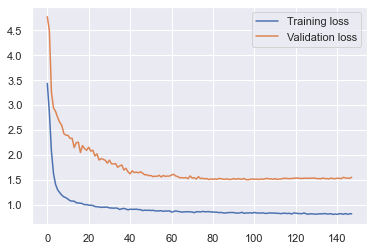

<Figure size 432x288 with 0 Axes>





Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_30 (LSTM)                 (None, 45, 24)       3744        ['input_11[0][0]']               
                                                                                                  
 dropout_20 (Dropout)           (None, 45, 24)       0           ['lstm_30[0][0]']                
                                                                                                  
 lstm_31 (LSTM)                 (None, 45, 16)       2624        ['dropout_20[0][0]']             
                                                                                       

65/66 [============================>.] - ETA: 0s - loss: 1.5650
Epoch 4: val_loss improved from 3.12599 to 3.08796, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 3s 50ms/step - loss: 1.5646 - val_loss: 3.0880 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.4506
Epoch 5: val_loss improved from 3.08796 to 3.07832, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 3s 49ms/step - loss: 1.4506 - val_loss: 3.0783 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.3593
Epoch 6: val_loss improved from 3.07832 to 3.02663, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 3s 52ms/step

Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9551
Epoch 30: val_loss did not improve from 2.81490

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [==============================] - 3s 39ms/step - loss: 0.9559 - val_loss: 2.8896 - lr: 8.0163e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9624
Epoch 31: val_loss improved from 2.81490 to 2.74053, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 3s 40ms/step - loss: 0.9617 - val_loss: 2.7405 - lr: 7.9361e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9541
Epoch 32: val_loss improved from 2.74053 to 2.69164, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 3s 40ms/step - loss: 0.9534 - val_loss: 2

66/66 [==============================] - 3s 42ms/step - loss: 0.9043 - val_loss: 2.3351 - lr: 6.6897e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9054
Epoch 56: val_loss improved from 2.22941 to 2.17616, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 3s 42ms/step - loss: 0.9026 - val_loss: 2.1762 - lr: 6.6228e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8916
Epoch 57: val_loss improved from 2.17616 to 2.17609, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.15.hdf5

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.55659000040032e-05.
66/66 [==============================] - 3s 42ms/step - loss: 0.8925 - val_loss: 2.1761 - lr: 6.6228e-05
Epoch 58/1000
66/66 [==============================] - ETA: 0s - loss: 0.8915
Epoch 58: val_loss improve

66/66 [==============================] - 3s 44ms/step - loss: 0.8773 - val_loss: 2.0122 - lr: 5.5827e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.8732
Epoch 81: val_loss did not improve from 2.01220

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.526832333998754e-05.
66/66 [==============================] - 4s 59ms/step - loss: 0.8732 - val_loss: 2.0476 - lr: 5.5827e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.8713
Epoch 82: val_loss did not improve from 2.01220

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.471563996252371e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.8713 - val_loss: 2.0550 - lr: 5.5268e-05
Epoch 83/1000
66/66 [==============================] - ETA: 0s - loss: 0.8734
Epoch 83: val_loss did not improve from 2.01220

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.416848503955407e-05.
66/66 [==============================] - 5s 82ms/step - loss: 0.8734 - va

66/66 [==============================] - 3s 49ms/step - loss: 0.8651 - val_loss: 1.9882 - lr: 4.5204e-05
Epoch 107/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8597
Epoch 107: val_loss did not improve from 1.94599

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.43047822045628e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.8613 - val_loss: 2.0721 - lr: 4.4752e-05
Epoch 108/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8643
Epoch 108: val_loss did not improve from 1.94599

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.386173510283697e-05.
66/66 [==============================] - 3s 48ms/step - loss: 0.8636 - val_loss: 2.0378 - lr: 4.4305e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8552
Epoch 109: val_loss did not improve from 1.94599

Epoch 109: ReduceLROnPlateau reducing learning rate to 4.342311796790454e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.8

66/66 [==============================] - 3s 42ms/step - loss: 0.8392 - val_loss: 1.9659 - lr: 3.5516e-05
Epoch 133/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8542
Epoch 133: val_loss did not improve from 1.91982

Epoch 133: ReduceLROnPlateau reducing learning rate to 3.480930325167719e-05.
66/66 [==============================] - 3s 51ms/step - loss: 0.8530 - val_loss: 1.9657 - lr: 3.5161e-05
Epoch 134/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8537
Epoch 134: val_loss did not improve from 1.91982

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.446120870648883e-05.
66/66 [==============================] - 4s 58ms/step - loss: 0.8528 - val_loss: 2.0135 - lr: 3.4809e-05
Epoch 135/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8508
Epoch 135: val_loss improved from 1.91982 to 1.90953, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.15.hdf5
66/66 [==========

66/66 [==============================] - 3s 39ms/step - loss: 0.8295 - val_loss: 2.0206 - lr: 2.7904e-05
Epoch 159/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8483
Epoch 159: val_loss did not improve from 1.90791

Epoch 159: ReduceLROnPlateau reducing learning rate to 2.734890422289027e-05.
66/66 [==============================] - 3s 39ms/step - loss: 0.8463 - val_loss: 2.0365 - lr: 2.7625e-05
Epoch 160/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8333
Epoch 160: val_loss did not improve from 1.90791

Epoch 160: ReduceLROnPlateau reducing learning rate to 2.7075415000581416e-05.
66/66 [==============================] - 3s 39ms/step - loss: 0.8347 - val_loss: 1.9658 - lr: 2.7349e-05
Epoch 161/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8332
Epoch 161: val_loss did not improve from 1.90791

Epoch 161: ReduceLROnPlateau reducing learning rate to 2.6804661192727508e-05.
66/66 [==============================] - 3s 40ms/step - loss: 

Epoch 185/1000
66/66 [==============================] - ETA: 0s - loss: 0.8319
Epoch 185: val_loss did not improve from 1.89385

Epoch 185: ReduceLROnPlateau reducing learning rate to 2.1272560079523828e-05.
66/66 [==============================] - 3s 42ms/step - loss: 0.8319 - val_loss: 1.9573 - lr: 2.1487e-05
Epoch 186/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8278
Epoch 186: val_loss did not improve from 1.89385

Epoch 186: ReduceLROnPlateau reducing learning rate to 2.1059835235064383e-05.
66/66 [==============================] - 3s 41ms/step - loss: 0.8269 - val_loss: 1.9256 - lr: 2.1273e-05
Epoch 187/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8355
Epoch 187: val_loss did not improve from 1.89385

Epoch 187: ReduceLROnPlateau reducing learning rate to 2.084923713482567e-05.
66/66 [==============================] - 3s 41ms/step - loss: 0.8338 - val_loss: 1.9298 - lr: 2.1060e-05
Epoch 188/1000
65/66 [============================>.] - ETA: 0

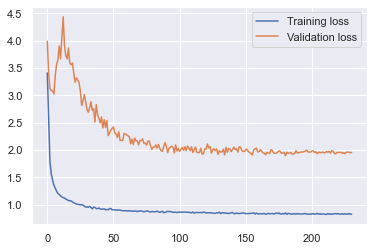

<Figure size 432x288 with 0 Axes>





Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_33 (LSTM)                 (None, 45, 24)       3744        ['input_12[0][0]']               
                                                                                                  
 dropout_22 (Dropout)           (None, 45, 24)       0           ['lstm_33[0][0]']                
                                                                                                  
 lstm_34 (LSTM)                 (None, 45, 16)       2624        ['dropout_22[0][0]']             
                                                                                       

65/66 [============================>.] - ETA: 0s - loss: 1.5933
Epoch 4: val_loss improved from 2.87904 to 2.86094, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 4s 57ms/step - loss: 1.5916 - val_loss: 2.8609 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.4532
Epoch 5: val_loss improved from 2.86094 to 2.54748, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 3s 41ms/step - loss: 1.4532 - val_loss: 2.5475 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.3628
Epoch 6: val_loss did not improve from 2.54748

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 3s 39ms/step - loss: 1.3608 - val_loss: 2.6116 - lr: 1.0000e-


Epoch 54: ReduceLROnPlateau reducing learning rate to 7.177303261414636e-05.
66/66 [==============================] - 3s 50ms/step - loss: 0.9493 - val_loss: 1.7371 - lr: 7.2498e-05
Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9510
Epoch 55: val_loss improved from 1.73296 to 1.73097, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 3s 50ms/step - loss: 0.9492 - val_loss: 1.7310 - lr: 7.1773e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9471
Epoch 56: val_loss improved from 1.73097 to 1.72846, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 3s 49ms/step - loss: 0.9492 - val_loss: 1.7285 - lr: 7.1773e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9333
Epoch 57: val_loss improv

Epoch 80/1000
66/66 [==============================] - ETA: 0s - loss: 0.9252
Epoch 80: val_loss did not improve from 1.67977

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.9895574922848026e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.9252 - val_loss: 1.7138 - lr: 6.0501e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.9163
Epoch 81: val_loss improved from 1.67977 to 1.67496, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 3s 49ms/step - loss: 0.9163 - val_loss: 1.6750 - lr: 5.9896e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.9213
Epoch 82: val_loss did not improve from 1.67496

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.9296618201187815e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.9213 - val_loss: 1.7275 - lr: 5.9896e-05
Epoch 83/1000
65/66 [==


Epoch 132: ReduceLROnPlateau reducing learning rate to 3.623719319875818e-05.
66/66 [==============================] - 3s 41ms/step - loss: 0.8943 - val_loss: 1.7080 - lr: 3.6603e-05
Epoch 133/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8895
Epoch 133: val_loss did not improve from 1.66110

Epoch 133: ReduceLROnPlateau reducing learning rate to 3.5874821915058416e-05.
66/66 [==============================] - 3s 41ms/step - loss: 0.8878 - val_loss: 1.7249 - lr: 3.6237e-05
Epoch 134/1000
66/66 [==============================] - ETA: 0s - loss: 0.8909
Epoch 134: val_loss did not improve from 1.66110

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.551607383997179e-05.
66/66 [==============================] - 3s 41ms/step - loss: 0.8909 - val_loss: 1.7358 - lr: 3.5875e-05


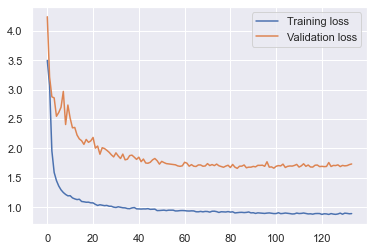

<Figure size 432x288 with 0 Axes>





Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_36 (LSTM)                 (None, 45, 24)       3744        ['input_13[0][0]']               
                                                                                                  
 dropout_24 (Dropout)           (None, 45, 24)       0           ['lstm_36[0][0]']                
                                                                                                  
 lstm_37 (LSTM)                 (None, 45, 16)       2624        ['dropout_24[0][0]']             
                                                                                       

65/66 [============================>.] - ETA: 0s - loss: 1.6751
Epoch 4: val_loss improved from 3.53449 to 3.44888, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.17.hdf5
66/66 [==============================] - 3s 43ms/step - loss: 1.6744 - val_loss: 3.4489 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.4673
Epoch 5: val_loss improved from 3.44888 to 3.02395, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.17.hdf5
66/66 [==============================] - 3s 43ms/step - loss: 1.4666 - val_loss: 3.0240 - lr: 1.0000e-04
Epoch 6/1000
66/66 [==============================] - ETA: 0s - loss: 1.3538
Epoch 6: val_loss improved from 3.02395 to 2.84867, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.17.hdf5
66/66 [==============================] - 3s 43ms/step

Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0345
Epoch 30: val_loss did not improve from 2.64691

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.01630511705298e-05.
66/66 [==============================] - 3s 47ms/step - loss: 1.0334 - val_loss: 2.8381 - lr: 8.0973e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0310
Epoch 31: val_loss did not improve from 2.64691

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [==============================] - 3s 47ms/step - loss: 1.0325 - val_loss: 2.7953 - lr: 8.0163e-05
Epoch 32/1000
66/66 [==============================] - ETA: 0s - loss: 1.0209
Epoch 32: val_loss improved from 2.64691 to 2.51824, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.17.hdf5
66/66 [==============================] - 3s 49ms/step - loss: 1.0209 - val_loss: 2.5182 - lr: 7.9361e-05
Epoch 33/1000
66/66 [=====


Epoch 55: ReduceLROnPlateau reducing learning rate to 6.75728838541545e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.9889 - val_loss: 2.3280 - lr: 6.8255e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9906
Epoch 56: val_loss did not improve from 2.26345

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.689715184620581e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.9890 - val_loss: 2.2800 - lr: 6.7573e-05
Epoch 57/1000
66/66 [==============================] - ETA: 0s - loss: 0.9697
Epoch 57: val_loss did not improve from 2.26345

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.622818364121486e-05.
66/66 [==============================] - 3s 46ms/step - loss: 0.9697 - val_loss: 2.2836 - lr: 6.6897e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9841
Epoch 58: val_loss did not improve from 2.26345

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.55659000040032e-0

66/66 [==============================] - 3s 47ms/step - loss: 0.9582 - val_loss: 2.2505 - lr: 5.4168e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.9574
Epoch 82: val_loss improved from 2.12159 to 2.09968, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.17.hdf5
66/66 [==============================] - 3s 47ms/step - loss: 0.9574 - val_loss: 2.0997 - lr: 5.3627e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9516
Epoch 83: val_loss did not improve from 2.09968

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.309053365635918e-05.
66/66 [==============================] - 3s 45ms/step - loss: 0.9518 - val_loss: 2.2429 - lr: 5.3627e-05
Epoch 84/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9741
Epoch 84: val_loss did not improve from 2.09968

Epoch 84: ReduceLROnPlateau reducing learning rate to 5.2559629148163366e-05.
66/66 [=================

66/66 [==============================] - 3s 49ms/step - loss: 0.9485 - val_loss: 2.0867 - lr: 4.3423e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.9338
Epoch 108: val_loss did not improve from 2.02780

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.2558997120067946e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.9338 - val_loss: 2.1143 - lr: 4.2989e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9363
Epoch 109: val_loss did not improve from 2.02780

Epoch 109: ReduceLROnPlateau reducing learning rate to 4.2133406968787315e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.9348 - val_loss: 2.1594 - lr: 4.2559e-05
Epoch 110/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9464
Epoch 110: val_loss did not improve from 2.02780

Epoch 110: ReduceLROnPlateau reducing learning rate to 4.1712073907547166e-05.
66/66 [==============================] - 3s 49ms/step - loss:

66/66 [==============================] - 3s 48ms/step - loss: 0.9284 - val_loss: 2.1321 - lr: 3.4117e-05
Epoch 134/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9406
Epoch 134: val_loss did not improve from 1.96507

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.3437677484471354e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.9388 - val_loss: 2.0924 - lr: 3.3775e-05
Epoch 135/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9224
Epoch 135: val_loss did not improve from 1.96507

Epoch 135: ReduceLROnPlateau reducing learning rate to 3.310330142994644e-05.
66/66 [==============================] - 3s 46ms/step - loss: 0.9208 - val_loss: 2.1651 - lr: 3.3438e-05
Epoch 136/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9283
Epoch 136: val_loss did not improve from 1.96507

Epoch 136: ReduceLROnPlateau reducing learning rate to 3.277226765931118e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0

Epoch 160/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9255
Epoch 160: val_loss did not improve from 1.96507

Epoch 160: ReduceLROnPlateau reducing learning rate to 2.5748449061211432e-05.
66/66 [==============================] - 3s 42ms/step - loss: 0.9237 - val_loss: 2.1040 - lr: 2.6009e-05
Epoch 161/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9189
Epoch 161: val_loss did not improve from 1.96507

Epoch 161: ReduceLROnPlateau reducing learning rate to 2.5490965344943107e-05.
66/66 [==============================] - 3s 43ms/step - loss: 0.9172 - val_loss: 2.0323 - lr: 2.5748e-05
Epoch 162/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9133
Epoch 162: val_loss did not improve from 1.96507

Epoch 162: ReduceLROnPlateau reducing learning rate to 2.523605497117387e-05.
66/66 [==============================] - 3s 42ms/step - loss: 0.9111 - val_loss: 2.0481 - lr: 2.5491e-05
Epoch 163/1000
65/66 [============================>.] - ETA: 0

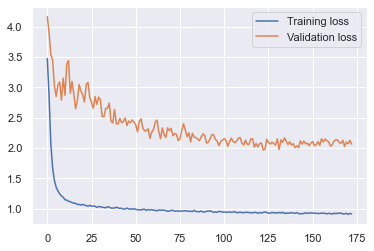

<Figure size 432x288 with 0 Axes>





Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_39 (LSTM)                 (None, 45, 24)       3744        ['input_14[0][0]']               
                                                                                                  
 dropout_26 (Dropout)           (None, 45, 24)       0           ['lstm_39[0][0]']                
                                                                                                  
 lstm_40 (LSTM)                 (None, 45, 16)       2624        ['dropout_26[0][0]']             
                                                                                       

65/66 [============================>.] - ETA: 0s - loss: 1.5889
Epoch 4: val_loss improved from 3.37410 to 3.13737, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.18.hdf5
66/66 [==============================] - 3s 43ms/step - loss: 1.5902 - val_loss: 3.1374 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.4333
Epoch 5: val_loss improved from 3.13737 to 2.92948, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.18.hdf5
66/66 [==============================] - 3s 44ms/step - loss: 1.4333 - val_loss: 2.9295 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.3814
Epoch 6: val_loss improved from 2.92948 to 2.83906, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.18.hdf5
66/66 [==============================] - 3s 43ms/step

66/66 [==============================] - ETA: 0s - loss: 1.0151
Epoch 53: val_loss did not improve from 1.77066

Epoch 53: ReduceLROnPlateau reducing learning rate to 7.778212770062965e-05.
66/66 [==============================] - 3s 49ms/step - loss: 1.0151 - val_loss: 1.8106 - lr: 7.8568e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 1.0089
Epoch 54: val_loss did not improve from 1.77066

Epoch 54: ReduceLROnPlateau reducing learning rate to 7.70043047668878e-05.
66/66 [==============================] - 3s 52ms/step - loss: 1.0089 - val_loss: 1.7768 - lr: 7.7782e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 1.0099
Epoch 55: val_loss did not improve from 1.77066

Epoch 55: ReduceLROnPlateau reducing learning rate to 7.623426128702704e-05.
66/66 [==============================] - 3s 48ms/step - loss: 1.0099 - val_loss: 1.7779 - lr: 7.7004e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 1.0029
Epoch 56: 


Epoch 79: ReduceLROnPlateau reducing learning rate to 6.111170165240765e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.9793 - val_loss: 1.7752 - lr: 6.1729e-05
Epoch 80/1000
66/66 [==============================] - ETA: 0s - loss: 0.9813
Epoch 80: val_loss did not improve from 1.73746

Epoch 80: ReduceLROnPlateau reducing learning rate to 6.0500582330860196e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.9813 - val_loss: 1.7542 - lr: 6.1112e-05
Epoch 81/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9813
Epoch 81: val_loss did not improve from 1.73746

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.9895574922848026e-05.
66/66 [==============================] - 3s 47ms/step - loss: 0.9812 - val_loss: 1.7489 - lr: 6.0501e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9793
Epoch 82: val_loss did not improve from 1.73746

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.92966182011878

Epoch 106/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9565
Epoch 106: val_loss did not improve from 1.73746

Epoch 106: ReduceLROnPlateau reducing learning rate to 4.658806272345828e-05.
66/66 [==============================] - 3s 49ms/step - loss: 0.9566 - val_loss: 1.8022 - lr: 4.7059e-05
Epoch 107/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9563
Epoch 107: val_loss did not improve from 1.73746

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.612218148395186e-05.
66/66 [==============================] - 4s 54ms/step - loss: 0.9535 - val_loss: 1.7863 - lr: 4.6588e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.9632
Epoch 108: val_loss did not improve from 1.73746

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.566096071357606e-05.
66/66 [==============================] - 4s 54ms/step - loss: 0.9632 - val_loss: 1.7936 - lr: 4.6122e-05
Epoch 109/1000
66/66 [==============================] - ETA: 0s 

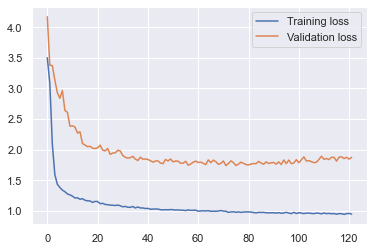

<Figure size 432x288 with 0 Axes>





Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_42 (LSTM)                 (None, 45, 24)       3744        ['input_15[0][0]']               
                                                                                                  
 dropout_28 (Dropout)           (None, 45, 24)       0           ['lstm_42[0][0]']                
                                                                                                  
 lstm_43 (LSTM)                 (None, 45, 16)       2624        ['dropout_28[0][0]']             
                                                                                       

65/66 [============================>.] - ETA: 0s - loss: 1.6727
Epoch 4: val_loss improved from 3.01345 to 2.77717, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.19.hdf5
66/66 [==============================] - 5s 68ms/step - loss: 1.6753 - val_loss: 2.7772 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.5426
Epoch 5: val_loss improved from 2.77717 to 2.73104, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.19.hdf5
66/66 [==============================] - 4s 66ms/step - loss: 1.5416 - val_loss: 2.7310 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 1.4530
Epoch 6: val_loss improved from 2.73104 to 2.62522, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.19.hdf5
66/66 [==============================] - 5s 70ms/step

Epoch 29/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0872
Epoch 29: val_loss improved from 2.04582 to 1.99269, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_1_CCMP_t+1_0.19.hdf5
66/66 [==============================] - 4s 67ms/step - loss: 1.0880 - val_loss: 1.9927 - lr: 8.7752e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 1.1065
Epoch 30: val_loss did not improve from 1.99269

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.687458052008878e-05.
66/66 [==============================] - 4s 66ms/step - loss: 1.1061 - val_loss: 2.0730 - lr: 8.7752e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0937
Epoch 31: val_loss did not improve from 1.99269

Epoch 31: ReduceLROnPlateau reducing learning rate to 8.600583161751274e-05.
66/66 [==============================] - 4s 68ms/step - loss: 1.0927 - val_loss: 2.0007 - lr: 8.6875e-05
Epoch 32/1000
65/66 [====

Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0346
Epoch 55: val_loss did not improve from 1.92637

Epoch 55: ReduceLROnPlateau reducing learning rate to 7.034474649117328e-05.
66/66 [==============================] - 5s 79ms/step - loss: 1.0363 - val_loss: 1.9402 - lr: 7.1055e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0396
Epoch 56: val_loss did not improve from 1.92637

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.964129657717422e-05.
66/66 [==============================] - 5s 76ms/step - loss: 1.0419 - val_loss: 1.9430 - lr: 7.0345e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0231
Epoch 57: val_loss did not improve from 1.92637

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.894488418765832e-05.
66/66 [==============================] - 5s 76ms/step - loss: 1.0216 - val_loss: 1.9309 - lr: 6.9641e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 1.

66/66 [==============================] - 5s 74ms/step - loss: 1.0163 - val_loss: 1.9497 - lr: 5.4716e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0155
Epoch 82: val_loss did not improve from 1.92637

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.362680094549433e-05.
66/66 [==============================] - 5s 74ms/step - loss: 1.0169 - val_loss: 1.9587 - lr: 5.4168e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0125
Epoch 83: val_loss did not improve from 1.92637

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.309053365635918e-05.
66/66 [==============================] - 5s 73ms/step - loss: 1.0123 - val_loss: 1.9392 - lr: 5.3627e-05
Epoch 84/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0134
Epoch 84: val_loss did not improve from 1.92637

Epoch 84: ReduceLROnPlateau reducing learning rate to 5.2559629148163366e-05.
66/66 [==============================] - 5s 73ms/step - loss: 1.0160 - v

Epoch 108/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9971
Epoch 108: val_loss did not improve from 1.92439

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.1712073907547166e-05.
66/66 [==============================] - 5s 72ms/step - loss: 0.9977 - val_loss: 1.9651 - lr: 4.2133e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9825
Epoch 109: val_loss did not improve from 1.92439

Epoch 109: ReduceLROnPlateau reducing learning rate to 4.1294954717159274e-05.
66/66 [==============================] - 5s 72ms/step - loss: 0.9846 - val_loss: 1.9750 - lr: 4.1712e-05
Epoch 110/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0139
Epoch 110: val_loss did not improve from 1.92439

Epoch 110: ReduceLROnPlateau reducing learning rate to 4.08820061784354e-05.
66/66 [==============================] - 5s 72ms/step - loss: 1.0116 - val_loss: 1.9612 - lr: 4.1295e-05
Epoch 111/1000
65/66 [============================>.] - ETA: 0s

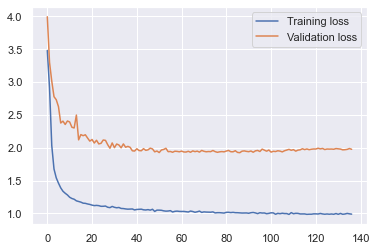

<Figure size 432x288 with 0 Axes>





Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_45 (LSTM)                 (None, 45, 24)       3744        ['input_16[0][0]']               
                                                                                                  
 dropout_30 (Dropout)           (None, 45, 24)       0           ['lstm_45[0][0]']                
                                                                                                  
 lstm_46 (LSTM)                 (None, 45, 16)       2624        ['dropout_30[0][0]']             
                                                                                       

65/66 [============================>.] - ETA: 0s - loss: 1.0443
Epoch 4: val_loss improved from 2.50762 to 2.29758, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.05.hdf5
66/66 [==============================] - 4s 66ms/step - loss: 1.0453 - val_loss: 2.2976 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8586
Epoch 5: val_loss improved from 2.29758 to 2.19037, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.05.hdf5
66/66 [==============================] - 4s 63ms/step - loss: 0.8605 - val_loss: 2.1904 - lr: 1.0000e-04
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7603
Epoch 6: val_loss improved from 2.19037 to 2.10534, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.05.hdf5
66/66 [==============================] - 4s 62ms/step

Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2785
Epoch 55: val_loss did not improve from 1.37905

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.75728838541545e-05.
66/66 [==============================] - 4s 62ms/step - loss: 0.2771 - val_loss: 1.6201 - lr: 6.8255e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2726
Epoch 56: val_loss did not improve from 1.37905

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.689715184620581e-05.
66/66 [==============================] - 4s 62ms/step - loss: 0.2726 - val_loss: 1.6812 - lr: 6.7573e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2911
Epoch 57: val_loss did not improve from 1.37905

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.622818364121486e-05.
66/66 [==============================] - 4s 63ms/step - loss: 0.2917 - val_loss: 1.7161 - lr: 6.6897e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2

66/66 [==============================] - 4s 62ms/step - loss: 0.2542 - val_loss: 1.8695 - lr: 5.2560e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2662
Epoch 82: val_loss did not improve from 1.37905

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.1513692378648555e-05.
66/66 [==============================] - 4s 62ms/step - loss: 0.2680 - val_loss: 1.9933 - lr: 5.2034e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2557
Epoch 83: val_loss did not improve from 1.37905

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.099855567095801e-05.
66/66 [==============================] - 4s 62ms/step - loss: 0.2554 - val_loss: 1.7623 - lr: 5.1514e-05
Epoch 84/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2564
Epoch 84: val_loss did not improve from 1.37905

Epoch 84: ReduceLROnPlateau reducing learning rate to 5.048856924986467e-05.
66/66 [==============================] - 4s 62ms/step - loss: 0.2559 - v

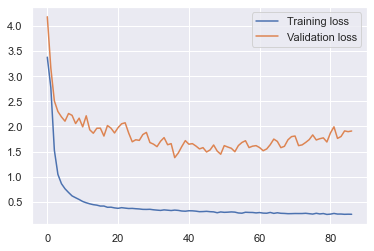

<Figure size 432x288 with 0 Axes>





Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_48 (LSTM)                 (None, 45, 24)       3744        ['input_17[0][0]']               
                                                                                                  
 dropout_32 (Dropout)           (None, 45, 24)       0           ['lstm_48[0][0]']                
                                                                                                  
 lstm_49 (LSTM)                 (None, 45, 16)       2624        ['dropout_32[0][0]']             
                                                                                       

65/66 [============================>.] - ETA: 0s - loss: 1.1159
Epoch 4: val_loss did not improve from 2.85726

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 5s 79ms/step - loss: 1.1155 - val_loss: 3.1413 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 0.8619
Epoch 5: val_loss did not improve from 2.85726

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==============================] - 5s 81ms/step - loss: 0.8619 - val_loss: 3.2063 - lr: 9.9000e-05
Epoch 6/1000
66/66 [==============================] - ETA: 0s - loss: 0.7661
Epoch 6: val_loss did not improve from 2.85726

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.702989402285311e-05.
66/66 [==============================] - 5s 80ms/step - loss: 0.7661 - val_loss: 3.1175 - lr: 9.8010e-05
Epoch 7/1000
66/66 [==============================] - ETA: 0s - loss: 0.7242
Epoch 7: val_loss 

66/66 [==============================] - 5s 76ms/step - loss: 0.4719 - val_loss: 2.1548 - lr: 8.1791e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4740
Epoch 30: val_loss did not improve from 2.03527

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.01630511705298e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.4727 - val_loss: 2.2077 - lr: 8.0973e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4730
Epoch 31: val_loss did not improve from 2.03527

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [==============================] - 5s 76ms/step - loss: 0.4737 - val_loss: 2.1918 - lr: 8.0163e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4574
Epoch 32: val_loss improved from 2.03527 to 1.94176, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.06.hdf5
66/66 [===================

66/66 [==============================] - 5s 75ms/step - loss: 0.3575 - val_loss: 2.3856 - lr: 4.8499e-05


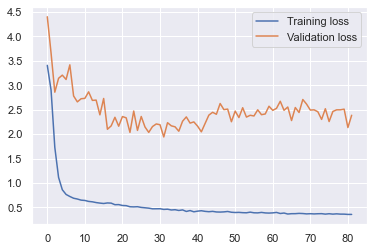

<Figure size 432x288 with 0 Axes>





Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_51 (LSTM)                 (None, 45, 24)       3744        ['input_18[0][0]']               
                                                                                                  
 dropout_34 (Dropout)           (None, 45, 24)       0           ['lstm_51[0][0]']                
                                                                                                  
 lstm_52 (LSTM)                 (None, 45, 16)       2624        ['dropout_34[0][0]']             
                                                                                       

66/66 [==============================] - 5s 77ms/step - loss: 0.5370 - val_loss: 2.2747 - lr: 8.9534e-05
Epoch 29/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5224
Epoch 29: val_loss improved from 2.27472 to 2.09983, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.07.hdf5
66/66 [==============================] - 5s 78ms/step - loss: 0.5221 - val_loss: 2.0998 - lr: 8.9534e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5325
Epoch 30: val_loss improved from 2.09983 to 2.08066, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.07.hdf5
66/66 [==============================] - 5s 78ms/step - loss: 0.5322 - val_loss: 2.0807 - lr: 8.9534e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5249
Epoch 31: val_loss improved from 2.08066 to 1.92966, saving model to C:\Users\Alex Lam\OneDrive\Documen

66/66 [==============================] - 5s 78ms/step - loss: 0.4619 - val_loss: 1.5277 - lr: 7.7782e-05
Epoch 54/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4764
Epoch 54: val_loss did not improve from 1.52774

Epoch 54: ReduceLROnPlateau reducing learning rate to 7.70043047668878e-05.
66/66 [==============================] - 5s 76ms/step - loss: 0.4767 - val_loss: 1.5813 - lr: 7.7782e-05
Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4700
Epoch 55: val_loss did not improve from 1.52774

Epoch 55: ReduceLROnPlateau reducing learning rate to 7.623426128702704e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.4717 - val_loss: 1.6579 - lr: 7.7004e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4618
Epoch 56: val_loss did not improve from 1.52774

Epoch 56: ReduceLROnPlateau reducing learning rate to 7.547191802586894e-05.
66/66 [==============================] - 5s 76ms/step - loss: 0.4614 - val

Epoch 80/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4306
Epoch 80: val_loss improved from 1.45427 to 1.41748, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.07.hdf5
66/66 [==============================] - 5s 77ms/step - loss: 0.4295 - val_loss: 1.4175 - lr: 6.1112e-05
Epoch 81/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4272
Epoch 81: val_loss did not improve from 1.41748

Epoch 81: ReduceLROnPlateau reducing learning rate to 6.0500582330860196e-05.
66/66 [==============================] - 5s 76ms/step - loss: 0.4302 - val_loss: 1.5010 - lr: 6.1112e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4207
Epoch 82: val_loss did not improve from 1.41748

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.9895574922848026e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.4186 - val_loss: 1.4258 - lr: 6.0501e-05
Epoch 83/1000
65/66 [==


Epoch 106: ReduceLROnPlateau reducing learning rate to 4.705864765128354e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.4060 - val_loss: 1.6593 - lr: 4.7534e-05
Epoch 107/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4117
Epoch 107: val_loss did not improve from 1.41748

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.658806272345828e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.4113 - val_loss: 1.5629 - lr: 4.7059e-05
Epoch 108/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4105
Epoch 108: val_loss did not improve from 1.41748

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.612218148395186e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.4094 - val_loss: 1.5993 - lr: 4.6588e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4194
Epoch 109: val_loss did not improve from 1.41748

Epoch 109: ReduceLROnPlateau reducing learning rate to 4.566096

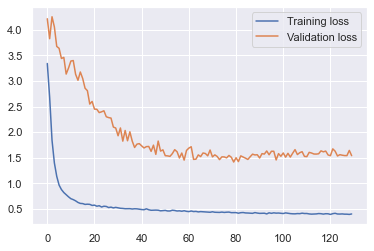

<Figure size 432x288 with 0 Axes>





Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_54 (LSTM)                 (None, 45, 24)       3744        ['input_19[0][0]']               
                                                                                                  
 dropout_36 (Dropout)           (None, 45, 24)       0           ['lstm_54[0][0]']                
                                                                                                  
 lstm_55 (LSTM)                 (None, 45, 16)       2624        ['dropout_36[0][0]']             
                                                                                       

65/66 [============================>.] - ETA: 0s - loss: 1.2357
Epoch 4: val_loss did not improve from 2.87321

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 5s 79ms/step - loss: 1.2355 - val_loss: 3.1526 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0329
Epoch 5: val_loss did not improve from 2.87321

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==============================] - 4s 61ms/step - loss: 1.0341 - val_loss: 3.1150 - lr: 9.9000e-05
Epoch 6/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9339
Epoch 6: val_loss did not improve from 2.87321

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.702989402285311e-05.
66/66 [==============================] - 4s 62ms/step - loss: 0.9321 - val_loss: 3.4627 - lr: 9.8010e-05
Epoch 7/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8783
Epoch 7: val_loss 

Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6163
Epoch 30: val_loss improved from 2.52322 to 2.36773, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.08.hdf5
66/66 [==============================] - 4s 65ms/step - loss: 0.6155 - val_loss: 2.3677 - lr: 8.0973e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6240
Epoch 31: val_loss did not improve from 2.36773

Epoch 31: ReduceLROnPlateau reducing learning rate to 8.01630511705298e-05.
66/66 [==============================] - 4s 64ms/step - loss: 0.6241 - val_loss: 2.4402 - lr: 8.0973e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6137
Epoch 32: val_loss did not improve from 2.36773

Epoch 32: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [==============================] - 4s 65ms/step - loss: 0.6131 - val_loss: 2.6943 - lr: 8.0163e-05
Epoch 33/1000
65/66 [=====

Epoch 81/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5327
Epoch 81: val_loss did not improve from 1.76032

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.471563996252371e-05.
66/66 [==============================] - 5s 71ms/step - loss: 0.5345 - val_loss: 1.8911 - lr: 5.5268e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5339
Epoch 82: val_loss improved from 1.76032 to 1.72135, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.08.hdf5
66/66 [==============================] - 5s 72ms/step - loss: 0.5318 - val_loss: 1.7214 - lr: 5.4716e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5372
Epoch 83: val_loss did not improve from 1.72135

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.416848503955407e-05.
66/66 [==============================] - 5s 70ms/step - loss: 0.5347 - val_loss: 1.8020 - lr: 5.4716e-05
Epoch 84/1000
65/66 [====

65/66 [============================>.] - ETA: 0s - loss: 0.5090
Epoch 133: val_loss did not improve from 1.67873

Epoch 133: ReduceLROnPlateau reducing learning rate to 3.3437677484471354e-05.
66/66 [==============================] - 5s 71ms/step - loss: 0.5096 - val_loss: 1.8781 - lr: 3.3775e-05
Epoch 134/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5127
Epoch 134: val_loss did not improve from 1.67873

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.310330142994644e-05.
66/66 [==============================] - 5s 71ms/step - loss: 0.5107 - val_loss: 1.8840 - lr: 3.3438e-05
Epoch 135/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5075
Epoch 135: val_loss did not improve from 1.67873

Epoch 135: ReduceLROnPlateau reducing learning rate to 3.277226765931118e-05.
66/66 [==============================] - 5s 71ms/step - loss: 0.5081 - val_loss: 1.8964 - lr: 3.3103e-05
Epoch 136/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5054


Epoch 159: ReduceLROnPlateau reducing learning rate to 2.5748449061211432e-05.
66/66 [==============================] - 5s 70ms/step - loss: 0.5028 - val_loss: 1.9745 - lr: 2.6009e-05
Epoch 160/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4939
Epoch 160: val_loss did not improve from 1.67873

Epoch 160: ReduceLROnPlateau reducing learning rate to 2.5490965344943107e-05.
66/66 [==============================] - 5s 70ms/step - loss: 0.4922 - val_loss: 2.0198 - lr: 2.5748e-05
Epoch 161/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4965
Epoch 161: val_loss did not improve from 1.67873

Epoch 161: ReduceLROnPlateau reducing learning rate to 2.523605497117387e-05.
66/66 [==============================] - 5s 70ms/step - loss: 0.4950 - val_loss: 1.8990 - lr: 2.5491e-05
Epoch 162/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4964
Epoch 162: val_loss did not improve from 1.67873

Epoch 162: ReduceLROnPlateau reducing learning rate to 2.4983

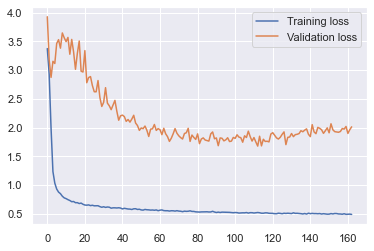

<Figure size 432x288 with 0 Axes>





Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_57 (LSTM)                 (None, 45, 24)       3744        ['input_20[0][0]']               
                                                                                                  
 dropout_38 (Dropout)           (None, 45, 24)       0           ['lstm_57[0][0]']                
                                                                                                  
 lstm_58 (LSTM)                 (None, 45, 16)       2624        ['dropout_38[0][0]']             
                                                                                       

66/66 [==============================] - 5s 78ms/step - loss: 0.6703 - val_loss: 2.4626 - lr: 8.1791e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6959
Epoch 30: val_loss improved from 2.46256 to 2.46182, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.09.hdf5
66/66 [==============================] - 5s 78ms/step - loss: 0.6953 - val_loss: 2.4618 - lr: 8.1791e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6668
Epoch 31: val_loss did not improve from 2.46182

Epoch 31: ReduceLROnPlateau reducing learning rate to 8.097277706838213e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6651 - val_loss: 2.5432 - lr: 8.1791e-05
Epoch 32/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6697
Epoch 32: val_loss did not improve from 2.46182

Epoch 32: ReduceLROnPlateau reducing learning rate to 8.01630511705298e-05.
66/66 [===================

66/66 [==============================] - 5s 79ms/step - loss: 0.6161 - val_loss: 2.0433 - lr: 6.7573e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6135
Epoch 56: val_loss did not improve from 2.04330

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.689715184620581e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6104 - val_loss: 2.2007 - lr: 6.7573e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6161
Epoch 57: val_loss did not improve from 2.04330

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.622818364121486e-05.
66/66 [==============================] - 5s 81ms/step - loss: 0.6166 - val_loss: 2.1012 - lr: 6.6897e-05
Epoch 58/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6055
Epoch 58: val_loss did not improve from 2.04330

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.55659000040032e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.6058 - val


Epoch 81: ReduceLROnPlateau reducing learning rate to 5.471563996252371e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.5779 - val_loss: 1.7679 - lr: 5.5268e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5842
Epoch 82: val_loss did not improve from 1.75209

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.416848503955407e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5846 - val_loss: 1.8261 - lr: 5.4716e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5793
Epoch 83: val_loss did not improve from 1.75209

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.362680094549433e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.5774 - val_loss: 1.8515 - lr: 5.4168e-05
Epoch 84/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5906
Epoch 84: val_loss did not improve from 1.75209

Epoch 84: ReduceLROnPlateau reducing learning rate to 5.309053365635918e


Epoch 133: ReduceLROnPlateau reducing learning rate to 3.37754318388761e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.5532 - val_loss: 1.7896 - lr: 3.4117e-05
Epoch 134/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5450
Epoch 134: val_loss did not improve from 1.69404

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.3437677484471354e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5468 - val_loss: 1.7576 - lr: 3.3775e-05
Epoch 135/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5466
Epoch 135: val_loss did not improve from 1.69404

Epoch 135: ReduceLROnPlateau reducing learning rate to 3.310330142994644e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.5464 - val_loss: 1.7761 - lr: 3.3438e-05
Epoch 136/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5475
Epoch 136: val_loss did not improve from 1.69404

Epoch 136: ReduceLROnPlateau reducing learning rate to 3.277226

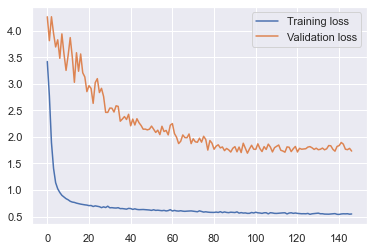

<Figure size 432x288 with 0 Axes>





Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_60 (LSTM)                 (None, 45, 24)       3744        ['input_21[0][0]']               
                                                                                                  
 dropout_40 (Dropout)           (None, 45, 24)       0           ['lstm_60[0][0]']                
                                                                                                  
 lstm_61 (LSTM)                 (None, 45, 16)       2624        ['dropout_40[0][0]']             
                                                                                       

66/66 [==============================] - 5s 77ms/step - loss: 2.9113 - val_loss: 3.0402 - lr: 1.0000e-04
Epoch 3/1000
65/66 [============================>.] - ETA: 0s - loss: 1.8449
Epoch 3: val_loss improved from 3.04017 to 2.50065, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 5s 79ms/step - loss: 1.8515 - val_loss: 2.5006 - lr: 1.0000e-04
Epoch 4/1000
65/66 [============================>.] - ETA: 0s - loss: 1.3564
Epoch 4: val_loss improved from 2.50065 to 2.22253, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 5s 78ms/step - loss: 1.3566 - val_loss: 2.2225 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.1651
Epoch 5: val_loss improved from 2.22253 to 2.03145, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demon

Epoch 26/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7528
Epoch 26: val_loss did not improve from 1.34260

Epoch 26: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.7508 - val_loss: 1.3484 - lr: 9.9000e-05
Epoch 27/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7174
Epoch 27: val_loss did not improve from 1.34260

Epoch 27: ReduceLROnPlateau reducing learning rate to 9.702989402285311e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.7187 - val_loss: 1.3426 - lr: 9.8010e-05
Epoch 28/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7298
Epoch 28: val_loss improved from 1.34260 to 1.31934, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 5s 78ms/step - loss: 0.7302 - val_loss: 1.3193 - lr: 9.7030e-05
Epoch 29/1000
65/66 [=====

66/66 [==============================] - 5s 77ms/step - loss: 0.6702 - val_loss: 1.2477 - lr: 8.8638e-05
Epoch 51/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6694
Epoch 51: val_loss improved from 1.24742 to 1.23520, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 5s 77ms/step - loss: 0.6684 - val_loss: 1.2352 - lr: 8.7752e-05
Epoch 52/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6713
Epoch 52: val_loss did not improve from 1.23520

Epoch 52: ReduceLROnPlateau reducing learning rate to 8.687458052008878e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6699 - val_loss: 1.2396 - lr: 8.7752e-05
Epoch 53/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6789
Epoch 53: val_loss did not improve from 1.23520

Epoch 53: ReduceLROnPlateau reducing learning rate to 8.600583161751274e-05.
66/66 [===================


Epoch 76: ReduceLROnPlateau reducing learning rate to 7.177303261414636e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6446 - val_loss: 1.2210 - lr: 7.2498e-05
Epoch 77/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6429
Epoch 77: val_loss did not improve from 1.21086

Epoch 77: ReduceLROnPlateau reducing learning rate to 7.105529875843786e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6435 - val_loss: 1.2156 - lr: 7.1773e-05
Epoch 78/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6454
Epoch 78: val_loss did not improve from 1.21086

Epoch 78: ReduceLROnPlateau reducing learning rate to 7.034474649117328e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6430 - val_loss: 1.2149 - lr: 7.1055e-05
Epoch 79/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6435
Epoch 79: val_loss did not improve from 1.21086

Epoch 79: ReduceLROnPlateau reducing learning rate to 6.964129657717422e

Epoch 102/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6158
Epoch 102: val_loss did not improve from 1.20240

Epoch 102: ReduceLROnPlateau reducing learning rate to 5.8703650938696225e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6141 - val_loss: 1.2118 - lr: 5.9297e-05
Epoch 103/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6178
Epoch 103: val_loss did not improve from 1.20240

Epoch 103: ReduceLROnPlateau reducing learning rate to 5.811661550978897e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6178 - val_loss: 1.2033 - lr: 5.8704e-05
Epoch 104/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6087
Epoch 104: val_loss did not improve from 1.20240

Epoch 104: ReduceLROnPlateau reducing learning rate to 5.753545068728272e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6087 - val_loss: 1.2072 - lr: 5.8117e-05
Epoch 105/1000
65/66 [============================>.] - ETA: 0s

Epoch 128/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6066
Epoch 128: val_loss improved from 1.19705 to 1.19168, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 5s 77ms/step - loss: 0.6074 - val_loss: 1.1917 - lr: 4.6588e-05
Epoch 129/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6102
Epoch 129: val_loss did not improve from 1.19168

Epoch 129: ReduceLROnPlateau reducing learning rate to 4.612218148395186e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6111 - val_loss: 1.1958 - lr: 4.6588e-05
Epoch 130/1000
65/66 [============================>.] - ETA: 0s - loss: 0.6067
Epoch 130: val_loss did not improve from 1.19168

Epoch 130: ReduceLROnPlateau reducing learning rate to 4.566096071357606e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.6061 - val_loss: 1.1969 - lr: 4.6122e-05
Epoch 131/1000
65/

Epoch 154/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5874
Epoch 154: val_loss did not improve from 1.18794

Epoch 154: ReduceLROnPlateau reducing learning rate to 3.660322370706126e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5865 - val_loss: 1.1887 - lr: 3.6973e-05
Epoch 155/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5907
Epoch 155: val_loss did not improve from 1.18794

Epoch 155: ReduceLROnPlateau reducing learning rate to 3.623719319875818e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5903 - val_loss: 1.1901 - lr: 3.6603e-05
Epoch 156/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5925
Epoch 156: val_loss did not improve from 1.18794

Epoch 156: ReduceLROnPlateau reducing learning rate to 3.5874821915058416e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.5919 - val_loss: 1.1907 - lr: 3.6237e-05
Epoch 157/1000
65/66 [============================>.] - ETA: 0s

66/66 [==============================] - 5s 77ms/step - loss: 0.5968 - val_loss: 1.1911 - lr: 3.0240e-05
Epoch 180/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5805
Epoch 180: val_loss did not improve from 1.17711

Epoch 180: ReduceLROnPlateau reducing learning rate to 2.963864781122538e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5845 - val_loss: 1.1812 - lr: 2.9938e-05
Epoch 181/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5800
Epoch 181: val_loss did not improve from 1.17711

Epoch 181: ReduceLROnPlateau reducing learning rate to 2.9342261423153105e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5791 - val_loss: 1.1931 - lr: 2.9639e-05
Epoch 182/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5772
Epoch 182: val_loss did not improve from 1.17711

Epoch 182: ReduceLROnPlateau reducing learning rate to 2.9048839151073478e-05.
66/66 [==============================] - 5s 77ms/step - loss: 

Epoch 206/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5848
Epoch 206: val_loss did not improve from 1.17655

Epoch 206: ReduceLROnPlateau reducing learning rate to 2.3053570603224217e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5855 - val_loss: 1.1773 - lr: 2.3286e-05
Epoch 207/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5846
Epoch 207: val_loss did not improve from 1.17655

Epoch 207: ReduceLROnPlateau reducing learning rate to 2.2823034050816205e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.5834 - val_loss: 1.1803 - lr: 2.3054e-05
Epoch 208/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5787
Epoch 208: val_loss did not improve from 1.17655

Epoch 208: ReduceLROnPlateau reducing learning rate to 2.2594804322579874e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5762 - val_loss: 1.1817 - lr: 2.2823e-05
Epoch 209/1000
65/66 [============================>.] - ETA: 

Epoch 232/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5737
Epoch 232: val_loss did not improve from 1.17175

Epoch 232: ReduceLROnPlateau reducing learning rate to 1.8112688176188387e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5734 - val_loss: 1.1820 - lr: 1.8296e-05
Epoch 233/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5826
Epoch 233: val_loss did not improve from 1.17175

Epoch 233: ReduceLROnPlateau reducing learning rate to 1.793156196072232e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5812 - val_loss: 1.1804 - lr: 1.8113e-05
Epoch 234/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5738
Epoch 234: val_loss did not improve from 1.17175

Epoch 234: ReduceLROnPlateau reducing learning rate to 1.775224554876331e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5763 - val_loss: 1.1789 - lr: 1.7932e-05
Epoch 235/1000
65/66 [============================>.] - ETA: 0s

65/66 [============================>.] - ETA: 0s - loss: 0.5835
Epoch 284: val_loss did not improve from 1.17082

Epoch 284: ReduceLROnPlateau reducing learning rate to 1.0848705051103024e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5837 - val_loss: 1.1746 - lr: 1.0958e-05
Epoch 285/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5692
Epoch 285: val_loss did not improve from 1.17082

Epoch 285: ReduceLROnPlateau reducing learning rate to 1.074021768545208e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5713 - val_loss: 1.1732 - lr: 1.0849e-05
Epoch 286/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5690
Epoch 286: val_loss did not improve from 1.17082

Epoch 286: ReduceLROnPlateau reducing learning rate to 1.0632815301505616e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.5719 - val_loss: 1.1736 - lr: 1.0740e-05
Epoch 287/1000
66/66 [==============================] - ETA: 0s - loss: 0.573

65/66 [============================>.] - ETA: 0s - loss: 0.5780
Epoch 310: val_loss did not improve from 1.17024

Epoch 310: ReduceLROnPlateau reducing learning rate to 8.523590158802108e-06.
66/66 [==============================] - 5s 74ms/step - loss: 0.5789 - val_loss: 1.1748 - lr: 8.6097e-06
Epoch 311/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5658
Epoch 311: val_loss did not improve from 1.17024

Epoch 311: ReduceLROnPlateau reducing learning rate to 8.438353816018208e-06.
66/66 [==============================] - 5s 73ms/step - loss: 0.5669 - val_loss: 1.1750 - lr: 8.5236e-06
Epoch 312/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5770
Epoch 312: val_loss did not improve from 1.17024

Epoch 312: ReduceLROnPlateau reducing learning rate to 8.35397015180206e-06.
66/66 [==============================] - 5s 73ms/step - loss: 0.5760 - val_loss: 1.1753 - lr: 8.4384e-06
Epoch 313/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5697
E


Epoch 336: ReduceLROnPlateau reducing learning rate to 6.563530191669997e-06.
66/66 [==============================] - 5s 73ms/step - loss: 0.5679 - val_loss: 1.1715 - lr: 6.6298e-06
Epoch 337/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5725
Epoch 337: val_loss did not improve from 1.17024

Epoch 337: ReduceLROnPlateau reducing learning rate to 6.4978951013472395e-06.
66/66 [==============================] - 5s 75ms/step - loss: 0.5715 - val_loss: 1.1743 - lr: 6.5635e-06
Epoch 338/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5746
Epoch 338: val_loss did not improve from 1.17024

Epoch 338: ReduceLROnPlateau reducing learning rate to 6.432915952245821e-06.
66/66 [==============================] - 5s 73ms/step - loss: 0.5727 - val_loss: 1.1744 - lr: 6.4979e-06


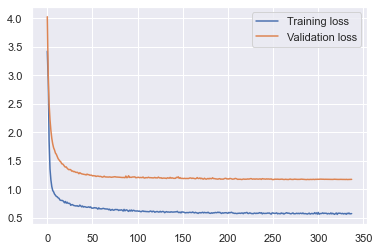

<Figure size 432x288 with 0 Axes>





Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_63 (LSTM)                 (None, 45, 24)       3744        ['input_22[0][0]']               
                                                                                                  
 dropout_42 (Dropout)           (None, 45, 24)       0           ['lstm_63[0][0]']                
                                                                                                  
 lstm_64 (LSTM)                 (None, 45, 16)       2624        ['dropout_42[0][0]']             
                                                                                       

66/66 [==============================] - 5s 75ms/step - loss: 2.6643 - val_loss: 3.0645 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.7102
Epoch 3: val_loss improved from 3.06452 to 2.83567, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.11.hdf5
66/66 [==============================] - 6s 85ms/step - loss: 1.7102 - val_loss: 2.8357 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.3663
Epoch 4: val_loss did not improve from 2.83567

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 5s 81ms/step - loss: 1.3663 - val_loss: 2.8539 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.2213
Epoch 5: val_loss did not improve from 2.83567

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==========================

66/66 [==============================] - 5s 79ms/step - loss: 0.8113 - val_loss: 1.8864 - lr: 8.6875e-05
Epoch 28/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7993
Epoch 28: val_loss did not improve from 1.88638

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.600583161751274e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.8026 - val_loss: 2.0734 - lr: 8.6875e-05
Epoch 29/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8265
Epoch 29: val_loss did not improve from 1.88638

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.514576977177058e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.8270 - val_loss: 2.1991 - lr: 8.6006e-05
Epoch 30/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8103
Epoch 30: val_loss did not improve from 1.88638

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.429430854448584e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.8094 - va

66/66 [==============================] - 5s 79ms/step - loss: 0.7549 - val_loss: 1.8710 - lr: 7.0345e-05
Epoch 54/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7424
Epoch 54: val_loss did not improve from 1.79759

Epoch 54: ReduceLROnPlateau reducing learning rate to 6.894488418765832e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.7405 - val_loss: 1.9824 - lr: 6.9641e-05
Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7389
Epoch 55: val_loss did not improve from 1.79759

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.82554372906452e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.7391 - val_loss: 1.8521 - lr: 6.8945e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7493
Epoch 56: val_loss improved from 1.79759 to 1.77790, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.11.hdf5
66/66 [===================

65/66 [============================>.] - ETA: 0s - loss: 0.7171
Epoch 80: val_loss did not improve from 1.77790

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.362680094549433e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.7171 - val_loss: 1.9267 - lr: 5.4168e-05
Epoch 81/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7018
Epoch 81: val_loss did not improve from 1.77790

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.309053365635918e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.7010 - val_loss: 1.9174 - lr: 5.3627e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7051
Epoch 82: val_loss did not improve from 1.77790

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.2559629148163366e-05.
66/66 [==============================] - 5s 77ms/step - loss: 0.7031 - val_loss: 1.9387 - lr: 5.3091e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7024
Epoch 83

66/66 [==============================] - 5s 78ms/step - loss: 0.6880 - val_loss: 1.8553 - lr: 4.1712e-05


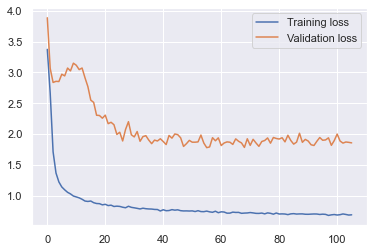

<Figure size 432x288 with 0 Axes>





Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_66 (LSTM)                 (None, 45, 24)       3744        ['input_23[0][0]']               
                                                                                                  
 dropout_44 (Dropout)           (None, 45, 24)       0           ['lstm_66[0][0]']                
                                                                                                  
 lstm_67 (LSTM)                 (None, 45, 16)       2624        ['dropout_44[0][0]']             
                                                                                       

66/66 [==============================] - 5s 80ms/step - loss: 2.7357 - val_loss: 3.5567 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.8334
Epoch 3: val_loss improved from 3.55674 to 3.23390, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.12.hdf5
66/66 [==============================] - 5s 83ms/step - loss: 1.8334 - val_loss: 3.2339 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.4930
Epoch 4: val_loss improved from 3.23390 to 2.99595, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.12.hdf5
66/66 [==============================] - 6s 90ms/step - loss: 1.4930 - val_loss: 2.9960 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.3352
Epoch 5: val_loss improved from 2.99595 to 2.82721, saving model to C:\Users\Alex Lam\OneDrive\Documents\Dem

Epoch 27/1000
66/66 [==============================] - ETA: 0s - loss: 0.8616
Epoch 27: val_loss did not improve from 1.90850

Epoch 27: ReduceLROnPlateau reducing learning rate to 9.043820427905303e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.8616 - val_loss: 1.9921 - lr: 9.1352e-05
Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 0.8460
Epoch 28: val_loss did not improve from 1.90850

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.953382115578279e-05.
66/66 [==============================] - 6s 96ms/step - loss: 0.8460 - val_loss: 1.9302 - lr: 9.0438e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.8478
Epoch 29: val_loss improved from 1.90850 to 1.85365, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.12.hdf5
66/66 [==============================] - 6s 98ms/step - loss: 0.8478 - val_loss: 1.8536 - lr: 8.9534e-05
Epoch 30/1000
66/66 [====

Epoch 53/1000
66/66 [==============================] - ETA: 0s - loss: 0.7745
Epoch 53: val_loss did not improve from 1.77853

Epoch 53: ReduceLROnPlateau reducing learning rate to 7.249801288708113e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.7745 - val_loss: 1.9690 - lr: 7.3230e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 0.7685
Epoch 54: val_loss did not improve from 1.77853

Epoch 54: ReduceLROnPlateau reducing learning rate to 7.177303261414636e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.7685 - val_loss: 1.9016 - lr: 7.2498e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.7720
Epoch 55: val_loss did not improve from 1.77853

Epoch 55: ReduceLROnPlateau reducing learning rate to 7.105529875843786e-05.
66/66 [==============================] - 6s 88ms/step - loss: 0.7720 - val_loss: 1.8770 - lr: 7.1773e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.

66/66 [==============================] - 6s 87ms/step - loss: 0.7437 - val_loss: 2.1716 - lr: 5.6390e-05
Epoch 80/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7322
Epoch 80: val_loss did not improve from 1.77853

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.526832333998754e-05.
66/66 [==============================] - 6s 85ms/step - loss: 0.7331 - val_loss: 2.0800 - lr: 5.5827e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.7356
Epoch 81: val_loss did not improve from 1.77853

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.471563996252371e-05.
66/66 [==============================] - 6s 86ms/step - loss: 0.7356 - val_loss: 2.0721 - lr: 5.5268e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.7479
Epoch 82: val_loss did not improve from 1.77853

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.416848503955407e-05.
66/66 [==============================] - 6s 87ms/step - loss: 0.7479 - va

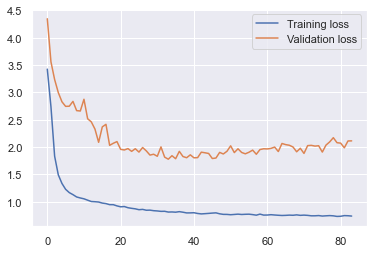

<Figure size 432x288 with 0 Axes>





Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_69 (LSTM)                 (None, 45, 24)       3744        ['input_24[0][0]']               
                                                                                                  
 dropout_46 (Dropout)           (None, 45, 24)       0           ['lstm_69[0][0]']                
                                                                                                  
 lstm_70 (LSTM)                 (None, 45, 16)       2624        ['dropout_46[0][0]']             
                                                                                       

66/66 [==============================] - 5s 83ms/step - loss: 2.9718 - val_loss: 3.9821 - lr: 1.0000e-04
Epoch 3/1000
65/66 [============================>.] - ETA: 0s - loss: 2.0493
Epoch 3: val_loss improved from 3.98210 to 2.92940, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.13.hdf5
66/66 [==============================] - 5s 79ms/step - loss: 2.0473 - val_loss: 2.9294 - lr: 1.0000e-04
Epoch 4/1000
65/66 [============================>.] - ETA: 0s - loss: 1.5240
Epoch 4: val_loss improved from 2.92940 to 2.44254, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.13.hdf5
66/66 [==============================] - 5s 82ms/step - loss: 1.5244 - val_loss: 2.4425 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.3065
Epoch 5: val_loss did not improve from 2.44254

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.89999

66/66 [==============================] - 6s 88ms/step - loss: 0.9038 - val_loss: 2.6859 - lr: 8.1791e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.9137
Epoch 29: val_loss did not improve from 2.34413

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.01630511705298e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.9137 - val_loss: 2.3793 - lr: 8.0973e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.9029
Epoch 30: val_loss did not improve from 2.34413

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [==============================] - 7s 101ms/step - loss: 0.9029 - val_loss: 2.3791 - lr: 8.0163e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 0.9024
Epoch 31: val_loss did not improve from 2.34413

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.8567809323431e-05.
66/66 [==============================] - 8s 121ms/step - loss: 0.9024 - val

Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8501
Epoch 55: val_loss improved from 2.13314 to 2.09333, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.13.hdf5
66/66 [==============================] - 5s 81ms/step - loss: 0.8493 - val_loss: 2.0933 - lr: 6.4261e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8315
Epoch 56: val_loss did not improve from 2.09333

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.361852982081473e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.8322 - val_loss: 2.4045 - lr: 6.4261e-05
Epoch 57/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8508
Epoch 57: val_loss did not improve from 2.09333

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.298234337009489e-05.
66/66 [==============================] - 5s 78ms/step - loss: 0.8488 - val_loss: 2.3331 - lr: 6.3619e-05
Epoch 58/1000
65/66 [====

Epoch 81/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8164
Epoch 81: val_loss did not improve from 2.00076

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.1513692378648555e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.8180 - val_loss: 2.0532 - lr: 5.2034e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8147
Epoch 82: val_loss did not improve from 2.00076

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.099855567095801e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.8142 - val_loss: 2.0016 - lr: 5.1514e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8087
Epoch 83: val_loss did not improve from 2.00076

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.048856924986467e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.8107 - val_loss: 2.2378 - lr: 5.0999e-05
Epoch 84/1000
65/66 [============================>.] - ETA: 0s - loss: 0

66/66 [==============================] - 5s 79ms/step - loss: 0.8062 - val_loss: 2.0659 - lr: 4.0068e-05
Epoch 108/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7883
Epoch 108: val_loss did not improve from 2.00076

Epoch 108: ReduceLROnPlateau reducing learning rate to 3.927109017240582e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.7893 - val_loss: 2.0470 - lr: 3.9668e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7877
Epoch 109: val_loss did not improve from 2.00076

Epoch 109: ReduceLROnPlateau reducing learning rate to 3.887837901856983e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.7868 - val_loss: 2.0410 - lr: 3.9271e-05
Epoch 110/1000
65/66 [============================>.] - ETA: 0s - loss: 0.7889
Epoch 110: val_loss did not improve from 2.00076

Epoch 110: ReduceLROnPlateau reducing learning rate to 3.848959360766457e-05.
66/66 [==============================] - 5s 79ms/step - loss: 0.

Epoch 134/1000
66/66 [==============================] - ETA: 0s - loss: 0.7840
Epoch 134: val_loss did not improve from 1.98219

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.054589240491623e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.7840 - val_loss: 2.0195 - lr: 3.0854e-05
Epoch 135/1000
66/66 [==============================] - ETA: 0s - loss: 0.7816
Epoch 135: val_loss did not improve from 1.98219

Epoch 135: ReduceLROnPlateau reducing learning rate to 3.024043358891504e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.7816 - val_loss: 2.0148 - lr: 3.0546e-05
Epoch 136/1000
66/66 [==============================] - ETA: 0s - loss: 0.7807
Epoch 136: val_loss did not improve from 1.98219

Epoch 136: ReduceLROnPlateau reducing learning rate to 2.9938028928881975e-05.
66/66 [==============================] - 6s 92ms/step - loss: 0.7807 - val_loss: 2.0557 - lr: 3.0240e-05
Epoch 137/1000
66/66 [==============================] - ETA: 0s

66/66 [==============================] - ETA: 0s - loss: 0.7689
Epoch 186: val_loss did not improve from 1.96693

Epoch 186: ReduceLROnPlateau reducing learning rate to 1.8295644003956113e-05.
66/66 [==============================] - 6s 92ms/step - loss: 0.7689 - val_loss: 2.0973 - lr: 1.8480e-05
Epoch 187/1000
66/66 [==============================] - ETA: 0s - loss: 0.7664
Epoch 187: val_loss did not improve from 1.96693

Epoch 187: ReduceLROnPlateau reducing learning rate to 1.8112688176188387e-05.
66/66 [==============================] - 6s 93ms/step - loss: 0.7664 - val_loss: 2.0963 - lr: 1.8296e-05
Epoch 188/1000
66/66 [==============================] - ETA: 0s - loss: 0.7544
Epoch 188: val_loss did not improve from 1.96693

Epoch 188: ReduceLROnPlateau reducing learning rate to 1.793156196072232e-05.
66/66 [==============================] - 7s 100ms/step - loss: 0.7544 - val_loss: 2.1498 - lr: 1.8113e-05
Epoch 189/1000
65/66 [============================>.] - ETA: 0s - loss: 0.76

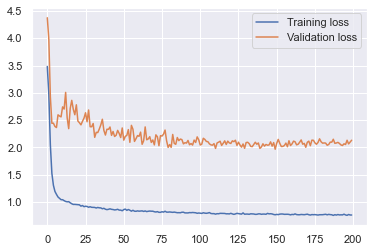

<Figure size 432x288 with 0 Axes>





Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_72 (LSTM)                 (None, 45, 24)       3744        ['input_25[0][0]']               
                                                                                                  
 dropout_48 (Dropout)           (None, 45, 24)       0           ['lstm_72[0][0]']                
                                                                                                  
 lstm_73 (LSTM)                 (None, 45, 16)       2624        ['dropout_48[0][0]']             
                                                                                       

66/66 [==============================] - 6s 84ms/step - loss: 2.9014 - val_loss: 4.1021 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 2.0559
Epoch 3: val_loss improved from 4.10206 to 3.33954, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 6s 85ms/step - loss: 2.0559 - val_loss: 3.3395 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.7038
Epoch 4: val_loss improved from 3.33954 to 2.93465, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 6s 86ms/step - loss: 1.7038 - val_loss: 2.9347 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.5077
Epoch 5: val_loss improved from 2.93465 to 2.77192, saving model to C:\Users\Alex Lam\OneDrive\Documents\Dem


Epoch 27: ReduceLROnPlateau reducing learning rate to 8.775210291787516e-05.
66/66 [==============================] - 5s 83ms/step - loss: 0.9319 - val_loss: 2.1589 - lr: 8.8638e-05
Epoch 28/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9369
Epoch 28: val_loss did not improve from 2.06461

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.687458052008878e-05.
66/66 [==============================] - 5s 82ms/step - loss: 0.9350 - val_loss: 2.2642 - lr: 8.7752e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.9235
Epoch 29: val_loss did not improve from 2.06461

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.600583161751274e-05.
66/66 [==============================] - 6s 84ms/step - loss: 0.9235 - val_loss: 2.3550 - lr: 8.6875e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.9262
Epoch 30: val_loss did not improve from 2.06461

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.514576977177058e

66/66 [==============================] - 6s 86ms/step - loss: 0.8770 - val_loss: 2.0966 - lr: 6.9641e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 0.8807
Epoch 54: val_loss did not improve from 2.04122

Epoch 54: ReduceLROnPlateau reducing learning rate to 6.82554372906452e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.8807 - val_loss: 2.1375 - lr: 6.8945e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.8733
Epoch 55: val_loss did not improve from 2.04122

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.75728838541545e-05.
66/66 [==============================] - 6s 87ms/step - loss: 0.8733 - val_loss: 2.1550 - lr: 6.8255e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.8803
Epoch 56: val_loss did not improve from 2.04122

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.689715184620581e-05.
66/66 [==============================] - 6s 87ms/step - loss: 0.8803 - val_

66/66 [==============================] - ETA: 0s - loss: 0.8584
Epoch 80: val_loss did not improve from 1.99925

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.309053365635918e-05.
66/66 [==============================] - 5s 83ms/step - loss: 0.8584 - val_loss: 2.1774 - lr: 5.3627e-05
Epoch 81/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8578
Epoch 81: val_loss did not improve from 1.99925

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.2559629148163366e-05.
66/66 [==============================] - 6s 84ms/step - loss: 0.8567 - val_loss: 2.1655 - lr: 5.3091e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8625
Epoch 82: val_loss did not improve from 1.99925

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.2034033396921584e-05.
66/66 [==============================] - 6s 85ms/step - loss: 0.8608 - val_loss: 2.1468 - lr: 5.2560e-05
Epoch 83/1000
66/66 [==============================] - ETA: 0s - loss: 0.8456
Epoch 8

66/66 [==============================] - 5s 81ms/step - loss: 0.8332 - val_loss: 2.0661 - lr: 4.1295e-05
Epoch 107/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8420
Epoch 107: val_loss did not improve from 1.99925

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.0473185072187336e-05.
66/66 [==============================] - 5s 82ms/step - loss: 0.8429 - val_loss: 2.0913 - lr: 4.0882e-05
Epoch 108/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8420
Epoch 108: val_loss did not improve from 1.99925

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.0068451780825854e-05.
66/66 [==============================] - 5s 81ms/step - loss: 0.8390 - val_loss: 2.0564 - lr: 4.0473e-05
Epoch 109/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8374
Epoch 109: val_loss did not improve from 1.99925

Epoch 109: ReduceLROnPlateau reducing learning rate to 3.966776668676175e-05.
66/66 [==============================] - 5s 82ms/step - loss: 

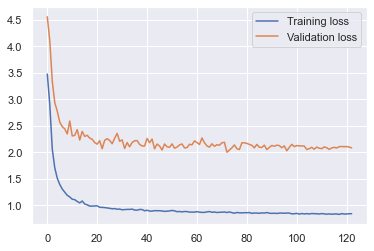

<Figure size 432x288 with 0 Axes>





Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_75 (LSTM)                 (None, 45, 24)       3744        ['input_26[0][0]']               
                                                                                                  
 dropout_50 (Dropout)           (None, 45, 24)       0           ['lstm_75[0][0]']                
                                                                                                  
 lstm_76 (LSTM)                 (None, 45, 16)       2624        ['dropout_50[0][0]']             
                                                                                       

66/66 [==============================] - 6s 83ms/step - loss: 2.7253 - val_loss: 3.5153 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.8363
Epoch 3: val_loss improved from 3.51526 to 2.87570, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 6s 92ms/step - loss: 1.8363 - val_loss: 2.8757 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.4996
Epoch 4: val_loss improved from 2.87570 to 2.59471, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 6s 91ms/step - loss: 1.4996 - val_loss: 2.5947 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.3473
Epoch 5: val_loss improved from 2.59471 to 2.47806, saving model to C:\Users\Alex Lam\OneDrive\Documents\Dem

66/66 [==============================] - 6s 89ms/step - loss: 0.9978 - val_loss: 1.9858 - lr: 8.7752e-05
Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 1.0031
Epoch 28: val_loss did not improve from 1.96232

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.600583161751274e-05.
66/66 [==============================] - 6s 89ms/step - loss: 1.0031 - val_loss: 2.1366 - lr: 8.6875e-05
Epoch 29/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9986
Epoch 29: val_loss improved from 1.96232 to 1.86507, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 6s 88ms/step - loss: 0.9978 - val_loss: 1.8651 - lr: 8.6006e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.9782
Epoch 30: val_loss did not improve from 1.86507

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.514576977177058e-05.
66/66 [==================

66/66 [==============================] - 6s 89ms/step - loss: 0.9252 - val_loss: 1.8268 - lr: 7.1055e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 0.9305
Epoch 54: val_loss did not improve from 1.78399

Epoch 54: ReduceLROnPlateau reducing learning rate to 6.964129657717422e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.9305 - val_loss: 1.8152 - lr: 7.0345e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.9171
Epoch 55: val_loss improved from 1.78399 to 1.78368, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 6s 90ms/step - loss: 0.9171 - val_loss: 1.7837 - lr: 6.9641e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.9107
Epoch 56: val_loss did not improve from 1.78368

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.894488418765832e-05.
66/66 [==================

66/66 [==============================] - ETA: 0s - loss: 0.9050
Epoch 80: val_loss did not improve from 1.78368

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.416848503955407e-05.
66/66 [==============================] - 6s 89ms/step - loss: 0.9050 - val_loss: 1.8768 - lr: 5.4716e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.8865
Epoch 81: val_loss did not improve from 1.78368

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.362680094549433e-05.
66/66 [==============================] - 6s 89ms/step - loss: 0.8865 - val_loss: 1.9682 - lr: 5.4168e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.8889
Epoch 82: val_loss did not improve from 1.78368

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.309053365635918e-05.
66/66 [==============================] - 6s 88ms/step - loss: 0.8878 - val_loss: 1.9726 - lr: 5.3627e-05
Epoch 83/1000
66/66 [==============================] - ETA: 0s - loss: 0.8839
Epoch 83:

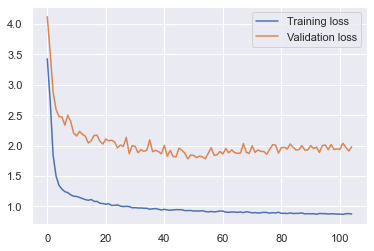

<Figure size 432x288 with 0 Axes>





Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_78 (LSTM)                 (None, 45, 24)       3744        ['input_27[0][0]']               
                                                                                                  
 dropout_52 (Dropout)           (None, 45, 24)       0           ['lstm_78[0][0]']                
                                                                                                  
 lstm_79 (LSTM)                 (None, 45, 16)       2624        ['dropout_52[0][0]']             
                                                                                       

66/66 [==============================] - 6s 85ms/step - loss: 3.1092 - val_loss: 3.3833 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 2.0431
Epoch 3: val_loss improved from 3.38327 to 3.08166, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 6s 91ms/step - loss: 2.0431 - val_loss: 3.0817 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.5676
Epoch 4: val_loss improved from 3.08166 to 2.96282, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 6s 92ms/step - loss: 1.5676 - val_loss: 2.9628 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.4266
Epoch 5: val_loss did not improve from 2.96282

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.89999

66/66 [==============================] - 6s 94ms/step - loss: 1.0059 - val_loss: 2.1478 - lr: 8.7752e-05
Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 0.9886
Epoch 28: val_loss did not improve from 2.14782

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.687458052008878e-05.
66/66 [==============================] - 6s 93ms/step - loss: 0.9886 - val_loss: 2.2302 - lr: 8.7752e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.9944
Epoch 29: val_loss did not improve from 2.14782

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.600583161751274e-05.
66/66 [==============================] - 6s 92ms/step - loss: 0.9944 - val_loss: 2.1649 - lr: 8.6875e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.9985
Epoch 30: val_loss improved from 2.14782 to 2.12904, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.16.hdf5
66/66 [==================


Epoch 79: ReduceLROnPlateau reducing learning rate to 5.639049515593797e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.8891 - val_loss: 1.8978 - lr: 5.6960e-05
Epoch 80/1000
66/66 [==============================] - ETA: 0s - loss: 0.9035
Epoch 80: val_loss did not improve from 1.80047

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.5826589195930865e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.9035 - val_loss: 1.8943 - lr: 5.6390e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.9037
Epoch 81: val_loss did not improve from 1.80047

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.526832333998754e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.9037 - val_loss: 1.8030 - lr: 5.5827e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.8954
Epoch 82: val_loss did not improve from 1.80047

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.471563996252371

Epoch 106/1000
66/66 [==============================] - ETA: 0s - loss: 0.8844
Epoch 106: val_loss did not improve from 1.76961

Epoch 106: ReduceLROnPlateau reducing learning rate to 4.342311796790454e-05.
66/66 [==============================] - 6s 92ms/step - loss: 0.8844 - val_loss: 1.9322 - lr: 4.3862e-05
Epoch 107/1000
66/66 [==============================] - ETA: 0s - loss: 0.8668
Epoch 107: val_loss did not improve from 1.76961

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.298888758057728e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.8668 - val_loss: 1.8883 - lr: 4.3423e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.8877
Epoch 108: val_loss did not improve from 1.76961

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.2558997120067946e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.8877 - val_loss: 1.8280 - lr: 4.2989e-05
Epoch 109/1000
66/66 [==============================] - ETA: 0s

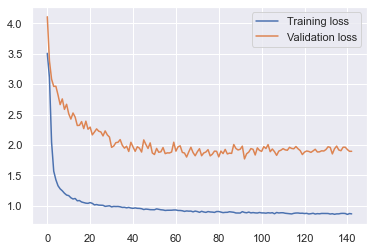

<Figure size 432x288 with 0 Axes>





Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_81 (LSTM)                 (None, 45, 24)       3744        ['input_28[0][0]']               
                                                                                                  
 dropout_54 (Dropout)           (None, 45, 24)       0           ['lstm_81[0][0]']                
                                                                                                  
 lstm_82 (LSTM)                 (None, 45, 16)       2624        ['dropout_54[0][0]']             
                                                                                       

66/66 [==============================] - 6s 92ms/step - loss: 2.8123 - val_loss: 3.4375 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.9174
Epoch 3: val_loss improved from 3.43746 to 3.07697, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.17.hdf5
66/66 [==============================] - 6s 95ms/step - loss: 1.9174 - val_loss: 3.0770 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.6515
Epoch 4: val_loss improved from 3.07697 to 2.91752, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.17.hdf5
66/66 [==============================] - 6s 97ms/step - loss: 1.6515 - val_loss: 2.9175 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.5317
Epoch 5: val_loss did not improve from 2.91752

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.89999

Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 1.0575
Epoch 29: val_loss did not improve from 2.91752

Epoch 29: ReduceLROnPlateau reducing learning rate to 7.778212770062965e-05.
66/66 [==============================] - 7s 99ms/step - loss: 1.0575 - val_loss: 3.7858 - lr: 7.8568e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 1.0687
Epoch 30: val_loss did not improve from 2.91752

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.70043047668878e-05.
66/66 [==============================] - 6s 96ms/step - loss: 1.0687 - val_loss: 3.4910 - lr: 7.7782e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 1.0506
Epoch 31: val_loss did not improve from 2.91752

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.623426128702704e-05.
66/66 [==============================] - 6s 94ms/step - loss: 1.0506 - val_loss: 3.4950 - lr: 7.7004e-05
Epoch 32/1000
66/66 [==============================] - ETA: 0s - loss: 1.0

Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.9629
Epoch 81: val_loss did not improve from 2.41899

Epoch 81: ReduceLROnPlateau reducing learning rate to 4.998368269298226e-05.
66/66 [==============================] - 6s 94ms/step - loss: 0.9629 - val_loss: 2.5864 - lr: 5.0489e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.9566
Epoch 82: val_loss did not improve from 2.41899

Epoch 82: ReduceLROnPlateau reducing learning rate to 4.9483845577924514e-05.
66/66 [==============================] - 6s 94ms/step - loss: 0.9566 - val_loss: 2.6964 - lr: 4.9984e-05
Epoch 83/1000
66/66 [==============================] - ETA: 0s - loss: 0.9636
Epoch 83: val_loss did not improve from 2.41899

Epoch 83: ReduceLROnPlateau reducing learning rate to 4.898900748230517e-05.
66/66 [==============================] - 6s 98ms/step - loss: 0.9636 - val_loss: 2.5247 - lr: 4.9484e-05
Epoch 84/1000
66/66 [==============================] - ETA: 0s - loss: 0

66/66 [==============================] - 6s 95ms/step - loss: 0.9407 - val_loss: 2.6242 - lr: 3.8878e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.9407
Epoch 108: val_loss did not improve from 2.41899

Epoch 108: ReduceLROnPlateau reducing learning rate to 3.810469792369986e-05.
66/66 [==============================] - 6s 93ms/step - loss: 0.9407 - val_loss: 2.5491 - lr: 3.8490e-05
Epoch 109/1000
66/66 [==============================] - ETA: 0s - loss: 0.9396
Epoch 109: val_loss did not improve from 2.41899

Epoch 109: ReduceLROnPlateau reducing learning rate to 3.772365234908648e-05.
66/66 [==============================] - 6s 95ms/step - loss: 0.9396 - val_loss: 2.5752 - lr: 3.8105e-05
Epoch 110/1000
66/66 [==============================] - ETA: 0s - loss: 0.9289
Epoch 110: val_loss did not improve from 2.41899

Epoch 110: ReduceLROnPlateau reducing learning rate to 3.734641726623522e-05.
66/66 [==============================] - 6s 96ms/step - loss: 0.

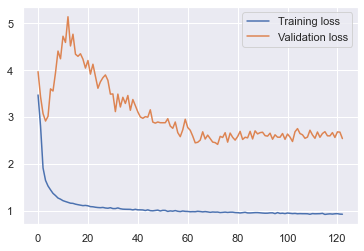

<Figure size 432x288 with 0 Axes>





Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_84 (LSTM)                 (None, 45, 24)       3744        ['input_29[0][0]']               
                                                                                                  
 dropout_56 (Dropout)           (None, 45, 24)       0           ['lstm_84[0][0]']                
                                                                                                  
 lstm_85 (LSTM)                 (None, 45, 16)       2624        ['dropout_56[0][0]']             
                                                                                       

66/66 [==============================] - 5s 83ms/step - loss: 2.7442 - val_loss: 3.8111 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 2.0106
Epoch 3: val_loss improved from 3.81111 to 3.47115, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.18.hdf5
66/66 [==============================] - 6s 90ms/step - loss: 2.0106 - val_loss: 3.4712 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.6661
Epoch 4: val_loss did not improve from 3.47115

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 6s 89ms/step - loss: 1.6661 - val_loss: 4.2312 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.4946
Epoch 5: val_loss did not improve from 3.47115

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==========================

66/66 [==============================] - 6s 87ms/step - loss: 1.0852 - val_loss: 2.1187 - lr: 8.7752e-05
Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 1.0739
Epoch 28: val_loss improved from 2.11869 to 2.11322, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.18.hdf5
66/66 [==============================] - 6s 88ms/step - loss: 1.0739 - val_loss: 2.1132 - lr: 8.7752e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 1.0708
Epoch 29: val_loss did not improve from 2.11322

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.687458052008878e-05.
66/66 [==============================] - 6s 87ms/step - loss: 1.0708 - val_loss: 2.2382 - lr: 8.7752e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 1.0519
Epoch 30: val_loss improved from 2.11322 to 2.05172, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23

66/66 [==============================] - 6s 88ms/step - loss: 1.0007 - val_loss: 1.8563 - lr: 7.1055e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 1.0120
Epoch 54: val_loss did not improve from 1.85635

Epoch 54: ReduceLROnPlateau reducing learning rate to 7.034474649117328e-05.
66/66 [==============================] - 6s 87ms/step - loss: 1.0120 - val_loss: 1.9151 - lr: 7.1055e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 1.0039
Epoch 55: val_loss improved from 1.85635 to 1.82823, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.18.hdf5
66/66 [==============================] - 6s 87ms/step - loss: 1.0039 - val_loss: 1.8282 - lr: 7.0345e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.9983
Epoch 56: val_loss did not improve from 1.82823

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.964129657717422e-05.
66/66 [==================

66/66 [==============================] - ETA: 0s - loss: 0.9581
Epoch 105: val_loss did not improve from 1.66821

Epoch 105: ReduceLROnPlateau reducing learning rate to 4.612218148395186e-05.
66/66 [==============================] - 6s 87ms/step - loss: 0.9581 - val_loss: 1.7495 - lr: 4.6588e-05
Epoch 106/1000
66/66 [==============================] - ETA: 0s - loss: 0.9583
Epoch 106: val_loss did not improve from 1.66821

Epoch 106: ReduceLROnPlateau reducing learning rate to 4.566096071357606e-05.
66/66 [==============================] - 6s 88ms/step - loss: 0.9583 - val_loss: 1.6878 - lr: 4.6122e-05
Epoch 107/1000
66/66 [==============================] - ETA: 0s - loss: 0.9593
Epoch 107: val_loss did not improve from 1.66821

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.52043499899446e-05.
66/66 [==============================] - 6s 89ms/step - loss: 0.9593 - val_loss: 1.6809 - lr: 4.5661e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.9615
E


Epoch 131: ReduceLROnPlateau reducing learning rate to 3.551607383997179e-05.
66/66 [==============================] - 6s 86ms/step - loss: 0.9460 - val_loss: 1.7255 - lr: 3.5875e-05
Epoch 132/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9431
Epoch 132: val_loss did not improve from 1.66821

Epoch 132: ReduceLROnPlateau reducing learning rate to 3.516091295750812e-05.
66/66 [==============================] - 6s 85ms/step - loss: 0.9406 - val_loss: 1.6996 - lr: 3.5516e-05
Epoch 133/1000
66/66 [==============================] - ETA: 0s - loss: 0.9347
Epoch 133: val_loss did not improve from 1.66821

Epoch 133: ReduceLROnPlateau reducing learning rate to 3.480930325167719e-05.
66/66 [==============================] - 6s 88ms/step - loss: 0.9347 - val_loss: 1.7050 - lr: 3.5161e-05
Epoch 134/1000
66/66 [==============================] - ETA: 0s - loss: 0.9513
Epoch 134: val_loss did not improve from 1.66821

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.446120

66/66 [==============================] - 6s 86ms/step - loss: 0.9370 - val_loss: 1.7645 - lr: 2.7904e-05
Epoch 158/1000
66/66 [==============================] - ETA: 0s - loss: 0.9359
Epoch 158: val_loss did not improve from 1.66622

Epoch 158: ReduceLROnPlateau reducing learning rate to 2.734890422289027e-05.
66/66 [==============================] - 6s 87ms/step - loss: 0.9359 - val_loss: 1.7221 - lr: 2.7625e-05
Epoch 159/1000
66/66 [==============================] - ETA: 0s - loss: 0.9350
Epoch 159: val_loss did not improve from 1.66622

Epoch 159: ReduceLROnPlateau reducing learning rate to 2.7075415000581416e-05.
66/66 [==============================] - 6s 88ms/step - loss: 0.9350 - val_loss: 1.7408 - lr: 2.7349e-05
Epoch 160/1000
66/66 [==============================] - ETA: 0s - loss: 0.9365
Epoch 160: val_loss did not improve from 1.66622

Epoch 160: ReduceLROnPlateau reducing learning rate to 2.6804661192727508e-05.
66/66 [==============================] - 6s 86ms/step - loss: 

Epoch 184/1000
66/66 [==============================] - ETA: 0s - loss: 0.9212
Epoch 184: val_loss did not improve from 1.66622

Epoch 184: ReduceLROnPlateau reducing learning rate to 2.1059835235064383e-05.
66/66 [==============================] - 6s 86ms/step - loss: 0.9212 - val_loss: 1.7245 - lr: 2.1273e-05
Epoch 185/1000
66/66 [==============================] - ETA: 0s - loss: 0.9297
Epoch 185: val_loss did not improve from 1.66622

Epoch 185: ReduceLROnPlateau reducing learning rate to 2.084923713482567e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.9297 - val_loss: 1.7674 - lr: 2.1060e-05
Epoch 186/1000
66/66 [==============================] - ETA: 0s - loss: 0.9346
Epoch 186: val_loss did not improve from 1.66622

Epoch 186: ReduceLROnPlateau reducing learning rate to 2.0640744169213575e-05.
66/66 [==============================] - 6s 87ms/step - loss: 0.9346 - val_loss: 1.7315 - lr: 2.0849e-05
Epoch 187/1000
66/66 [==============================] - ETA: 0

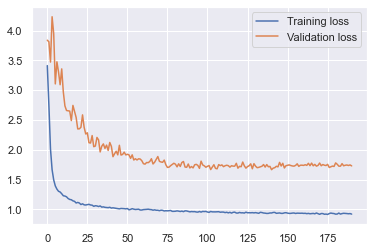

<Figure size 432x288 with 0 Axes>





Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_87 (LSTM)                 (None, 45, 24)       3744        ['input_30[0][0]']               
                                                                                                  
 dropout_58 (Dropout)           (None, 45, 24)       0           ['lstm_87[0][0]']                
                                                                                                  
 lstm_88 (LSTM)                 (None, 45, 16)       2624        ['dropout_58[0][0]']             
                                                                                       

Epoch 3/1000
65/66 [============================>.] - ETA: 0s - loss: 1.9526
Epoch 3: val_loss did not improve from 3.95743

Epoch 3: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==============================] - 6s 85ms/step - loss: 1.9487 - val_loss: 4.1803 - lr: 9.9000e-05
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.6182
Epoch 4: val_loss improved from 3.95743 to 3.63808, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.19.hdf5
66/66 [==============================] - 6s 92ms/step - loss: 1.6182 - val_loss: 3.6381 - lr: 9.8010e-05
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.4995
Epoch 5: val_loss did not improve from 3.63808

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.702989402285311e-05.
66/66 [==============================] - 6s 95ms/step - loss: 1.4995 - val_loss: 3.8451 - lr: 9.8010e-05
Epoch 6/1000
66/66 [=============


Epoch 28: ReduceLROnPlateau reducing learning rate to 8.261685659817886e-05.
66/66 [==============================] - 6s 93ms/step - loss: 1.1204 - val_loss: 2.9707 - lr: 8.3451e-05
Epoch 29/1000
65/66 [============================>.] - ETA: 0s - loss: 1.1152
Epoch 29: val_loss did not improve from 2.85490

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.179068579920567e-05.
66/66 [==============================] - 6s 92ms/step - loss: 1.1126 - val_loss: 3.0415 - lr: 8.2617e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 1.1146
Epoch 30: val_loss improved from 2.85490 to 2.73360, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.19.hdf5
66/66 [==============================] - 6s 93ms/step - loss: 1.1146 - val_loss: 2.7336 - lr: 8.1791e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 1.1119
Epoch 31: val_loss improved from 2.73360 to 2.70003, saving model to C:\U

66/66 [==============================] - 6s 95ms/step - loss: 1.0626 - val_loss: 2.3358 - lr: 7.1773e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 1.0616
Epoch 54: val_loss did not improve from 2.33579

Epoch 54: ReduceLROnPlateau reducing learning rate to 7.105529875843786e-05.
66/66 [==============================] - 6s 94ms/step - loss: 1.0616 - val_loss: 2.3984 - lr: 7.1773e-05
Epoch 55/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0591
Epoch 55: val_loss did not improve from 2.33579

Epoch 55: ReduceLROnPlateau reducing learning rate to 7.034474649117328e-05.
66/66 [==============================] - 6s 93ms/step - loss: 1.0591 - val_loss: 2.3774 - lr: 7.1055e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 1.0576
Epoch 56: val_loss did not improve from 2.33579

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.964129657717422e-05.
66/66 [==============================] - 6s 93ms/step - loss: 1.0576 - va

Epoch 80/1000
66/66 [==============================] - ETA: 0s - loss: 1.0289
Epoch 80: val_loss did not improve from 2.05258

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.639049515593797e-05.
66/66 [==============================] - 6s 92ms/step - loss: 1.0289 - val_loss: 2.0759 - lr: 5.6960e-05
Epoch 81/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0446
Epoch 81: val_loss did not improve from 2.05258

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.5826589195930865e-05.
66/66 [==============================] - 6s 92ms/step - loss: 1.0437 - val_loss: 2.1290 - lr: 5.6390e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 1.0318
Epoch 82: val_loss did not improve from 2.05258

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.526832333998754e-05.
66/66 [==============================] - 6s 91ms/step - loss: 1.0318 - val_loss: 2.2433 - lr: 5.5827e-05
Epoch 83/1000
66/66 [==============================] - ETA: 0s - loss: 1


Epoch 106: ReduceLROnPlateau reducing learning rate to 4.386173510283697e-05.
66/66 [==============================] - 6s 93ms/step - loss: 1.0169 - val_loss: 2.1212 - lr: 4.4305e-05
Epoch 107/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0130
Epoch 107: val_loss improved from 2.04269 to 2.01201, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_2_CCMP_t+1_0.19.hdf5
66/66 [==============================] - 6s 91ms/step - loss: 1.0123 - val_loss: 2.0120 - lr: 4.3862e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 1.0034
Epoch 108: val_loss did not improve from 2.01201

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.342311796790454e-05.
66/66 [==============================] - 6s 94ms/step - loss: 1.0034 - val_loss: 2.1277 - lr: 4.3862e-05
Epoch 109/1000
66/66 [==============================] - ETA: 0s - loss: 1.0177
Epoch 109: val_loss did not improve from 2.01201

Epoch 109: Reduc


Epoch 132: ReduceLROnPlateau reducing learning rate to 3.446120870648883e-05.
66/66 [==============================] - 6s 86ms/step - loss: 0.9972 - val_loss: 2.0715 - lr: 3.4809e-05
Epoch 133/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0019
Epoch 133: val_loss did not improve from 1.97307

Epoch 133: ReduceLROnPlateau reducing learning rate to 3.4116596907551866e-05.
66/66 [==============================] - 6s 86ms/step - loss: 1.0016 - val_loss: 2.0392 - lr: 3.4461e-05
Epoch 134/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0025
Epoch 134: val_loss did not improve from 1.97307

Epoch 134: ReduceLROnPlateau reducing learning rate to 3.37754318388761e-05.
66/66 [==============================] - 6s 86ms/step - loss: 1.0003 - val_loss: 2.0719 - lr: 3.4117e-05
Epoch 135/1000
65/66 [============================>.] - ETA: 0s - loss: 0.9896
Epoch 135: val_loss did not improve from 1.97307

Epoch 135: ReduceLROnPlateau reducing learning rate to 3.343767

66/66 [==============================] - 7s 101ms/step - loss: 0.9881 - val_loss: 2.0708 - lr: 2.6805e-05
Epoch 159/1000
66/66 [==============================] - ETA: 0s - loss: 0.9963
Epoch 159: val_loss did not improve from 1.97307

Epoch 159: ReduceLROnPlateau reducing learning rate to 2.6271248170814942e-05.
66/66 [==============================] - 7s 106ms/step - loss: 0.9963 - val_loss: 2.0722 - lr: 2.6537e-05
Epoch 160/1000
66/66 [==============================] - ETA: 0s - loss: 0.9827
Epoch 160: val_loss did not improve from 1.97307

Epoch 160: ReduceLROnPlateau reducing learning rate to 2.6008534932770998e-05.
66/66 [==============================] - 7s 99ms/step - loss: 0.9827 - val_loss: 2.0742 - lr: 2.6271e-05


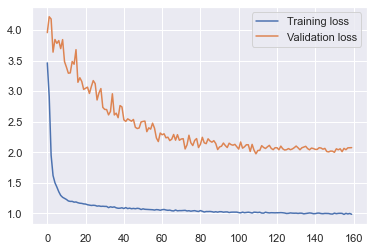

<Figure size 432x288 with 0 Axes>





Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_90 (LSTM)                 (None, 45, 24)       3744        ['input_31[0][0]']               
                                                                                                  
 dropout_60 (Dropout)           (None, 45, 24)       0           ['lstm_90[0][0]']                
                                                                                                  
 lstm_91 (LSTM)                 (None, 45, 16)       2624        ['dropout_60[0][0]']             
                                                                                       

66/66 [==============================] - 6s 96ms/step - loss: 2.9033 - val_loss: 2.8686 - lr: 1.0000e-04
Epoch 3/1000
65/66 [============================>.] - ETA: 0s - loss: 1.8050
Epoch 3: val_loss improved from 2.86856 to 2.72369, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.05.hdf5
66/66 [==============================] - 6s 91ms/step - loss: 1.8020 - val_loss: 2.7237 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.1411
Epoch 4: val_loss did not improve from 2.72369

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 6s 92ms/step - loss: 1.1411 - val_loss: 3.3256 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 0.8822
Epoch 5: val_loss did not improve from 2.72369

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==========================

Epoch 29/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3523
Epoch 29: val_loss did not improve from 2.35350

Epoch 29: ReduceLROnPlateau reducing learning rate to 7.8567809323431e-05.
66/66 [==============================] - 6s 87ms/step - loss: 0.3524 - val_loss: 2.7117 - lr: 7.9361e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.3534
Epoch 30: val_loss did not improve from 2.35350

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.778212770062965e-05.
66/66 [==============================] - 6s 88ms/step - loss: 0.3534 - val_loss: 2.5364 - lr: 7.8568e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 0.3408
Epoch 31: val_loss did not improve from 2.35350

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.70043047668878e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.3408 - val_loss: 2.6113 - lr: 7.7782e-05
Epoch 32/1000
66/66 [==============================] - ETA: 0s - loss: 0.352

66/66 [==============================] - 6s 88ms/step - loss: 0.2644 - val_loss: 2.6938 - lr: 4.8014e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.2689
Epoch 82: val_loss did not improve from 2.30203

Epoch 82: ReduceLROnPlateau reducing learning rate to 4.705864765128354e-05.
66/66 [==============================] - 6s 88ms/step - loss: 0.2686 - val_loss: 2.3932 - lr: 4.7534e-05
Epoch 83/1000
66/66 [==============================] - ETA: 0s - loss: 0.2628
Epoch 83: val_loss did not improve from 2.30203

Epoch 83: ReduceLROnPlateau reducing learning rate to 4.658806272345828e-05.
66/66 [==============================] - 6s 89ms/step - loss: 0.2628 - val_loss: 2.4562 - lr: 4.7059e-05
Epoch 84/1000
66/66 [==============================] - ETA: 0s - loss: 0.2572
Epoch 84: val_loss did not improve from 2.30203

Epoch 84: ReduceLROnPlateau reducing learning rate to 4.612218148395186e-05.
66/66 [==============================] - 6s 89ms/step - loss: 0.2572 - va

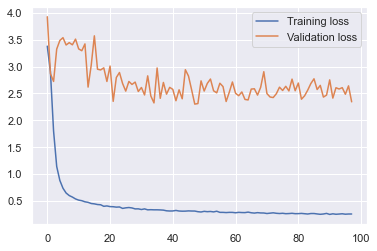

<Figure size 432x288 with 0 Axes>





Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_93 (LSTM)                 (None, 45, 24)       3744        ['input_32[0][0]']               
                                                                                                  
 dropout_62 (Dropout)           (None, 45, 24)       0           ['lstm_93[0][0]']                
                                                                                                  
 lstm_94 (LSTM)                 (None, 45, 16)       2624        ['dropout_62[0][0]']             
                                                                                       

Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.5415
Epoch 3: val_loss improved from 4.12367 to 3.66398, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.06.hdf5
66/66 [==============================] - 6s 94ms/step - loss: 1.5415 - val_loss: 3.6640 - lr: 9.9000e-05
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.1218
Epoch 4: val_loss improved from 3.66398 to 3.57529, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.06.hdf5
66/66 [==============================] - 6s 95ms/step - loss: 1.1218 - val_loss: 3.5753 - lr: 9.9000e-05
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 0.9294
Epoch 5: val_loss improved from 3.57529 to 3.39952, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.06.hdf5
66/66 [==============================] -

66/66 [==============================] - 6s 95ms/step - loss: 0.4007 - val_loss: 1.8161 - lr: 7.1055e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 0.3958
Epoch 54: val_loss did not improve from 1.81613

Epoch 54: ReduceLROnPlateau reducing learning rate to 7.034474649117328e-05.
66/66 [==============================] - 6s 95ms/step - loss: 0.3958 - val_loss: 1.8713 - lr: 7.1055e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.3981
Epoch 55: val_loss did not improve from 1.81613

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.964129657717422e-05.
66/66 [==============================] - 6s 94ms/step - loss: 0.3981 - val_loss: 1.9513 - lr: 7.0345e-05
Epoch 56/1000
65/66 [============================>.] - ETA: 0s - loss: 0.4035
Epoch 56: val_loss improved from 1.81613 to 1.77595, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.06.hdf5
66/66 [==================

66/66 [==============================] - 6s 94ms/step - loss: 0.3638 - val_loss: 1.7837 - lr: 5.7535e-05
Epoch 80/1000
66/66 [==============================] - ETA: 0s - loss: 0.3679
Epoch 80: val_loss did not improve from 1.55587

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.639049515593797e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.3679 - val_loss: 1.5716 - lr: 5.6960e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.3586
Epoch 81: val_loss did not improve from 1.55587

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.5826589195930865e-05.
66/66 [==============================] - 6s 92ms/step - loss: 0.3586 - val_loss: 1.8201 - lr: 5.6390e-05
Epoch 82/1000
65/66 [============================>.] - ETA: 0s - loss: 0.3563
Epoch 82: val_loss did not improve from 1.55587

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.526832333998754e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.3550 - v

Epoch 106/1000
66/66 [==============================] - ETA: 0s - loss: 0.3621
Epoch 106: val_loss did not improve from 1.49921

Epoch 106: ReduceLROnPlateau reducing learning rate to 4.386173510283697e-05.
66/66 [==============================] - 6s 93ms/step - loss: 0.3621 - val_loss: 1.6151 - lr: 4.4305e-05
Epoch 107/1000
66/66 [==============================] - ETA: 0s - loss: 0.3477
Epoch 107: val_loss did not improve from 1.49921

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.342311796790454e-05.
66/66 [==============================] - 6s 91ms/step - loss: 0.3477 - val_loss: 1.6947 - lr: 4.3862e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.3463
Epoch 108: val_loss did not improve from 1.49921

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.298888758057728e-05.
66/66 [==============================] - 6s 93ms/step - loss: 0.3463 - val_loss: 1.5880 - lr: 4.3423e-05
Epoch 109/1000
66/66 [==============================] - ETA: 0s 

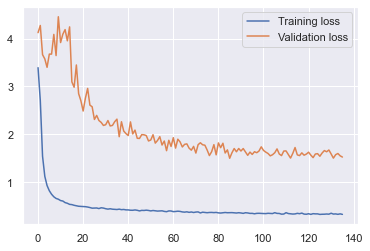

<Figure size 432x288 with 0 Axes>





Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_96 (LSTM)                 (None, 45, 24)       3744        ['input_33[0][0]']               
                                                                                                  
 dropout_64 (Dropout)           (None, 45, 24)       0           ['lstm_96[0][0]']                
                                                                                                  
 lstm_97 (LSTM)                 (None, 45, 16)       2624        ['dropout_64[0][0]']             
                                                                                       

66/66 [==============================] - 6s 84ms/step - loss: 2.7515 - val_loss: 3.2543 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.6381
Epoch 3: val_loss improved from 3.25426 to 3.18615, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.07.hdf5
66/66 [==============================] - 6s 86ms/step - loss: 1.6381 - val_loss: 3.1861 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.2274
Epoch 4: val_loss did not improve from 3.18615

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 6s 95ms/step - loss: 1.2274 - val_loss: 3.2037 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.0318
Epoch 5: val_loss did not improve from 3.18615

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.800999716389924e-05.
66/66 [==========================

Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.5551
Epoch 29: val_loss did not improve from 3.04863

Epoch 29: ReduceLROnPlateau reducing learning rate to 7.778212770062965e-05.
66/66 [==============================] - 6s 93ms/step - loss: 0.5551 - val_loss: 3.3737 - lr: 7.8568e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.5400
Epoch 30: val_loss did not improve from 3.04863

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.70043047668878e-05.
66/66 [==============================] - 6s 92ms/step - loss: 0.5400 - val_loss: 3.7144 - lr: 7.7782e-05
Epoch 31/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5444
Epoch 31: val_loss did not improve from 3.04863

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.623426128702704e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.5443 - val_loss: 3.8447 - lr: 7.7004e-05
Epoch 32/1000
66/66 [==============================] - ETA: 0s - loss: 0.5

66/66 [==============================] - 6s 89ms/step - loss: 0.4863 - val_loss: 3.7156 - lr: 6.0501e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.4864
Epoch 56: val_loss did not improve from 3.04863

Epoch 56: ReduceLROnPlateau reducing learning rate to 5.9296618201187815e-05.
66/66 [==============================] - 6s 90ms/step - loss: 0.4864 - val_loss: 3.7073 - lr: 5.9896e-05


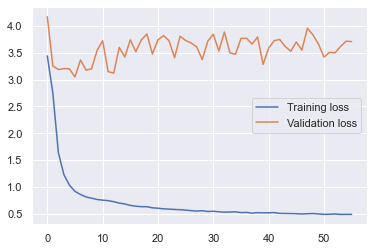

<Figure size 432x288 with 0 Axes>





Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_99 (LSTM)                 (None, 45, 24)       3744        ['input_34[0][0]']               
                                                                                                  
 dropout_66 (Dropout)           (None, 45, 24)       0           ['lstm_99[0][0]']                
                                                                                                  
 lstm_100 (LSTM)                (None, 45, 16)       2624        ['dropout_66[0][0]']             
                                                                                       

66/66 [==============================] - 6s 89ms/step - loss: 3.0646 - val_loss: 3.6052 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 2.0644
Epoch 3: val_loss improved from 3.60521 to 2.72671, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.08.hdf5
66/66 [==============================] - 6s 88ms/step - loss: 2.0644 - val_loss: 2.7267 - lr: 1.0000e-04
Epoch 4/1000
65/66 [============================>.] - ETA: 0s - loss: 1.3546
Epoch 4: val_loss improved from 2.72671 to 2.24117, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.08.hdf5
66/66 [==============================] - 6s 88ms/step - loss: 1.3544 - val_loss: 2.2412 - lr: 1.0000e-04
Epoch 5/1000
65/66 [============================>.] - ETA: 0s - loss: 1.0773
Epoch 5: val_loss improved from 2.24117 to 2.18056, saving model to C:\Users\Alex Lam\OneDrive\Documents\Dem

Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 0.5947
Epoch 28: val_loss did not improve from 1.56391

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.514576977177058e-05.
66/66 [==============================] - 6s 97ms/step - loss: 0.5947 - val_loss: 1.7328 - lr: 8.6006e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.5971
Epoch 29: val_loss did not improve from 1.56391

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.429430854448584e-05.
66/66 [==============================] - 6s 95ms/step - loss: 0.5971 - val_loss: 1.7330 - lr: 8.5146e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.5905
Epoch 30: val_loss did not improve from 1.56391

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.345136870048008e-05.
66/66 [==============================] - 6s 96ms/step - loss: 0.5905 - val_loss: 1.7134 - lr: 8.4294e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 0.

66/66 [==============================] - 6s 96ms/step - loss: 0.4988 - val_loss: 1.6211 - lr: 5.2034e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.4940
Epoch 81: val_loss did not improve from 1.50054

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.099855567095801e-05.
66/66 [==============================] - 6s 96ms/step - loss: 0.4940 - val_loss: 1.6625 - lr: 5.1514e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.5139
Epoch 82: val_loss did not improve from 1.50054

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.048856924986467e-05.
66/66 [==============================] - 6s 95ms/step - loss: 0.5139 - val_loss: 1.6263 - lr: 5.0999e-05
Epoch 83/1000
65/66 [============================>.] - ETA: 0s - loss: 0.5013
Epoch 83: val_loss did not improve from 1.50054

Epoch 83: ReduceLROnPlateau reducing learning rate to 4.998368269298226e-05.
66/66 [==============================] - 6s 94ms/step - loss: 0.5062 - va

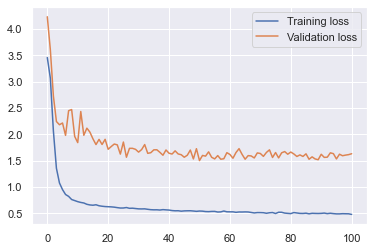

<Figure size 432x288 with 0 Axes>





Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_102 (LSTM)                (None, 45, 24)       3744        ['input_35[0][0]']               
                                                                                                  
 dropout_68 (Dropout)           (None, 45, 24)       0           ['lstm_102[0][0]']               
                                                                                                  
 lstm_103 (LSTM)                (None, 45, 16)       2624        ['dropout_68[0][0]']             
                                                                                       

66/66 [==============================] - 6s 91ms/step - loss: 2.7788 - val_loss: 3.6286 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.8476
Epoch 3: val_loss improved from 3.62864 to 3.25360, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.09.hdf5
66/66 [==============================] - 6s 90ms/step - loss: 1.8476 - val_loss: 3.2536 - lr: 1.0000e-04
Epoch 4/1000
65/66 [============================>.] - ETA: 0s - loss: 1.4487
Epoch 4: val_loss improved from 3.25360 to 2.78886, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.09.hdf5
66/66 [==============================] - 6s 90ms/step - loss: 1.4465 - val_loss: 2.7889 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.2261
Epoch 5: val_loss improved from 2.78886 to 2.57352, saving model to C:\Users\Alex Lam\OneDrive\Documents\Dem

66/66 [==============================] - 6s 97ms/step - loss: 0.6231 - val_loss: 2.4641 - lr: 6.4261e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.6203
Epoch 55: val_loss did not improve from 2.24856

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.298234337009489e-05.
66/66 [==============================] - 6s 98ms/step - loss: 0.6203 - val_loss: 2.2761 - lr: 6.3619e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.6139
Epoch 56: val_loss did not improve from 2.24856

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.235251734324266e-05.
66/66 [==============================] - 7s 100ms/step - loss: 0.6139 - val_loss: 2.2884 - lr: 6.2982e-05
Epoch 57/1000
66/66 [==============================] - ETA: 0s - loss: 0.6127
Epoch 57: val_loss did not improve from 2.24856

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.17289941146737e-05.
66/66 [==============================] - 7s 99ms/step - loss: 0.6127 - va

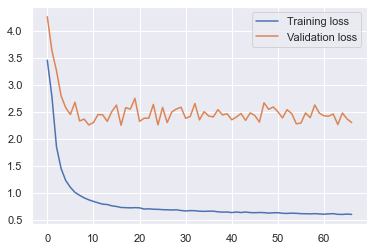

<Figure size 432x288 with 0 Axes>





Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_105 (LSTM)                (None, 45, 24)       3744        ['input_36[0][0]']               
                                                                                                  
 dropout_70 (Dropout)           (None, 45, 24)       0           ['lstm_105[0][0]']               
                                                                                                  
 lstm_106 (LSTM)                (None, 45, 16)       2624        ['dropout_70[0][0]']             
                                                                                       

66/66 [==============================] - 7s 106ms/step - loss: 2.8462 - val_loss: 3.4667 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.8603
Epoch 3: val_loss improved from 3.46674 to 2.87634, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 7s 101ms/step - loss: 1.8603 - val_loss: 2.8763 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.3536
Epoch 4: val_loss improved from 2.87634 to 2.46185, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.1.hdf5
66/66 [==============================] - 7s 100ms/step - loss: 1.3536 - val_loss: 2.4618 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.1445
Epoch 5: val_loss improved from 2.46185 to 2.23587, saving model to C:\Users\Alex Lam\OneDrive\Documents\De

Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 0.7778
Epoch 28: val_loss did not improve from 1.94327

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.345136870048008e-05.
66/66 [==============================] - 7s 105ms/step - loss: 0.7778 - val_loss: 2.1469 - lr: 8.4294e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.7716
Epoch 29: val_loss did not improve from 1.94327

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.261685659817886e-05.
66/66 [==============================] - 7s 106ms/step - loss: 0.7716 - val_loss: 2.1127 - lr: 8.3451e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.7657
Epoch 30: val_loss did not improve from 1.94327

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.179068579920567e-05.
66/66 [==============================] - 7s 105ms/step - loss: 0.7657 - val_loss: 2.0954 - lr: 8.2617e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss:

66/66 [==============================] - 7s 106ms/step - loss: 0.7014 - val_loss: 2.0984 - lr: 6.4910e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.6957
Epoch 55: val_loss did not improve from 1.94327

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.361852982081473e-05.
66/66 [==============================] - 7s 109ms/step - loss: 0.6957 - val_loss: 2.3004 - lr: 6.4261e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.7035
Epoch 56: val_loss did not improve from 1.94327

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.298234337009489e-05.
66/66 [==============================] - 7s 108ms/step - loss: 0.7035 - val_loss: 2.1078 - lr: 6.3619e-05
Epoch 57/1000
66/66 [==============================] - ETA: 0s - loss: 0.7012
Epoch 57: val_loss did not improve from 1.94327

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.235251734324266e-05.
66/66 [==============================] - 7s 107ms/step - loss: 0.7012 

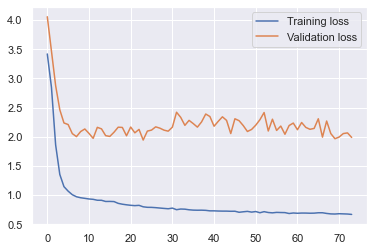

<Figure size 432x288 with 0 Axes>





Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_108 (LSTM)                (None, 45, 24)       3744        ['input_37[0][0]']               
                                                                                                  
 dropout_72 (Dropout)           (None, 45, 24)       0           ['lstm_108[0][0]']               
                                                                                                  
 lstm_109 (LSTM)                (None, 45, 16)       2624        ['dropout_72[0][0]']             
                                                                                       

66/66 [==============================] - 7s 103ms/step - loss: 2.8559 - val_loss: 3.6007 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.6675
Epoch 3: val_loss improved from 3.60067 to 3.37359, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.11.hdf5
66/66 [==============================] - 7s 101ms/step - loss: 1.6675 - val_loss: 3.3736 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.3376
Epoch 4: val_loss did not improve from 3.37359

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 7s 100ms/step - loss: 1.3376 - val_loss: 3.3815 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.2166
Epoch 5: val_loss improved from 3.37359 to 3.33960, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_

66/66 [==============================] - 7s 102ms/step - loss: 0.8150 - val_loss: 4.3700 - lr: 8.0973e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.8082
Epoch 29: val_loss did not improve from 3.27694

Epoch 29: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [==============================] - 7s 103ms/step - loss: 0.8082 - val_loss: 4.5195 - lr: 8.0163e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.8010
Epoch 30: val_loss did not improve from 3.27694

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.8567809323431e-05.
66/66 [==============================] - 7s 102ms/step - loss: 0.8010 - val_loss: 4.4077 - lr: 7.9361e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 0.8047
Epoch 31: val_loss did not improve from 3.27694

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.778212770062965e-05.
66/66 [==============================] - 7s 103ms/step - loss: 0.8047 - 

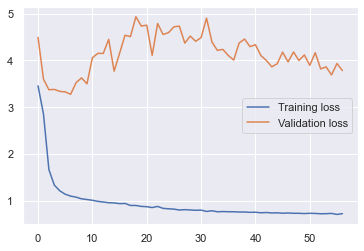

<Figure size 432x288 with 0 Axes>





Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_111 (LSTM)                (None, 45, 24)       3744        ['input_38[0][0]']               
                                                                                                  
 dropout_74 (Dropout)           (None, 45, 24)       0           ['lstm_111[0][0]']               
                                                                                                  
 lstm_112 (LSTM)                (None, 45, 16)       2624        ['dropout_74[0][0]']             
                                                                                       

66/66 [==============================] - 7s 102ms/step - loss: 2.9616 - val_loss: 3.6712 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 2.2253
Epoch 3: val_loss improved from 3.67117 to 3.18113, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.12.hdf5
66/66 [==============================] - 7s 100ms/step - loss: 2.2253 - val_loss: 3.1811 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.6218
Epoch 4: val_loss improved from 3.18113 to 2.65723, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.12.hdf5
66/66 [==============================] - 7s 100ms/step - loss: 1.6218 - val_loss: 2.6572 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.3361
Epoch 5: val_loss improved from 2.65723 to 2.41503, saving model to C:\Users\Alex Lam\OneDrive\Documents\


Epoch 28: ReduceLROnPlateau reducing learning rate to 8.097277706838213e-05.
66/66 [==============================] - 7s 104ms/step - loss: 0.8381 - val_loss: 2.7073 - lr: 8.1791e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.8323
Epoch 29: val_loss did not improve from 2.37385

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.01630511705298e-05.
66/66 [==============================] - 7s 106ms/step - loss: 0.8323 - val_loss: 2.6730 - lr: 8.0973e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.8317
Epoch 30: val_loss did not improve from 2.37385

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [==============================] - 7s 105ms/step - loss: 0.8317 - val_loss: 2.6718 - lr: 8.0163e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 0.8306
Epoch 31: val_loss did not improve from 2.37385

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.8567809323431e

Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.7776
Epoch 55: val_loss did not improve from 2.37385

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.17289941146737e-05.
66/66 [==============================] - 7s 104ms/step - loss: 0.7776 - val_loss: 3.4992 - lr: 6.2353e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.7843
Epoch 56: val_loss did not improve from 2.37385

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.111170165240765e-05.
66/66 [==============================] - 7s 104ms/step - loss: 0.7843 - val_loss: 3.2436 - lr: 6.1729e-05
Epoch 57/1000
66/66 [==============================] - ETA: 0s - loss: 0.7740
Epoch 57: val_loss did not improve from 2.37385

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.0500582330860196e-05.
66/66 [==============================] - 7s 105ms/step - loss: 0.7740 - val_loss: 3.2058 - lr: 6.1112e-05
Epoch 58/1000
66/66 [==============================] - ETA: 0s - loss:

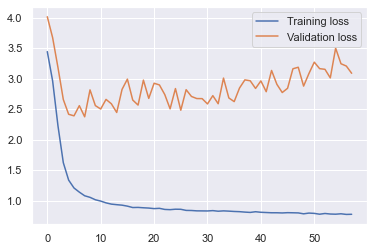

<Figure size 432x288 with 0 Axes>





Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_114 (LSTM)                (None, 45, 24)       3744        ['input_39[0][0]']               
                                                                                                  
 dropout_76 (Dropout)           (None, 45, 24)       0           ['lstm_114[0][0]']               
                                                                                                  
 lstm_115 (LSTM)                (None, 45, 16)       2624        ['dropout_76[0][0]']             
                                                                                       

66/66 [==============================] - 7s 100ms/step - loss: 3.0285 - val_loss: 3.2705 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 2.0670
Epoch 3: val_loss improved from 3.27051 to 3.20483, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.13.hdf5
66/66 [==============================] - 7s 100ms/step - loss: 2.0670 - val_loss: 3.2048 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.4943
Epoch 4: val_loss did not improve from 3.20483

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 7s 99ms/step - loss: 1.4943 - val_loss: 3.2654 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.3127
Epoch 5: val_loss improved from 3.20483 to 3.08984, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_C

66/66 [==============================] - 8s 122ms/step - loss: 0.8869 - val_loss: 2.6460 - lr: 8.0973e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.9009
Epoch 29: val_loss did not improve from 2.64600

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.01630511705298e-05.
66/66 [==============================] - 8s 114ms/step - loss: 0.9009 - val_loss: 2.8862 - lr: 8.0973e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.8848
Epoch 30: val_loss improved from 2.64600 to 2.55834, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.13.hdf5
66/66 [==============================] - 8s 116ms/step - loss: 0.8848 - val_loss: 2.5583 - lr: 8.0163e-05
Epoch 31/1000
66/66 [==============================] - ETA: 0s - loss: 0.8918
Epoch 31: val_loss did not improve from 2.55834

Epoch 31: ReduceLROnPlateau reducing learning rate to 7.936142166727223e-05.
66/66 [================


Epoch 54: ReduceLROnPlateau reducing learning rate to 6.55659000040032e-05.
66/66 [==============================] - 8s 126ms/step - loss: 0.8247 - val_loss: 2.4589 - lr: 6.6228e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.8218
Epoch 55: val_loss did not improve from 2.16372

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.491024330898654e-05.
66/66 [==============================] - 8s 125ms/step - loss: 0.8218 - val_loss: 2.3864 - lr: 6.5566e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.8193
Epoch 56: val_loss did not improve from 2.16372

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.426114152418449e-05.
66/66 [==============================] - 8s 124ms/step - loss: 0.8193 - val_loss: 2.3447 - lr: 6.4910e-05
Epoch 57/1000
66/66 [==============================] - ETA: 0s - loss: 0.8239
Epoch 57: val_loss did not improve from 2.16372

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.36185298208147

66/66 [==============================] - 8s 118ms/step - loss: 0.7945 - val_loss: 2.3370 - lr: 5.2034e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.7888
Epoch 81: val_loss did not improve from 2.08386

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.099855567095801e-05.
66/66 [==============================] - 8s 119ms/step - loss: 0.7888 - val_loss: 2.2461 - lr: 5.1514e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.7842
Epoch 82: val_loss did not improve from 2.08386

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.048856924986467e-05.
66/66 [==============================] - 8s 117ms/step - loss: 0.7842 - val_loss: 2.3717 - lr: 5.0999e-05
Epoch 83/1000
66/66 [==============================] - ETA: 0s - loss: 0.7878
Epoch 83: val_loss did not improve from 2.08386

Epoch 83: ReduceLROnPlateau reducing learning rate to 4.998368269298226e-05.
66/66 [==============================] - 8s 115ms/step - loss: 0.7878 

66/66 [==============================] - ETA: 0s - loss: 0.7674
Epoch 107: val_loss did not improve from 2.08386

Epoch 107: ReduceLROnPlateau reducing learning rate to 3.927109017240582e-05.
66/66 [==============================] - 11s 166ms/step - loss: 0.7674 - val_loss: 2.2380 - lr: 3.9668e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.7588
Epoch 108: val_loss did not improve from 2.08386

Epoch 108: ReduceLROnPlateau reducing learning rate to 3.887837901856983e-05.
66/66 [==============================] - 11s 167ms/step - loss: 0.7588 - val_loss: 2.1810 - lr: 3.9271e-05
Epoch 109/1000
66/66 [==============================] - ETA: 0s - loss: 0.7728
Epoch 109: val_loss did not improve from 2.08386

Epoch 109: ReduceLROnPlateau reducing learning rate to 3.848959360766457e-05.
66/66 [==============================] - 10s 147ms/step - loss: 0.7728 - val_loss: 2.2431 - lr: 3.8878e-05
Epoch 110/1000
66/66 [==============================] - ETA: 0s - loss: 0

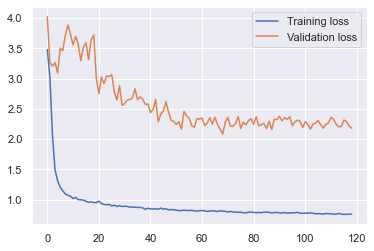

<Figure size 432x288 with 0 Axes>





Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_117 (LSTM)                (None, 45, 24)       3744        ['input_40[0][0]']               
                                                                                                  
 dropout_78 (Dropout)           (None, 45, 24)       0           ['lstm_117[0][0]']               
                                                                                                  
 lstm_118 (LSTM)                (None, 45, 16)       2624        ['dropout_78[0][0]']             
                                                                                       

66/66 [==============================] - 7s 110ms/step - loss: 3.0061 - val_loss: 3.9696 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.9627
Epoch 3: val_loss improved from 3.96958 to 2.82365, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 7s 101ms/step - loss: 1.9627 - val_loss: 2.8237 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.5171
Epoch 4: val_loss did not improve from 2.82365

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.899999749904965e-05.
66/66 [==============================] - 7s 104ms/step - loss: 1.5171 - val_loss: 2.8286 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.3883
Epoch 5: val_loss improved from 2.82365 to 2.80369, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_

66/66 [==============================] - 8s 126ms/step - loss: 0.9348 - val_loss: 2.0462 - lr: 8.7752e-05
Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 0.9358
Epoch 28: val_loss did not improve from 2.04167

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.600583161751274e-05.
66/66 [==============================] - 8s 119ms/step - loss: 0.9358 - val_loss: 2.1725 - lr: 8.6875e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.9389
Epoch 29: val_loss improved from 2.04167 to 1.96651, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.14.hdf5
66/66 [==============================] - 8s 120ms/step - loss: 0.9389 - val_loss: 1.9665 - lr: 8.6006e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.9285
Epoch 30: val_loss did not improve from 1.96651

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.514576977177058e-05.
66/66 [===============

Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 0.8627
Epoch 54: val_loss did not improve from 1.92598

Epoch 54: ReduceLROnPlateau reducing learning rate to 6.75728838541545e-05.
66/66 [==============================] - 6s 95ms/step - loss: 0.8627 - val_loss: 2.3977 - lr: 6.8255e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.8658
Epoch 55: val_loss did not improve from 1.92598

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.689715184620581e-05.
66/66 [==============================] - 6s 95ms/step - loss: 0.8658 - val_loss: 2.2144 - lr: 6.7573e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.8523
Epoch 56: val_loss did not improve from 1.92598

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.622818364121486e-05.
66/66 [==============================] - 6s 95ms/step - loss: 0.8523 - val_loss: 2.1583 - lr: 6.6897e-05
Epoch 57/1000
66/66 [==============================] - ETA: 0s - loss: 0.8

66/66 [==============================] - 7s 113ms/step - loss: 0.8300 - val_loss: 2.0056 - lr: 5.2560e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.8384
Epoch 81: val_loss did not improve from 1.92598

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.1513692378648555e-05.
66/66 [==============================] - 8s 125ms/step - loss: 0.8384 - val_loss: 2.0324 - lr: 5.2034e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.8453
Epoch 82: val_loss did not improve from 1.92598

Epoch 82: ReduceLROnPlateau reducing learning rate to 5.099855567095801e-05.
66/66 [==============================] - 8s 126ms/step - loss: 0.8453 - val_loss: 2.0931 - lr: 5.1514e-05
Epoch 83/1000
66/66 [==============================] - ETA: 0s - loss: 0.8348
Epoch 83: val_loss did not improve from 1.92598

Epoch 83: ReduceLROnPlateau reducing learning rate to 5.048856924986467e-05.
66/66 [==============================] - 6s 94ms/step - loss: 0.8348 

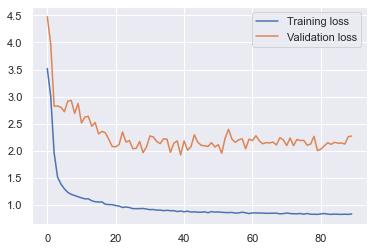

<Figure size 432x288 with 0 Axes>





Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_120 (LSTM)                (None, 45, 24)       3744        ['input_41[0][0]']               
                                                                                                  
 dropout_80 (Dropout)           (None, 45, 24)       0           ['lstm_120[0][0]']               
                                                                                                  
 lstm_121 (LSTM)                (None, 45, 16)       2624        ['dropout_80[0][0]']             
                                                                                       

66/66 [==============================] - 7s 112ms/step - loss: 2.7241 - val_loss: 3.5267 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 1.8719
Epoch 3: val_loss improved from 3.52666 to 3.04121, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 7s 104ms/step - loss: 1.8719 - val_loss: 3.0412 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.5835
Epoch 4: val_loss improved from 3.04121 to 2.88486, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 7s 104ms/step - loss: 1.5835 - val_loss: 2.8849 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.4191
Epoch 5: val_loss improved from 2.88486 to 2.65536, saving model to C:\Users\Alex Lam\OneDrive\Documents\

Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 0.9998
Epoch 28: val_loss did not improve from 2.16547

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.345136870048008e-05.
66/66 [==============================] - 8s 123ms/step - loss: 0.9998 - val_loss: 2.2402 - lr: 8.4294e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 0.9923
Epoch 29: val_loss did not improve from 2.16547

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.261685659817886e-05.
66/66 [==============================] - 7s 109ms/step - loss: 0.9923 - val_loss: 2.2071 - lr: 8.3451e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 0.9834
Epoch 30: val_loss improved from 2.16547 to 2.10965, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 6s 98ms/step - loss: 0.9834 - val_loss: 2.1096 - lr: 8.2617e-05
Epoch 31/1000
66/66 [==

66/66 [==============================] - 8s 119ms/step - loss: 0.9374 - val_loss: 2.0869 - lr: 6.9641e-05
Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 0.9218
Epoch 54: val_loss did not improve from 1.93930

Epoch 54: ReduceLROnPlateau reducing learning rate to 6.82554372906452e-05.
66/66 [==============================] - 8s 118ms/step - loss: 0.9218 - val_loss: 2.0051 - lr: 6.8945e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.9262
Epoch 55: val_loss improved from 1.93930 to 1.92910, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.15.hdf5
66/66 [==============================] - 8s 119ms/step - loss: 0.9262 - val_loss: 1.9291 - lr: 6.8255e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.9268
Epoch 56: val_loss did not improve from 1.92910

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.75728838541545e-05.
66/66 [=================

66/66 [==============================] - 7s 99ms/step - loss: 0.9098 - val_loss: 1.8941 - lr: 5.5268e-05
Epoch 80/1000
66/66 [==============================] - ETA: 0s - loss: 0.8991
Epoch 80: val_loss did not improve from 1.82913

Epoch 80: ReduceLROnPlateau reducing learning rate to 5.416848503955407e-05.
66/66 [==============================] - 7s 100ms/step - loss: 0.8991 - val_loss: 1.8995 - lr: 5.4716e-05
Epoch 81/1000
66/66 [==============================] - ETA: 0s - loss: 0.9015
Epoch 81: val_loss did not improve from 1.82913

Epoch 81: ReduceLROnPlateau reducing learning rate to 5.362680094549433e-05.
66/66 [==============================] - 7s 99ms/step - loss: 0.9015 - val_loss: 1.8474 - lr: 5.4168e-05
Epoch 82/1000
66/66 [==============================] - ETA: 0s - loss: 0.8946
Epoch 82: val_loss improved from 1.82913 to 1.80252, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.15.hdf5
66/66 [=================

Epoch 106/1000
66/66 [==============================] - ETA: 0s - loss: 0.8822
Epoch 106: val_loss did not improve from 1.80252

Epoch 106: ReduceLROnPlateau reducing learning rate to 4.2133406968787315e-05.
66/66 [==============================] - 8s 115ms/step - loss: 0.8822 - val_loss: 1.9251 - lr: 4.2559e-05
Epoch 107/1000
66/66 [==============================] - ETA: 0s - loss: 0.8866
Epoch 107: val_loss did not improve from 1.80252

Epoch 107: ReduceLROnPlateau reducing learning rate to 4.1712073907547166e-05.
66/66 [==============================] - 8s 116ms/step - loss: 0.8866 - val_loss: 1.8909 - lr: 4.2133e-05
Epoch 108/1000
66/66 [==============================] - ETA: 0s - loss: 0.8778
Epoch 108: val_loss did not improve from 1.80252

Epoch 108: ReduceLROnPlateau reducing learning rate to 4.1294954717159274e-05.
66/66 [==============================] - 10s 159ms/step - loss: 0.8778 - val_loss: 1.9311 - lr: 4.1712e-05
Epoch 109/1000
66/66 [==============================] - E

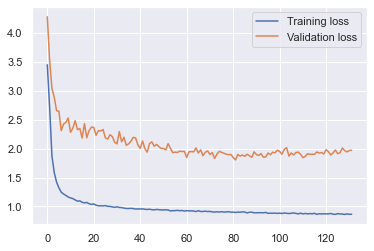

<Figure size 432x288 with 0 Axes>





Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 45, 14)]     0           []                               
                                                                                                  
 lstm_123 (LSTM)                (None, 45, 24)       3744        ['input_42[0][0]']               
                                                                                                  
 dropout_82 (Dropout)           (None, 45, 24)       0           ['lstm_123[0][0]']               
                                                                                                  
 lstm_124 (LSTM)                (None, 45, 16)       2624        ['dropout_82[0][0]']             
                                                                                       

66/66 [==============================] - 9s 131ms/step - loss: 3.0005 - val_loss: 3.4399 - lr: 1.0000e-04
Epoch 3/1000
66/66 [==============================] - ETA: 0s - loss: 2.0275
Epoch 3: val_loss improved from 3.43988 to 3.17204, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 10s 144ms/step - loss: 2.0275 - val_loss: 3.1720 - lr: 1.0000e-04
Epoch 4/1000
66/66 [==============================] - ETA: 0s - loss: 1.5525
Epoch 4: val_loss improved from 3.17204 to 3.04085, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 9s 140ms/step - loss: 1.5525 - val_loss: 3.0408 - lr: 1.0000e-04
Epoch 5/1000
66/66 [==============================] - ETA: 0s - loss: 1.4006
Epoch 5: val_loss improved from 3.04085 to 2.84676, saving model to C:\Users\Alex Lam\OneDrive\Documents

66/66 [==============================] - 8s 115ms/step - loss: 1.0150 - val_loss: 1.8522 - lr: 8.8638e-05
Epoch 28/1000
66/66 [==============================] - ETA: 0s - loss: 1.0154
Epoch 28: val_loss did not improve from 1.85215

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.775210291787516e-05.
66/66 [==============================] - 9s 130ms/step - loss: 1.0154 - val_loss: 1.8573 - lr: 8.8638e-05
Epoch 29/1000
66/66 [==============================] - ETA: 0s - loss: 1.0112
Epoch 29: val_loss did not improve from 1.85215

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.687458052008878e-05.
66/66 [==============================] - 8s 129ms/step - loss: 1.0112 - val_loss: 2.0106 - lr: 8.7752e-05
Epoch 30/1000
66/66 [==============================] - ETA: 0s - loss: 1.0036
Epoch 30: val_loss did not improve from 1.85215

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.600583161751274e-05.
66/66 [==============================] - 9s 133ms/step - loss: 1.0036 

Epoch 54/1000
66/66 [==============================] - ETA: 0s - loss: 0.9594
Epoch 54: val_loss did not improve from 1.83808

Epoch 54: ReduceLROnPlateau reducing learning rate to 6.894488418765832e-05.
66/66 [==============================] - 8s 117ms/step - loss: 0.9594 - val_loss: 1.8867 - lr: 6.9641e-05
Epoch 55/1000
66/66 [==============================] - ETA: 0s - loss: 0.9491
Epoch 55: val_loss did not improve from 1.83808

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.82554372906452e-05.
66/66 [==============================] - 8s 121ms/step - loss: 0.9491 - val_loss: 1.8819 - lr: 6.8945e-05
Epoch 56/1000
66/66 [==============================] - ETA: 0s - loss: 0.9493
Epoch 56: val_loss improved from 1.83808 to 1.81260, saving model to C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_3_CCMP_t+1_0.16.hdf5
66/66 [==============================] - 8s 123ms/step - loss: 0.9493 - val_loss: 1.8126 - lr: 6.8255e-05
Epoch 57/1000
66/66 [==

In [ ]:
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

for loop in range(1,10):
    os.chdir(r"C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23")
    for i in range(5,20):
        global k 
        k = i/100
        j = 'CCMP_t+1'
        import os
        # Check whether the specified path exists or not
        path = fr"C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23"
        isExist = os.path.exists(path)
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(path)
            print("The new directory is created!")

        ###MODEL INFRASTRUCTURE###
            ###MODEL INFRASTRUCTURE###
                ###MODEL INFRASTRUCTURE###
                    ###MODEL INFRASTRUCTURE###
                        ###MODEL INFRASTRUCTURE###
                            ###MODEL INFRASTRUCTURE###
                                ###MODEL INFRASTRUCTURE###
        # Define inputs with predefined shape
        inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
        # Build network with some predefined architecture
        output1 = LSTM(24,recurrent_initializer =glorot_uniform(),return_sequences = True)(inputs)
        do1 = Dropout(0.4)(output1)
        output2 = LSTM(16,return_sequences = True)(do1)
        do2 = Dropout(0.4)(output2)
        output3 = LSTM(32)(do2)
        output4 = Dense(40)(output3)
        outputs = Dense(5)(output4)
        distribution_outputs = layer.Normal_Dist_Layer_2(outputs)

        # Construct model
        model4 = Model(inputs=inputs, outputs=distribution_outputs)
        model4.summary()
        print('This is the start of the tunning of the model with weight of the positive component =',f'_{loop}_{j}_{k}')
        model4.compile(loss = layer.negative_log_likelihood_loss_2, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

        # checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
        # callbacks_list = [checkpoint]
        # filepath="weights-improvement-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
        # history = model3.fit(X_train, Y_train, batch_size=256, epochs = 1000,
        #                     validation_data = [X_val, Y_val], callbacks = callback_list)
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
        filepath = fr"C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_{loop}_{j}_{k}.hdf5"
        reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.99, patience = 1, verbose=1)
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        history = model4.fit(X_train, Y_train, 
                                 batch_size=128, 
                                 epochs = 1000, 
                                 validation_data = [X_val, Y_val], 
                                 callbacks = [checkpoint, early_stop, reduce_lr])

        import os 
        os.chmod(filepath, 0o777)
        minimum = pd.Series(history.history['val_loss']).min()
        historydf = pd.DataFrame(history.history)
        historydf.to_csv(f"_{j}exp1-{k}_tloss&vloss_{minimum}.csv") # Save training loss vs validation loss

        %matplotlib inline
        plt.plot(history.history['loss'],label = 'Training loss')
        plt.plot(history.history['val_loss'], label = 'Validation loss')
        plt.legend()
        plt.figure()
        plt.savefig(f'_{j}exp1-{k}_tlossvloss_{minimum}.jpg')
        plt.show()
        print('\n')
        print('\n')


# LOAD MODELS

In [57]:
# Load models according to the respective coefficient of the term sigma_2^2 of the loss function (after NLL).
d_report = pd.DataFrame()
d_report.index = range(5,20)
d_report.index = d_report.index/100 

for loop in range(1,3):    
    Train_NLL = []
    Train_Pearson_Corr_Coeff = []
    Train_Spearman_rank_Corr_Coeff = []
    Train_Pearson_Corr_Coeff_Var = []
    Deviation_Measure_Train = []

    Test_NLL = []
    Test_Pearson_Corr_Coeff = []
    Test_Spearman_rank_Corr_Coeff = []
    Test_Pearson_Corr_Coeff_Var = []
    Deviation_Measure_Test = []
    
    for i in range(5,20):
        k = i/100
        j = 'CCMP_t+1'

        tf.keras.utils.get_custom_objects().update({'negative_log_likelihood_loss_2':layer.negative_log_likelihood_loss_2})
        model = tf.keras.models.load_model(fr"C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\_CCMP_t+1_Mar23\_{loop}_{j}_{k}.hdf5")

    #     model = tf.keras.models.load_model(fr"C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\CCMP_t+1\exp1-{k}.hdf5")

        #Predict the parameters in training period after loading the model
        pred_params = model.predict(X_train)
        mu1_train = pred_params[:,0]
        sigma2_1_train = pred_params[:,1]
        mu2_train = pred_params[:,2]
        sigma2_2_train = pred_params[:,3] 
        w1_train = pred_params[:,4]

        # PLOT THE TRATINING PERIOD PERFORMANCE
        mu1_train = mu1_train.reshape(-1,1)
        sigma2_1_train = sigma2_1_train.reshape(-1,1)
        mu2_train = mu2_train.reshape(-1,1)
        sigma2_2_train = sigma2_2_train.reshape(-1,1)
        w1_train = w1_train.reshape(-1,1)

        # Inverse transform the scaled target (Y_train), and the estimated mu1 and mu2.
        Y_train_plot = SC2.inverse_transform(Y_train)
        mu1_train_plot = SC2.inverse_transform(mu1_train)
        mu2_train_plot = SC2.inverse_transform(mu2_train)

        # PLOT THE TRATINING PERIOD PERFORMANCE
        d_plot = pd.DataFrame()
        d_plot.index = d1.index[n_past-1:-n_val-1]
        d_plot['Y_train'] = Y_train
        d_plot['Y_train_plot'] = pd.DataFrame(Y_train_plot)
        d_plot['mu1_train'] = mu1_train
        d_plot['mu1_train_plot'] = mu1_train_plot
        d_plot['mu2_train'] = mu2_train
        d_plot['mu2_train_plot'] = mu2_train_plot
        d_plot['sigma2_1_train'] = sigma2_1_train
        d_plot['sigma2_2_train'] = sigma2_2_train
        d_plot['w1_train'] = w1_train
        d_plot['varY_train'] = varY_train

        x = d_plot.index
        y2 = d_plot['Y_train']
        y1 = d_plot['Y_train_plot'] 
        y4 = d_plot['mu1_train']
        y3 = d_plot['mu1_train_plot']
        y6 = d_plot['mu2_train']
        y5 = d_plot['mu2_train_plot']
        y7 = d_plot['sigma2_1_train']
        y8 = d_plot['sigma2_2_train']
        y9 = d_plot['w1_train']
        y10 = d_plot['varY_train']

        # Negative log - likelihood function at training period
        nll_train = np.mean(
            (-np.log(w1_train)+0.5*(np.log(sigma2_1_train)+np.square(Y_train-mu1_train)/sigma2_1_train)
                   -np.log(1-w1_train)+0.5*(np.log(sigma2_2_train)+np.square(Y_train-mu2_train)/sigma2_2_train)))

#         # create figure and axis objects with subplots()
#         fig,ax = plt.subplots(figsize = (23,8))
#         # make a plot
#         ax.plot(x,y2, label='$\Y_Train$', color = 'g')
#         # set x-axis label
#         ax.set_xlabel(f'_{j}exp1-{k} Training Period', fontsize = 14)
#         # set y-axis label
#         ax.set_ylabel("CCMP INDEX LOG DIFF", fontsize=14)
#         # twin object for two different y-axis on the sample plot
#         ax2=ax.twinx()
#         # make a plot with different y-axis using second axis object
#         ax2.plot(x, y4, label='$\mu1_t$', color = 'b', linestyle='-')
#         ax2.plot(x, y6, label='$\mu2_t$', color = 'r', linestyle='-')
#         ax2.plot(x, y7, label='$\sigma1^2_t$', color = 'b', linestyle='--')
#         ax2.plot(x, y8, label='$\sigma2^2_t$', color = 'r', linestyle='--')
#         ax2.set_ylabel(f'_{j}exp1-{k}Estimated Value',fontsize=14)
#         plt.legend()
#         plt.show()
        print("The negative log-likelihood of the model in the training period is:",nll_train)
        print("The Deviation Measure the training period is:",'{:.2f}'.format(np.mean((y2-y9*y4-(1-y9)*y6)/(y9*y7+(1-y9)*y8))))
        print(f'Pearson corr coef of expected return of the Gaussian Mean with Y_train during Training Period:', '{:.2f}'.format(np.corrcoef(y2, y4*y9+(1-y9)*y6)[0,1]))
        print(f'Pearson corr coef of mu2 with Y_train during Training Period:', '{:.2f}'.format(np.corrcoef(y2, y6)[0,1]))
        print(f'Pearson corr coef of var of Y_train vs weighted_sum of var of sigma1^2 and sigma2^2 of the Gaussian Mixture during Training Period:', '{:.2f}'.format(np.corrcoef(y10, np.square(y9)*y7+np.square(1-y9)*y8)[0,1]))
        print(f'var of Y_train is calculated based on the var of previous 59 days')


        corr,pval = spearmanr(y2, y4*y9+(1-y9)*y6)
        print(f"TRAINING PERIOD Spearman rank correlation coefficient: {corr:.2f}")
        print(f"TRAINING PERIOD p-val:{pval:.2f}")
        Train_NLL.append('{:.2f}'.format(nll_train))
        Deviation_Measure_Train.append('{:.4f}'.format(np.mean((y2-y9*y4-(1-y9)*y6)/(y9*y7+(1-y9)*y8))))
        Train_Pearson_Corr_Coeff.append('{:.2f}'.format(np.corrcoef(y2, y4*y9+(1-y9)*y6)[0,1]))
        Train_Spearman_rank_Corr_Coeff.append('{:.2f}'.format(corr))
        Train_Pearson_Corr_Coeff_Var.append('{:.2f}'.format(np.corrcoef(y10, y7*y9+(1-y9)*y8)[0,1]))


        #Predict the parameters in testing period after loading the model
        pred_params = model.predict(X_rtest)
        mu1_test = pred_params[:,0]
        sigma2_1_test = pred_params[:,1]
        mu2_test = pred_params[:,2]
        sigma2_2_test = pred_params[:,3] 
        w1_test = pred_params[:,4] 

        mu1_test = mu1_test.reshape(-1,1)
        sigma2_1_test = sigma2_1_test.reshape(-1,1)
        mu2_test = mu2_test.reshape(-1,1)
        sigma2_2_test = sigma2_2_test.reshape(-1,1)
        w1_test = w1_test.reshape(-1,1)

        # Inverse transform the scaled target (Y_test), and the estimated mu1 and mu2.
        Y_test_plot = np.exp(SC2.inverse_transform(Y_rtest))-1
        mu1_test_plot = np.exp(SC2.inverse_transform(mu1_test))-1
        mu2_test_plot = np.exp(SC2.inverse_transform(mu2_test))-1

        # PLOT THE TESTING PERIOD PERFORMANCE        
        d_test = pd.DataFrame()
        d_test.index = d1.index[-n_rtest:]
        d_test['Y_test'] = Y_rtest
        d_test['Y_test_plot'] = Y_test_plot
        d_test['mu1_test'] = mu1_test
        d_test['mu1_test_plot'] = mu1_test_plot    
        d_test['mu2_test'] = mu2_test
        d_test['mu2_test_plot'] = mu2_test_plot
        d_test['sigma2_1_test'] = sigma2_1_test
        d_test['sigma2_2_test'] = sigma2_2_test
        d_test['sigma_1_test'] = np.sqrt(sigma2_1_test)
        d_test['sigma_2_test'] = np.sqrt(sigma2_2_test)
        d_test['w1_test'] = w1_test
        d_test['varY_test'] = varY_rtest

        x = d_test.index
        y1 = d_test['Y_test'] 
        y2 = d_test['Y_test_plot']
        y5 = d_test['mu1_test']
        y3 = d_test['mu1_test_plot']
        y7 = d_test['mu2_test']
        y6 = d_test['mu2_test_plot']
        y8 = d_test['sigma2_1_test']
        y9 = d_test['sigma2_2_test']
        y10 = d_test['sigma_1_test']
        y11 = d_test['sigma_2_test']
        y12 = d_test['w1_test']
        y13 = d_test['varY_test']
#         # create figure and axis objects with subplots()
#         fig,ax = plt.subplots(figsize = (23,8))
#         # make a plot
#         ax.plot(x, y1, label='$Y_Test$', color = 'g')
#         # set x-axis label
#         ax.set_xlabel(f'exp1-{k} Testing Period', fontsize = 14)
#         # set y-axis label
#         ax.set_ylabel(f'exp1-{k}_CCMP INDEX Log Return', fontsize=14)
#         plt.legend()
#         # twin object for two different y-axis on the sample plot
#         ax2=ax.twinx()
#         # make a plot with different y-axis using second axis object
#         # ax2.plot(x, y5, label='$\mu1_t$', color = 'b', linestyle='-')
#         # ax2.plot(x, y7, label='$\mu2_t$', color = 'r', linestyle='-')
#         ax2.plot(x, y10, label='$\sigma1^2_t$', color = 'b', linestyle='--')
#         ax2.plot(x, y11, label='$\sigma2^2_t$', color = 'r', linestyle='--')
#         # ax2.plot(x, y12, label='$w1$', color = 'b', linestyle='--')

#         ax2.set_ylabel(f'_{j}exp1-{k}_Estimated Value',fontsize=14)
#         plt.legend()
#         plt.show()
        # save the plot as a file
        # Negative log likelihood in testing period
        nll_test = np.mean(
            (-np.log(w1_test)+0.5*(np.log(sigma2_1_test)+np.square(Y_rtest-mu1_test)/sigma2_1_test)
                   -np.log(1-w1_test)+0.5*(np.log(sigma2_2_test)+np.square(Y_rtest-mu2_test)/sigma2_2_test)))

#             # create figure and axis objects with subplots()
#         fig,ax = plt.subplots(figsize = (23,8))
#         # make a plot
#         ax.plot(x, y1, label='$Y_test$', color = 'g')
#         # set x-axis label
#         ax.set_xlabel(f'_{j}exp1-{k} Testing Period', fontsize = 14)
#         # set y-axis label
#         ax.set_ylabel(f'_{j}exp1-{k}_CCMP INDEX LOG DIFF', fontsize=14)
#         plt.legend()
#         # twin object for two different y-axis on the sample plot
#         ax2=ax.twinx()
#         # make a plot with different y-axis using second axis object
#         ax2.plot(x, y5, label='$\mu1_t$', color = 'b', linestyle='-')
#         ax2.plot(x, y7, label='$\mu2_t$', color = 'r', linestyle='-')
        print("The negative log-likelihood of the model in the testing period is:",nll_test)    
        print("The Deviation Measure the Test period is:",'{:.4f}'.format(np.mean((y2-y12*y5-(1-y12)*y7)/(y12*y8+(1-y12)*y9))))
        print(f'Pearson corr coef of expected return of the Gaussian Mixture with Y_Test during Test Period:', '{:.2f}'.format(np.corrcoef(y1, y12*y5+(1-y12)*y7)[0,1]))
        print(f'Pearson corr coef of mu2 with Y_Test during Test Period:', '{:.2f}'.format(np.corrcoef(y1, y7)[0,1]))
        print(f'Pearson corr coef of var of Y_Test vs weighted sum of var of sigma1^2 and sigma2^2 of the Gaussian Mixture during Test Period:', '{:.2f}'.format(np.corrcoef(y13, np.square(y12)*y8+np.square(1-y12)*y9)[0,1]))
        print(f'var of Y_test is calculated based on the var of previous 59 days')

        corr,pval = spearmanr(y1, y12*y5+(1-y12)*y7)
        print(f"TESTING PERIOD Spearman rank correlation coefficient: {corr:.2f}")
        print(f"TESTING PERIOD p-val:{pval:.2f}")
        Test_NLL.append('{:.2f}'.format(nll_test))
        Deviation_Measure_Test.append('{:.4f}'.format(np.mean((y2-y12*y5-(1-y12)*y7)/(y12*y8+(1-y12)*y9))))
        Test_Pearson_Corr_Coeff.append('{:.2f}'.format(np.corrcoef(y1, y12*y5+(1-y12)*y7)[0,1]))
        Test_Spearman_rank_Corr_Coeff.append('{:.2f}'.format(corr))
        Test_Pearson_Corr_Coeff_Var.append('{:.2f}'.format(np.corrcoef(y13, y12*y8+(1-y12)*y9)[0,1]))

#         ax2.set_ylabel(f'_{j}exp1-{k}_Estimated Value',fontsize=14)
#         plt.legend()
#         plt.show()


#         #TESTING PERIOD UNDERLYING ASSET LOG RETURN vs w1#############################
#             #TESTING PERIOD UNDERLYING ASSET LOG RETURN vs w1#############################
#                 #TESTING PERIOD UNDERLYING ASSET LOG RETURN vs w1#############################
#                     #TESTING PERIOD UNDERLYING ASSET LOG RETURN vs w1#############################
#                         #TESTING PERIOD UNDERLYING ASSET LOG RETURN vs w1#############################
#         # create figure and axis objects with subplots()
#         fig,ax = plt.subplots(figsize = (23,8))
#         # make a plot
#         ax.plot(x, y1, label='$Y_test$', color = 'g')
#         # set x-axis label
#         ax.set_xlabel(f'_{j}exp1-{k}_Testing Period', fontsize = 14)
#         # set y-axis label
#         ax.set_ylabel(f'_{j}exp1-{k}_CCMP US Equity LOG DIFF', fontsize=14)
#         plt.legend()
#         # twin object for two different y-axis on the sample plot
#         ax2=ax.twinx()
#         # make a plot with different y-axis using second axis object
#         # ax2.plot(x, y5, label='$\mu1_t$', color = 'b', linestyle='-')

#         ax2.plot(x, y12, label='$w1$', color = 'k', linestyle='--')

#         ax2.set_ylabel("w1",fontsize=14)
#         plt.legend()
#         plt.show()
#         # save the plot as a file

    d_report[f'{loop}_Train_nll'] = Train_NLL
    d_report[f'{loop}_Mean Train_Pearson Corr Coeff'] = Train_Pearson_Corr_Coeff
    d_report[f'{loop}_Mean Train_Spearman rank Corr Coeff'] = Train_Spearman_rank_Corr_Coeff
    d_report[f'{loop}_Variance Train Pear Corr Coeff'] = Train_Pearson_Corr_Coeff_Var
    d_report[f'{loop}_Deviation Measure Train'] = Deviation_Measure_Train

    d_report[f'{loop}_Test_nll'] = Test_NLL
    d_report[f'{loop}_Mean Test_Pearson Corr Coeff'] = Test_Pearson_Corr_Coeff
    d_report[f'{loop}_Mean Test_Spearman rank Corr Coeff'] = Test_Spearman_rank_Corr_Coeff
    d_report[f'{loop}_Variance Test Pear Corr Coeff'] = Test_Pearson_Corr_Coeff_Var
    d_report[f'{loop}_Deviation Measure Test'] = Deviation_Measure_Test


d_report


261/261 [==============================] - 7s 20ms/step
The negative log-likelihood of the model in the training period is: 3.6925797046719357
The Deviation Measure the training period is: 0.01
Pearson corr coef of expected return of the Gaussian Mean with Y_train during Training Period: -0.03
Pearson corr coef of mu2 with Y_train during Training Period: -0.03
Pearson corr coef of var of Y_train vs weighted_sum of var of sigma1^2 and sigma2^2 of the Gaussian Mixture during Training Period: 0.67
var of Y_train is calculated based on the var of previous 59 days
TRAINING PERIOD Spearman rank correlation coefficient: -0.02
TRAINING PERIOD p-val:0.04
15/15 [==============================] - 0s 22ms/step
The negative log-likelihood of the model in the testing period is: 6.203037294994178
The Deviation Measure the Test period is: 0.0026
Pearson corr coef of expected return of the Gaussian Mixture with Y_Test during Test Period: 0.04
Pearson corr coef of mu2 with Y_Test during Test Period: 0.0

15/15 [==============================] - 0s 21ms/step
The negative log-likelihood of the model in the testing period is: 3.7130504678402287
The Deviation Measure the Test period is: 0.0123
Pearson corr coef of expected return of the Gaussian Mixture with Y_Test during Test Period: -0.10
Pearson corr coef of mu2 with Y_Test during Test Period: -0.10
Pearson corr coef of var of Y_Test vs weighted sum of var of sigma1^2 and sigma2^2 of the Gaussian Mixture during Test Period: -0.12
var of Y_test is calculated based on the var of previous 59 days
TESTING PERIOD Spearman rank correlation coefficient: -0.13
TESTING PERIOD p-val:0.01
261/261 [==============================] - 7s 20ms/step
The negative log-likelihood of the model in the training period is: 3.3357941149692403
The Deviation Measure the training period is: 0.02
Pearson corr coef of expected return of the Gaussian Mean with Y_train during Training Period: 0.05
Pearson corr coef of mu2 with Y_train during Training Period: 0.05
Pear

261/261 [==============================] - 8s 20ms/step
The negative log-likelihood of the model in the training period is: 3.1815199217535612
The Deviation Measure the training period is: 0.03
Pearson corr coef of expected return of the Gaussian Mean with Y_train during Training Period: 0.03
Pearson corr coef of mu2 with Y_train during Training Period: 0.03
Pearson corr coef of var of Y_train vs weighted_sum of var of sigma1^2 and sigma2^2 of the Gaussian Mixture during Training Period: 0.70
var of Y_train is calculated based on the var of previous 59 days
TRAINING PERIOD Spearman rank correlation coefficient: 0.01
TRAINING PERIOD p-val:0.41
15/15 [==============================] - 0s 22ms/step
The negative log-likelihood of the model in the testing period is: 5.141128658288086
The Deviation Measure the Test period is: 0.0168
Pearson corr coef of expected return of the Gaussian Mixture with Y_Test during Test Period: -0.08
Pearson corr coef of mu2 with Y_Test during Test Period: -0.08

15/15 [==============================] - 0s 20ms/step
The negative log-likelihood of the model in the testing period is: 4.970096006038697
The Deviation Measure the Test period is: 0.0207
Pearson corr coef of expected return of the Gaussian Mixture with Y_Test during Test Period: -0.01
Pearson corr coef of mu2 with Y_Test during Test Period: -0.01
Pearson corr coef of var of Y_Test vs weighted sum of var of sigma1^2 and sigma2^2 of the Gaussian Mixture during Test Period: 0.54
var of Y_test is calculated based on the var of previous 59 days
TESTING PERIOD Spearman rank correlation coefficient: 0.02
TESTING PERIOD p-val:0.73
261/261 [==============================] - 7s 19ms/step
The negative log-likelihood of the model in the training period is: 3.4272484337036815
The Deviation Measure the training period is: 0.02
Pearson corr coef of expected return of the Gaussian Mean with Y_train during Training Period: 0.03
Pearson corr coef of mu2 with Y_train during Training Period: 0.03
Pearson

261/261 [==============================] - 8s 20ms/step
The negative log-likelihood of the model in the training period is: 3.1980434155452544
The Deviation Measure the training period is: 0.02
Pearson corr coef of expected return of the Gaussian Mean with Y_train during Training Period: 0.04
Pearson corr coef of mu2 with Y_train during Training Period: 0.04
Pearson corr coef of var of Y_train vs weighted_sum of var of sigma1^2 and sigma2^2 of the Gaussian Mixture during Training Period: 0.74
var of Y_train is calculated based on the var of previous 59 days
TRAINING PERIOD Spearman rank correlation coefficient: 0.02
TRAINING PERIOD p-val:0.11
15/15 [==============================] - 0s 20ms/step
The negative log-likelihood of the model in the testing period is: 4.180378113982963
The Deviation Measure the Test period is: 0.0286
Pearson corr coef of expected return of the Gaussian Mixture with Y_Test during Test Period: 0.02
Pearson corr coef of mu2 with Y_Test during Test Period: 0.02
P

,1_Train_nll,1_Mean Train_Pearson Corr Coeff,1_Mean Train_Spearman rank Corr Coeff,1_Variance Train Pear Corr Coeff,1_Deviation Measure Train,1_Test_nll,1_Mean Test_Pearson Corr Coeff,1_Mean Test_Spearman rank Corr Coeff,1_Variance Test Pear Corr Coeff,1_Deviation Measure Test,2_Train_nll,2_Mean Train_Pearson Corr Coeff,2_Mean Train_Spearman rank Corr Coeff,2_Variance Train Pear Corr Coeff,2_Deviation Measure Train,2_Test_nll,2_Mean Test_Pearson Corr Coeff,2_Mean Test_Spearman rank Corr Coeff,2_Variance Test Pear Corr Coeff,2_Deviation Measure Test
0.05,3.69,-0.03,-0.02,0.66,0.0091,6.20,0.04,0.03,-0.18,0.0026,3.69,0.02,0.01,0.74,0.0103,4.94,0.02,0.07,-0.63,-0.0019
0.06,3.62,0.03,0.02,0.72,0.0111,7.88,0.06,0.10,0.02,0.0286,3.64,0.01,0.01,0.65,0.0115,8.98,0.01,-0.06,-0.31,0.0069
0.07,3.54,0.03,0.00,0.73,0.0127,6.27,0.00,0.04,0.04,0.0151,3.58,0.03,0.01,0.72,0.0139,5.89,-0.05,-0.08,-0.22,0.0157
0.08,3.51,0.00,0.01,0.56,0.0135,4.03,0.07,0.04,0.14,0.0167,3.49,0.03,0.01,0.73,0.0147,6.45,0.06,0.08,0.17,0.0067
0.09,3.46,0.00,0.01,0.76,0.0129,6.00,-0.07,-0.06,0.28,0.0203,3.50,0.06,0.02,0.73,0.0170,4.97,-0.01,0.02,0.54,0.0207
0.10,3.45,0.02,0.01,0.65,0.0175,6.34,-0.05,-0.08,-0.25,0.0059,3.43,0.03,0.01,0.70,0.0185,3.34,-0.05,-0.04,0.17,0.0191
0.11,3.56,-0.01,0.01,0.48,0.0191,3.71,-0.10,-0.13,-0.16,0.0123,3.40,0.01,-0.00,0.67,0.0182,7.67,0.02,0.04,0.27,0.0238
0.12,3.34,0.05,0.01,0.72,0.0216,9.16,0.01,0.06,0.18,0.0116,3.40,0.06,0.03,0.71,0.0163,5.09,0.04,0.05,0.41,0.0152
0.13,3.35,0.05,0.01,0.74,0.0234,4.09,0.02,0.05,0.02,0.0137,3.30,0.03,0.01,0.72,0.0219,8.85,0.08,0.10,0.39,0.0112
0.14,3.27,0.03,0.01,0.72,0.0216,4.12,-0.06,-0.02,0.22,0.1839,3.32,0.03,0.02,0.76,0.0238,4.87,-0.05,-0.08,-0.31,0.0212


In [58]:
d_report

,1_Train_nll,1_Mean Train_Pearson Corr Coeff,1_Mean Train_Spearman rank Corr Coeff,1_Variance Train Pear Corr Coeff,1_Deviation Measure Train,1_Test_nll,1_Mean Test_Pearson Corr Coeff,1_Mean Test_Spearman rank Corr Coeff,1_Variance Test Pear Corr Coeff,1_Deviation Measure Test,2_Train_nll,2_Mean Train_Pearson Corr Coeff,2_Mean Train_Spearman rank Corr Coeff,2_Variance Train Pear Corr Coeff,2_Deviation Measure Train,2_Test_nll,2_Mean Test_Pearson Corr Coeff,2_Mean Test_Spearman rank Corr Coeff,2_Variance Test Pear Corr Coeff,2_Deviation Measure Test
0.05,3.69,-0.03,-0.02,0.66,0.0091,6.20,0.04,0.03,-0.18,0.0026,3.69,0.02,0.01,0.74,0.0103,4.94,0.02,0.07,-0.63,-0.0019
0.06,3.62,0.03,0.02,0.72,0.0111,7.88,0.06,0.10,0.02,0.0286,3.64,0.01,0.01,0.65,0.0115,8.98,0.01,-0.06,-0.31,0.0069
0.07,3.54,0.03,0.00,0.73,0.0127,6.27,0.00,0.04,0.04,0.0151,3.58,0.03,0.01,0.72,0.0139,5.89,-0.05,-0.08,-0.22,0.0157
0.08,3.51,0.00,0.01,0.56,0.0135,4.03,0.07,0.04,0.14,0.0167,3.49,0.03,0.01,0.73,0.0147,6.45,0.06,0.08,0.17,0.0067
0.09,3.46,0.00,0.01,0.76,0.0129,6.00,-0.07,-0.06,0.28,0.0203,3.50,0.06,0.02,0.73,0.0170,4.97,-0.01,0.02,0.54,0.0207
0.10,3.45,0.02,0.01,0.65,0.0175,6.34,-0.05,-0.08,-0.25,0.0059,3.43,0.03,0.01,0.70,0.0185,3.34,-0.05,-0.04,0.17,0.0191
0.11,3.56,-0.01,0.01,0.48,0.0191,3.71,-0.10,-0.13,-0.16,0.0123,3.40,0.01,-0.00,0.67,0.0182,7.67,0.02,0.04,0.27,0.0238
0.12,3.34,0.05,0.01,0.72,0.0216,9.16,0.01,0.06,0.18,0.0116,3.40,0.06,0.03,0.71,0.0163,5.09,0.04,0.05,0.41,0.0152
0.13,3.35,0.05,0.01,0.74,0.0234,4.09,0.02,0.05,0.02,0.0137,3.30,0.03,0.01,0.72,0.0219,8.85,0.08,0.10,0.39,0.0112
0.14,3.27,0.03,0.01,0.72,0.0216,4.12,-0.06,-0.02,0.22,0.1839,3.32,0.03,0.02,0.76,0.0238,4.87,-0.05,-0.08,-0.31,0.0212


In [55]:
np.sum(np.array(d_report['1_Train_nll']),np.array(d_report['2_Train_nll']))

TypeError: only integer scalar arrays can be converted to a scalar index

In [80]:
d_report

,1_Train_nll,1_Mean Train_Pearson Corr Coeff,1_Mean Train_Spearman rank Corr Coeff,1_Variance Train Pear Corr Coeff,1_Test_nll,1_Mean Test_Pearson Corr Coeff,1_Mean Test_Spearman rank Corr Coeff,1_Variance Test Pear Corr Coeff,2_Train_nll,2_Mean Train_Pearson Corr Coeff,2_Mean Train_Spearman rank Corr Coeff,2_Variance Train Pear Corr Coeff,2_Test_nll,2_Mean Test_Pearson Corr Coeff,2_Mean Test_Spearman rank Corr Coeff,2_Variance Test Pear Corr Coeff
0.05,3.69,0.04,0.03,0.71,4.19,-0.01,-0.03,0.19,3.69,0.04,0.03,0.71,4.19,-0.01,-0.03,0.19
0.06,3.64,0.00,-0.00,0.72,5.80,-0.06,-0.07,0.33,3.64,0.00,-0.00,0.72,5.80,-0.06,-0.07,0.33
0.07,3.55,0.04,0.01,0.72,6.90,-0.09,-0.12,0.23,3.55,0.04,0.01,0.72,6.90,-0.09,-0.12,0.23
0.08,3.53,0.01,-0.01,0.70,5.85,-0.04,-0.04,0.01,3.53,0.01,-0.01,0.70,5.85,-0.04,-0.04,0.01
0.09,3.44,0.02,-0.00,0.66,5.13,0.05,0.08,-0.17,3.44,0.02,-0.00,0.66,5.13,0.05,0.08,-0.17
0.10,3.39,0.03,0.01,0.73,8.91,0.00,-0.01,0.21,3.39,0.03,0.01,0.73,8.91,0.00,-0.01,0.21
0.11,3.37,0.05,0.01,0.73,5.93,-0.07,-0.04,0.39,3.37,0.05,0.01,0.73,5.93,-0.07,-0.04,0.39
0.12,3.34,0.02,0.01,0.71,4.62,0.05,0.03,0.22,3.34,0.02,0.01,0.71,4.62,0.05,0.03,0.22
0.13,3.31,0.02,0.00,0.70,3.45,0.07,0.08,0.23,3.31,0.02,0.00,0.70,3.45,0.07,0.08,0.23
0.14,3.29,0.06,0.02,0.75,6.45,0.06,0.06,0.37,3.29,0.06,0.02,0.75,6.45,0.06,0.06,0.37


In [83]:
d_report['sum'] = np.sum(Test_NLL,Test_NLL)

TypeError: cannot perform reduce with flexible type

In [73]:
d_report['1_Train_nll'] = d_report['1_Train_nll'].astype(np.float)

C:\Users\Alex Lam\AppData\Local\Temp\ipykernel_16636\301123308.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  d_report['1_Train_nll'] = d_report['1_Train_nll'].astype(np.float)


In [72]:
d_report['2_Train_nll']=d_report['2_Train_nll'].astype(np.float)

C:\Users\Alex Lam\AppData\Local\Temp\ipykernel_16636\3222756506.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  d_report['2_Train_nll']=d_report['2_Train_nll'].astype(np.float)


In [77]:
np.sum(np.array(d_report['2_Train_nll'].astype(float)),np.array(d_report['1_Train_nll'].astype(float)))

TypeError: only integer scalar arrays can be converted to a scalar index

In [57]:
d_report.to_csv('report_t+1.csv')

# APPENDIX

# HYPERPARAMETER TUNNING

In [ ]:
class layer(tf.keras.layers.Layer):
    def __init__(self):
        super(layer, self).__init__()
        
        
    def Normal_Dist_Layer_2(x):
        """
        Lambda function for generating Normal Distribution parameters
        mu and sigma2 from a Dense(2) output.
        Assumes tensorflow 2 backend.

        Usage
        -----
        outputs = Dense(4)(final_layer)
        distribution_outputs = Lambda(Normal_Dist_Layer_2)(outputs)

        Parameters
        ----------
        x : tf.Tensor
            output tensor of Dense layer

        Returns
        -------
        out_tensor : tf.Tensor

        """

        # Get the number of dimensions of the input
        num_dims = len(x.get_shape())
    #     print('x.get_shape(): ',x.get_shape(),'num_dims: ',num_dims)
        # Separate the parameters
        mu1,sigma2_1,mu2,sigma2_2, w1 = tf.unstack(x, num=5, axis=-1)

        # Add one dimension to make the right shape

        mu1 = tf.expand_dims(mu1, -1)
        sigma2_1 = tf.expand_dims(sigma2_1, -1)
        mu2 = tf.expand_dims(mu2, -1)
        sigma2_2 = tf.expand_dims(sigma2_2, -1)    
        w1 = tf.expand_dims(w1, -1)

        # Apply a softplus to make variance 1 and variance 2 both positive
        # But other than that, there are no other restrictions
        sigma2_1 = tf.keras.activations.softplus(sigma2_1)
        sigma2_2 = tf.keras.activations.softplus(sigma2_2)

        # We restrict mu1 to be very close to the simple mean return of the whole training period. 
        # We aim to find the 2nd component, which could explain the abnormal log return.
        # Would it make more sense to convert this to a more dynamic process?
        # May be exponentially weighted? Consider the mean return of the window that we are observing?

        mu1 = 0.009+0.0009*tf.keras.activations.sigmoid(mu1)*1.2
    #     mu2 = -tf.keras.activations.softplus(mu2)
        w1 = 0.8+0.2*tf.keras.activations.sigmoid(w1)

        # Join back together again
        out_tensor = tf.stack((mu1,sigma2_1,mu2,sigma2_2, w1), axis=num_dims-1)

        return out_tensor
    
    def negative_log_likelihood_loss_2(y_true,y_pred):
        """
        Negative log-likelihood loss function.
        Assumes tensorflow backend.

        Parameters
        ----------
        y_true : tf.Tensor
            Ground truth values of predicted variable.
        y_pred : tf.Tensor
            mu and sigma2 values of predicted distribution.

        Returns
        -------
        nll : tf.Tensor
            Negative log likelihood.
        """

        # Separate the parameters
        mu1, sigma2_1, mu2, sigma2_2, w1 = tf.unstack(y_pred, num=5, axis=-1)

        # Add one dimension to make the right shape
        mu1 = tf.expand_dims(mu1, -1)
        sigma2_1 = tf.expand_dims(sigma2_1, -1)
        mu2 = tf.expand_dims(mu2, -1)
        sigma2_2 = tf.expand_dims(sigma2_2, -1)
        w1 = tf.expand_dims(w1, -1)

        #     print('mu1:',mu1,'sigma2:',sigma2_1)

        # Calculate the negative log likelihood
        nll = (-tf.math.log(w1)
               +0.5*(tf.math.log(sigma2_1)
                     +tf.math.square(y_true-mu1)/sigma2_1)
               -tf.math.log(1-w1)
               +0.5*(tf.math.log(sigma2_2)
                     +tf.math.square(y_true-mu2)/sigma2_2)
              )
        -tf.math.log(sigma2_2/sigma2_1)+0.09*sigma2_2
    #     print('This is nll_value:',nll)
        return tf.reduce_mean(nll)

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('Input_Layer_LSTM_unit',min_value=8,max_value=32,step=8),
                   return_sequences=True, 
                   input_shape=(X_train.shape[1],X_train.shape[2]),
                  ))
    model.add(Dropout(hp.Float('First_Dropout',min_value=0,max_value=0.5,step=0.1)))
    for i in range(hp.Int('n_layers', 0, 3)):
        model.add(LSTM(hp.Int(f'LSTM_{i}_units',min_value=8,max_value=32,step=8),kernel_initializer=glorot_uniform(),
                       return_sequences=True))
        model.add(Dropout(hp.Float(f'Dropout_{i}',min_value=0,max_value=0.5,step=0.1)))
    
    model.add(LSTM(hp.Int('Final_Lstm_layer',min_value=8,max_value=32,step=8)))
    model.add(Dense(hp.Int('Final_Dense',min_value=16,max_value=64,step=8), activation='relu'))
    model.add(Dense(5))
    model.add(Lambda(Normal_Dist_Layer_2))

    model.compile(loss = layer.negative_log_likelihood_loss_2, 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                   )
    return model

In [ ]:
tuning_path = r"C:\Users\Alex Lam\OneDrive\Documents\Demonstration\Tensorflow\CCMP\exp1"

print(f"The tuning process will be stored at {tuning_path}")

exp1_tuner= kt.RandomSearch(
        build_model,
        objective='val_loss', #val_loss
        max_trials=200,
        executions_per_trial=3,
        directory=tuning_path
        )

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)  #val_loss
reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.99, patience = 1, verbose=1) #val_loss
callbacks_list = [early_stop, reduce_lr]

exp1_tuner.search(
        x=X_train,
        y=Y_train,
        epochs=200,
        batch_size=128,
        validation_data=(X_val,Y_val),
        callbacks=callbacks_list
)

In [ ]:
best_model = tuner.get_best_hyperparameters()

In [ ]:
best_model

In [ ]:
tuner.directory

In [ ]:
tuner.results_summary()
